In [4]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from aux_functions import load_fits_map, compute_physical_resolution
from geom_lines import par_degrees, wedge_degrees, const_degrees
from plotting_bfields import plot_polarization_angles, plot_polarization_angles_check_rot
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from cycler import cycler
plt.style.use('my_style.mplstyle')
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
import astropy.units as u
from astropy.wcs import WCS
import lmfit

import matplotlib

def create_dataframe(image_array, pixel_to_kpc, rotate=True, rotation=0):
    height, width = image_array.shape
    center_x, center_y = width / 2, height / 2
    pixel_values = []
    x_values = []
    z_values = []
    
    # Calculate unit vectors for the new coordinate system
    if rotate:
        print("Correct polarisation angle for galaxy pos. ang:")
        print(f"Prior to rotation: Min:{np.nanmin(image_array)}, Max:{np.nanmax(image_array)}")
        print(f"Rotating by {rotation} deg.")
        image_array = image_array - rotation
        print(f"After rotation: Min:{np.nanmin(image_array)}, Max:{np.nanmax(image_array)}")

    # project data to [0,180]
    image_array = np.where(image_array < 0, image_array+180, image_array)
    theta = np.radians(rotation)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    x_unit_vector = np.array([cos_theta, sin_theta])
    z_unit_vector = np.array([-sin_theta, cos_theta])
    
    for y in range(height):
        for x in range(width):
            if not np.isnan(image_array[y, x]):
                # Calculate Cartesian coordinates relative to center
                delta_x, delta_y = x - center_x, y - center_y
                # Calculate coordinates in the new coordinate system
                x_coord = delta_x * pixel_to_kpc
                z_coord = delta_y * pixel_to_kpc
                if rotate:
                    # Rotate coordinates to the new system
                    rotated_x = np.dot([x_coord, z_coord], x_unit_vector)
                    rotated_z = np.dot([x_coord, z_coord], z_unit_vector)
                else:
                    rotated_x = x_coord
                    rotated_z = z_coord
                
                # Calculate polarisation angle
                polarisation_angle = image_array[y, x]
                pixel_values.append(polarisation_angle)
                x_values.append(rotated_x)
                z_values.append(rotated_z)
    
    df = pd.DataFrame({
        'Polarisation_Angle': pixel_values,
        'x': x_values,
        'z': z_values
    })
    
    return df

def cart_transform(data, pos_ang, phy_res_pc, rotate=True):
    rotation = -90+pos_ang
    df = create_dataframe(image_array=data, rotation=rotation, pixel_to_kpc=phy_res_pc*1e-3, rotate=rotate)
    return df 

def grid_average(df, box_size, min_n=10):
    # Find the extent of the values in both axes
    x_min, x_max = df['x'].min(), df['x'].max()
    z_min, z_max = df['z'].min(), df['z'].max()
    
    grid_avg_list = []
    
    # Iterate over the grid
    for x_center in np.arange(x_min, x_max + box_size, box_size):
        for z_center in np.arange(z_min, z_max + box_size, box_size):
            # Define the boundaries of the box
            x_lower, x_upper = x_center - box_size / 2, x_center + box_size / 2
            z_lower, z_upper = z_center - box_size / 2, z_center + box_size / 2 
            # Select the data points within the box
            selected_points = df[(df['x'] >= x_lower) & (df['x'] <= x_upper) &
                                 (df['z'] >= z_lower) & (df['z'] <= z_upper)]
            
            if not selected_points.empty:
                # Compute the averages and standard deviation
                x_avg = selected_points['x'].mean()
                z_avg = selected_points['z'].mean()
                data_avg = selected_points['Polarisation_Angle'].mean()
                data_std = selected_points['Polarisation_Angle'].std()
                num_values = selected_points.shape[0]  # Count the number of values
                
                # Append the results to the grid average list
                grid_avg_list.append({'x_avg': x_avg, 'z_avg': z_avg,
                                      'Polarisation_Angle_avg': data_avg, 'Polarisation_Angle_std': data_std,
                                      'num_values': num_values})
    grid_avg_df = pd.DataFrame(grid_avg_list, columns=['x_avg', 'z_avg', 'Polarisation_Angle_avg', 'Polarisation_Angle_std','num_values'])
    
    # Remove rows with less than min_n data points
    grid_avg_df = grid_avg_df[grid_avg_df['num_values'] > min_n]    
    return grid_avg_df

def violin_plot(df, outname, title, Npix_beam):
    # Create new dataframes for each quadrant
    q1 = df.loc[(df['x'] > 0) & (df['z'] > 0), 'Polarisation_Angle']
    q2 = df.loc[(df['x'] < 0) & (df['z'] > 0), 'Polarisation_Angle']
    q3 = df.loc[(df['x'] < 0) & (df['z'] < 0), 'Polarisation_Angle']
    q4 = df.loc[(df['x'] > 0) & (df['z'] < 0), 'Polarisation_Angle']

    # Combine the quadrants into a list
    quadrants = [q1, q2, q3, q4]

    # Get default color cycle
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_cycle = cycler(color=default_colors)

    # Create violin plots for all quadrants
    fig, ax = plt.subplots(figsize=(8, 6))

    # Apply color cycle
    ax.set_prop_cycle(color_cycle)

    for i, quadrant in enumerate(quadrants, start=1):
        if quadrant.empty:
            ax.plot(i, 90, marker='x', markersize=15)
        else:
            ax.violinplot(quadrant, positions=[i], showmeans=True, showextrema=False)
            text = r"$N_{\mathrm{pix}} = " + str(len(quadrant)) + r"$" + "\n" + r"$N_{\mathrm{Beam}} = " + str(int(np.round(len(quadrant) / Npix_beam))) + r"$"
            ax.text(i, 170, text, fontsize=11, verticalalignment='center', horizontalalignment='center')

    # Set x-axis labels
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['I', 'II', 'III', 'IV'])
    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Quadrants')
    ax.set_ylabel('B-Field Angle [deg]')
    ax.set_ylim(-5,185)
    # Add a horizontal dashed black line at value 90
    ax.axhline(y=90, color='black', linestyle='--')
    fig.savefig(outname, dpi=300, bbox_inches='tight')

def plot_pol_ang_plus_violin(x1, z1, pol_ang1, df, beam_size_kpc,
                             lim_axes=20.,scale=50, title='test', Npix_beam=np.nan, outname=None):
    # Convert angles to radians
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=180, clip=False)
    angles_rad1 = np.radians(pol_ang1)
    # Compute vector components
    u1 = np.cos(angles_rad1)
    w1 = np.sin(angles_rad1)
    q1 = ax1.quiver(x1, z1, u1, w1, pol_ang1, cmap='inferno', scale=scale, pivot='middle', norm=norm,
                    headwidth=0, headlength=0, headaxislength=0)
    ax1.text(x=0.95, y=0.95, s='I',
             fontsize=11, verticalalignment='top', horizontalalignment='right',
             transform=ax1.transAxes, color='dimgrey')
    ax1.text(x=0.05, y=0.95, s='II',
             fontsize=11, verticalalignment='top', horizontalalignment='left',
             transform=ax1.transAxes, color='dimgrey')
    ax1.text(x=0.05, y=0.05, s='III',
             fontsize=11, verticalalignment='bottom', horizontalalignment='left',
             transform=ax1.transAxes, color='dimgrey')
    ax1.text(x=0.95, y=0.05, s='IV',
             fontsize=11, verticalalignment='bottom', horizontalalignment='right',
             transform=ax1.transAxes, color='dimgrey')
    ax1.axhline(y=0, xmin=-lim_axes, xmax=lim_axes, color='dimgrey', linestyle='dashed')
    ax1.axvline(x=0, ymin=-lim_axes, ymax=lim_axes, color='dimgrey', linestyle='dashed')
  
    ax1.set_xlim(-lim_axes,lim_axes)
    ax1.set_ylim(-lim_axes,lim_axes)
    ax1.set_xlabel('Galaxy Major Axis (X) [kpc]')
    ax1.set_ylabel('Galaxy Minor Axis (Z) [kpc]')
    cbar1 = plt.colorbar(q1, norm=norm, pad=0.075)
    cbar1.set_label(r'B-Field Angle $[^\circ]$',labelpad=2.5)
    cbar1.ax.yaxis.set_label_position('left')
    loc_beam = (0.18, 0.075)
    loc_data = ax1.transData.inverted().transform(ax1.transAxes.transform(loc_beam))
    beam_kpc = Circle(loc_data, beam_size_kpc.value/2, edgecolor='black', facecolor='black')
    ax1.add_patch(beam_kpc)
    
    q1 = df.loc[(df['x'] > 0) & (df['z'] > 0), 'Polarisation_Angle']
    q2 = df.loc[(df['x'] < 0) & (df['z'] > 0), 'Polarisation_Angle']
    q3 = df.loc[(df['x'] < 0) & (df['z'] < 0), 'Polarisation_Angle']
    q4 = df.loc[(df['x'] > 0) & (df['z'] < 0), 'Polarisation_Angle']

    # Combine the quadrants into a list
    quadrants = [q1, q2, q3, q4]
    # Get default color cycle
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_cycle = cycler(color=default_colors)
    ax2.set_prop_cycle(color_cycle)
    for i, quadrant in enumerate(quadrants, start=1):
        if quadrant.empty:
            ax2.plot(i, 90, marker='x', markersize=15)
        else:
            parts = ax2.violinplot(quadrant, positions=[i], showmeans=True, showextrema=False)
            for pc in parts['bodies']:
                pc.set_alpha(0.7)
                
            parts['cmeans'].set_color('black')
            text = r"$N_{\mathrm{pix}} = " + str(len(quadrant)) + r"$" + "\n" + r"$N_{\mathrm{Beam}} = " + str((np.round(len(quadrant) / Npix_beam, decimals=1))) + r"$"
            ax2.text(i, 170, text, fontsize=11, verticalalignment='center', horizontalalignment='center')

    # Set x-axis labels
    ax2.set_xticks([1, 2, 3, 4])
    ax2.set_xticklabels(['I', 'II', 'III', 'IV'])
    ax2.set_xlabel('Quadrants')
    ax2.set_ylabel(r'B-Field Angle [$^\circ$]')
    ax2.set_ylim(-5,185)
    # Add a horizontal dashed black line at value 90
    ax2.axhline(y=90, color='black', linestyle='--')
    fig.suptitle(title)
    if outname != None:
        fig.savefig(outname, bbox_inches='tight', dpi=300)


def plot_summary_panel(x, z, data, data_std, data_n, model_par, model_lin, model_const,
                        lim_axes, gal_indicator_clean, gal_indicator, beam_size_kpc):
    res_par = data - model_par
    abs_res_par = np.abs(res_par)
    abs_med_par = np.median(abs_res_par)
    res_lin = data - model_lin
    abs_res_lin = np.abs(res_lin)
    abs_med_lin = np.median(abs_res_lin)
    res_const = data - model_const
    abs_res_const = np.abs(res_const)
    abs_med_const = np.median(abs_res_const)
    max_res_value = np.amax([np.amax(abs_res_lin), np.amax(abs_res_par), np.amax(abs_res_const)])
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(nrows=4, ncols=3, figsize=(8,11)) 
    plt.subplots_adjust(hspace=.28, wspace=0.24)  # Adjust the value as needed
    ### Row 1
    ang = ax1.scatter(x, z, c=data, cmap='inferno', s=7, vmin=0, vmax=180)
    cbar1 = plt.colorbar(ang, orientation='horizontal', location='top', pad=0.0)    
    ang_err = ax2.scatter(x, z, c=data_std, cmap='cividis', s=7)
    cbar2 = plt.colorbar(ang_err, orientation='horizontal', location='top', pad=0.0)            
    ang_num = ax3.scatter(x, z, c=data_n, cmap='summer', s=7)
    cbar3 = plt.colorbar(ang_num, orientation='horizontal', location='top', pad=0.0)
    ax1.set_xlim(-lim_axes,lim_axes)
    ax1.set_ylim(-lim_axes,lim_axes)
    ax2.set_xlim(-lim_axes,lim_axes)
    ax2.set_ylim(-lim_axes,lim_axes)
    ax3.set_xlim(-lim_axes,lim_axes)
    ax3.set_ylim(-lim_axes,lim_axes)
    ax1.set_ylabel('[kpc]', labelpad=-6)
    ax3.set_xlabel('[kpc]', labelpad=-3)
    cbar1.set_label(r'Angle $[^\circ]$')
    cbar2.set_label(r'Angle $[^\circ]$')
    cbar3.set_label(r'$N_{\mathrm{pix}}$')
    ax1.text(0.5, 0.92, 'Binned Mean', fontsize=9, ha='center', va='center', transform=ax1.transAxes)
    ax2.text(0.5, 0.92, 'Binned Std', fontsize=9, ha='center', va='center', transform=ax2.transAxes)
    ax3.text(0.5, 0.92, 'Binning Heatmap', fontsize=9, ha='center', va='center', transform=ax3.transAxes)
    ### Row 2
    m_par = ax4.scatter(x, z, c=model_par, cmap='inferno', s=7, vmin=0, vmax=180)
    ax4.text(0.5, 0.92, 'Parabolic Model', fontsize=9, ha='center', va='center', transform=ax4.transAxes)
    ax4.set_xlim(-lim_axes,lim_axes)
    ax4.set_ylim(-lim_axes,lim_axes)
    ax4.set_ylabel('[kpc]', labelpad=-6)
    r_par = ax5.scatter(x, z, c=res_par, cmap='PRGn', s=7,
                        vmin=-max_res_value, vmax=max_res_value)  
    ax5.text(0.5, 0.92, 'Res. Parabolic', fontsize=9, ha='center', va='center', transform=ax5.transAxes)
    ax5.set_xlim(-lim_axes,lim_axes)
    ax5.set_ylim(-lim_axes,lim_axes)
    ax5.set_facecolor('grey')
    ax6.hist(abs_res_par.ravel(), color='grey')
    ax6.set_xlim(0, 1.1*max_res_value)
    ax6.axvline(abs_med_par, color='black', linestyle='dashed')
    ax6.set_xlabel(r'Angular Deviation $[^\circ]$', labelpad=0, fontsize=11)
    ax6.set_ylabel(r"$N_{\mathrm{pix}}$", labelpad=0.2)
    min_ylim, max_ylim = ax6.get_ylim()
    x_text = abs_med_par + 0.1 *np.nanmax(res_par)
    if abs_med_par < 0.5 * np.nanmax(abs_res_par):
        ax6.text(abs_med_par + 0.1 *np.nanmax(abs_res_par) , max_ylim*0.8,
                f"Median: {abs_med_par:.1f}", fontsize=9)
    else:
        ax6.text(abs_med_par - 0.1 *np.nanmax(res_par) , max_ylim*0.8,
                f"Median: {abs_med_par:.1f}", fontsize=9, ha='right')
    ax6.set_title('Abs. Res. Parabolic',  fontsize=10, loc='center', pad=-20)
    cbar4 = plt.colorbar(m_par, ax=ax4, orientation='horizontal', location='top', pad=0.0)
    cbar5 = plt.colorbar(r_par, ax=ax5, orientation='horizontal', location='top', pad=0.0)
    cbar4.set_label(r'Angle $[^\circ]$')
    cbar5.set_label(r'Angle $[^\circ]$')
    #### Row 3
    m_lin = ax7.scatter(x, z, c=model_lin, cmap='inferno', s=7, vmin=0, vmax=180)
    ax7.text(0.5, 0.92, 'Wedge Model', fontsize=9, ha='center', va='center', transform=ax7.transAxes)
    ax7.set_xlim(-lim_axes,lim_axes)
    ax7.set_ylim(-lim_axes,lim_axes)
    ax7.set_xlabel('[kpc]', labelpad=-3)
    ax7.set_ylabel('[kpc]', labelpad=-6)
    r_lin = ax8.scatter(x, z, c=res_lin, cmap='PRGn', s=7,
                        vmin=-max_res_value, vmax=max_res_value)  
    ax8.text(0.5, 0.92, 'Res. Wedge', fontsize=9, ha='center', va='center', transform=ax8.transAxes)
    ax8.set_xlim(-lim_axes,lim_axes)
    ax8.set_ylim(-lim_axes,lim_axes)
    ax8.set_xlabel('[kpc]', labelpad=-3)
    ax8.set_facecolor('grey')
    ax9.hist(abs_res_lin.ravel(), color='grey')
    ax9.set_xlim(0, 1.1*max_res_value)
    ax9.axvline(abs_med_lin, color='black', linestyle='dashed')
    ax9.set_xlabel(r'Angular Deviation $[^\circ]$', labelpad=0, fontsize=11)
    ax9.set_ylabel(r"$N_{\mathrm{pix}}$", labelpad=0.2)
    min_ylim, max_ylim = ax9.get_ylim()
    if abs_med_lin < 0.5 * np.nanmax(abs_res_lin):
        ax9.text(abs_med_lin + 0.1 *np.nanmax(abs_res_lin) , max_ylim*0.8,
                f"Median: {abs_med_lin:.1f}", fontsize=9)
    else:
        ax9.text(abs_med_lin - 0.1 *np.nanmax(res_lin) , max_ylim*0.8,
                f"Median: {abs_med_lin:.1f}", fontsize=9, ha='right')
    ax9.set_title('Abs. Res. Linear',  fontsize=10, loc='center', pad=-20)
    cbar7 = plt.colorbar(m_lin, ax=ax7, orientation='horizontal', location='top', pad=0.0)
    cbar8 = plt.colorbar(r_lin, ax=ax8, orientation='horizontal', location='top', pad=0.0)
    cbar7.set_label(r'Angle $[^\circ]$')
    cbar8.set_label(r'Angle $[^\circ]$')
        #### Row 4
    m_const = ax10.scatter(x, z, c=model_const, cmap='inferno', s=7, vmin=0, vmax=180)
    ax10.text(0.5, 0.92, 'Constant Model', fontsize=9, ha='center', va='center', transform=ax10.transAxes)
    ax10.set_xlim(-lim_axes,lim_axes)
    ax10.set_ylim(-lim_axes,lim_axes)
    ax10.set_xlabel('[kpc]', labelpad=-3)
    ax10.set_ylabel('[kpc]', labelpad=-6)
    r_const = ax11.scatter(x, z, c=res_const, cmap='PRGn', s=7,
                        vmin=-max_res_value, vmax=max_res_value)  
    ax11.text(0.5, 0.92, 'Res. Constant', fontsize=9, ha='center', va='center', transform=ax11.transAxes)
    ax11.set_xlim(-lim_axes,lim_axes)
    ax11.set_ylim(-lim_axes,lim_axes)
    ax11.set_xlabel('[kpc]', labelpad=-3)
    ax11.set_facecolor('grey')
    ax12.hist(abs_res_const.ravel(), color='grey')
    ax12.set_xlim(0, 1.1*max_res_value)
    ax12.axvline(abs_med_const, color='black', linestyle='dashed')
    ax12.set_xlabel(r'Angular Deviation $[^\circ]$', labelpad=0, fontsize=11)
    ax12.set_ylabel(r"$N_{\mathrm{pix}}$", labelpad=0.2)
    min_ylim, max_ylim = ax12.get_ylim()
    if abs_med_const < 0.5 * np.nanmax(abs_res_const):
        ax12.text(abs_med_const + 0.1 *np.nanmax(abs_res_const) , max_ylim*0.8,
                f"Median: {abs_med_const:.1f}", fontsize=9)
    else:
        ax12.text(abs_med_const - 0.1 *np.nanmax(res_const) , max_ylim*0.8,
                f"Median: {abs_med_const:.1f}", fontsize=9, ha='right')
    ax12.set_title('Abs. Res. Constant',  fontsize=10, loc='center', pad=-20)
    cbar10 = plt.colorbar(m_const, ax=ax10, orientation='horizontal', location='top', pad=0.0)
    cbar11 = plt.colorbar(r_const, ax=ax11, orientation='horizontal', location='top', pad=0.0)
    cbar10.set_label(r'Angle $[^\circ]$')
    cbar11.set_label(r'Angle $[^\circ]$')
    
    loc_beam = (0.15, 0.08)
    loc_data = ax1.transData.inverted().transform(ax1.transAxes.transform(loc_beam))
    beam_kpc = Circle(loc_data, beam_size_kpc.value/2, edgecolor='black', facecolor='none', linestyle='--')
    ax1.add_patch(beam_kpc)
    
    fig.suptitle(f"NGC {gal_indicator_clean[1:]}",  fontsize=12, y=0.92)
    fig.savefig(f"plots/summary_panels/{gal_indicator}_summary.png", dpi=300,bbox_inches='tight')
        

L=5,
B1=10

def limit_points_per_square(df, s, N_max):
    """
    Limits the number of points in each square of size s*s to a maximum of N_max.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'x' and 'z' coordinate columns.
    s (float): Size of the square.
    N_max (int): Maximum number of points allowed in each square.

    Returns:
    pd.DataFrame: DataFrame with limited points per square.
    """
    # Create a new column for the square identifier
    df['square_id'] = (df['x'] // s).astype(int).astype(str) + '_' + (df['z'] // s).astype(int).astype(str)

    # Group by the square identifier
    grouped = df.groupby('square_id')

    # Apply the limit by randomly sampling points from each group
    limited_df = grouped.apply(lambda group: group.sample(min(len(group), N_max), random_state=1)).reset_index(drop=True)

    # Drop the temporary square_id column
    limited_df = limited_df.drop(columns=['square_id'])

    return limited_df


def main_analysis(gal_indicator, dist_Mpc, pos_ang, gal_diam_kpc,
                  fits_path, cut_pos, cut_size, lim_axes, scale=30, n_arrows=320,
                  fit_x=True, fit_x_norm=True, spatial_averaging=True, kpc_avg=1 , norm_diam_kpc=20,
                  return_df=False):
    dist_pc = dist_Mpc*1e6
    data, img_shape, beam, pix_dim, header = load_fits_map(fits_path)
    w = WCS(header).celestial
    cutout = Cutout2D(data=data, position=cut_pos,
                        wcs=w, size=cut_size)
    pix_dim0_arcsec = pix_dim[0] * 3600. * u.arcsec
    pix_dim1_arcsec = pix_dim[1] * 3600. * u.arcsec
    print(f"Pixel dimensions [arcsec]: {pix_dim0_arcsec, pix_dim1_arcsec}")
    pix_area_arcsec = np.abs(pix_dim0_arcsec * pix_dim1_arcsec)
    print(f"Pixel area [arcsec^2]: {pix_area_arcsec}")
    bmag_arcsec = beam.major.value * 3600 *u.arcsec
    bmin_arcsec = beam.minor.value * 3600 * u.arcsec
    print(f"Beam Major axis (FWHM) [arcsec]: {bmag_arcsec}")
    print(f"Beam Minor axis (FWHM)[arcsec]: {bmin_arcsec}")
    #beam_area_arcsec= beam.sr.to(u.arcsec * u.arcsec)
    # https://www.cv.nrao.edu/~sransom/web/Ch3.html equation 3.118 pi/(4*ln(2)) = 1.133
    beam_area_arcsec  = (np.pi/(4*np.log(2))) * (bmag_arcsec * bmin_arcsec)
    print(f"Beam area [arcsec^2]: {beam_area_arcsec}")
    Npix_beam = np.round(beam_area_arcsec / pix_area_arcsec, decimals=1)
    print(f"N pixels per Beam: {Npix_beam}")
    data = cutout.data        
    print(f"Data contains {np.count_nonzero(~np.isnan(data))} not-NAN pixels")
    # 90 deg rotation to B is implicit. FITS (CARTA) 0 deg is aligned with y-axis, while 0 deg in python/matplotlib is aligned with x-axis. 
    data_b = data 
    img_shape = data_b.shape
    header.update(cutout.wcs.to_header())
    fits.writeto(filename=f"fits_maps/final_cuts/{gal_indicator}_final_cut.fits",
                data=data, header=header, overwrite=True)
    phy_res_pc = compute_physical_resolution(pix_size=np.abs(pix_dim[0]),distance=dist_pc)
    beam_major_kpc = compute_physical_resolution(pix_size=bmag_arcsec.to(u.deg),distance=dist_pc)/1000
    print(f"Beam Major axis [kpc]: {beam_major_kpc}")

    df_non_rot = cart_transform(data_b, pos_ang, phy_res_pc, rotate=False)
    n_arrows=n_arrows
    n_row = len(df_non_rot)
    nth_row = int(n_row/n_arrows)
    if nth_row < 1:
        nth_row = 1
    df_non_rot_sparse = df_non_rot.iloc[::nth_row,:]
    df_rot = cart_transform(data_b, pos_ang, phy_res_pc, rotate=True)
    df_rot_sparse = df_rot.iloc[::nth_row,:]
    print(f"Lenght of  df_rot_sparse {len(df_rot_sparse)}")
    df_rot_sparse_new = limit_points_per_square(df_rot, s=beam_major_kpc, N_max=5)
    print(f"Lenght of  df_rot_sparse_new {len(df_rot_sparse_new)}")
    plot_polarization_angles_check_rot(x1=df_non_rot_sparse['x'], z1=df_non_rot_sparse['z'], pol_ang1=df_non_rot_sparse['Polarisation_Angle'],
                                   x2=df_rot_sparse['x'], z2=df_rot_sparse['z'], pol_ang2=df_rot_sparse['Polarisation_Angle'],
                                   lim_axes=(gal_diam_kpc*1.25)/2, scale=scale,
                                   outname=f"plots/checks/{gal_indicator}_rot_check.png")
    violin_plot(df=df_rot, outname=f"plots/violin/{gal_indicator}_violin.png", title=gal_indicator, Npix_beam=Npix_beam)
    if "_" in gal_indicator:
        index = gal_indicator.index("_")
        gal_indicator_clean = gal_indicator[:index]
    else: gal_indicator_clean = gal_indicator
    plot_pol_ang_plus_violin(x1=df_rot_sparse_new['x'],  z1=df_rot_sparse_new['z'], pol_ang1=df_rot_sparse_new['Polarisation_Angle'],
                             df=df_rot, beam_size_kpc=beam_major_kpc,
                             lim_axes=(gal_diam_kpc*1.25)/2, scale=scale, title=f'NGC {gal_indicator_clean[1:]}',
                             Npix_beam=Npix_beam, outname=f"plots/pol_classification/{gal_indicator}_classification.png")
    
    quadrants_clipped_stats=[]
    q1 = df_rot.loc[(df_rot['x'] > 0) & (df_rot['z'] > 0), 'Polarisation_Angle']
    q2 = df_rot.loc[(df_rot['x'] < 0) & (df_rot['z'] > 0), 'Polarisation_Angle']
    q3 = df_rot.loc[(df_rot['x'] < 0) & (df_rot['z'] < 0), 'Polarisation_Angle']
    q4 = df_rot.loc[(df_rot['x'] > 0) & (df_rot['z'] < 0), 'Polarisation_Angle']

    for q in [q1,q2,q3,q4]:
        stats = sigma_clipped_stats(q)
        quadrants_clipped_stats.append(stats)
    if fit_x:
        df_spatial_average = grid_average(df=df_rot, box_size=beam_major_kpc)
        df_spatial_average = df_spatial_average[~df_spatial_average['x_avg'].between(-0.5, 0.5)]
        print(f"Number of pixels before spatial average: {len(df_rot)}")
        n_beam_fitted = len(df_spatial_average)
        print(f"Number of cells after spatial average: {n_beam_fitted}")
        #print(df_spatial_average)
        df_spatial_average.to_csv(f"pol_ang_lists/{gal_indicator}_pol_ang.csv", index=False)
        lim_axes = (gal_diam_kpc*1.25)/2
        fig, [ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12,3)) 
        ang = ax1.scatter(df_spatial_average['x_avg'], df_spatial_average['z_avg'], c=df_spatial_average['Polarisation_Angle_avg'],
                          cmap='inferno', s=7, vmin=0, vmax=180)
        cbar1 = plt.colorbar(ang)
        ang_err = ax2.scatter(df_spatial_average['x_avg'], df_spatial_average['z_avg'], c=df_spatial_average['Polarisation_Angle_std'],
                              cmap='cividis', s=7)
        cbar2 = plt.colorbar(ang_err)            
        ang_num = ax3.scatter(df_spatial_average['x_avg'], df_spatial_average['z_avg'], c=df_spatial_average['num_values'],
                              cmap='summer', s=7)
        cbar3 = plt.colorbar(ang_num)
        ax1.set_xlim(-lim_axes,lim_axes)
        ax1.set_ylim(-lim_axes,lim_axes)
        ax2.set_xlim(-lim_axes,lim_axes)
        ax2.set_ylim(-lim_axes,lim_axes)
        ax3.set_xlim(-lim_axes,lim_axes)
        ax3.set_ylim(-lim_axes,lim_axes)
        ax1.set_ylabel('Galaxy Minor Axis (Z) [kpc]')
        ax2.set_xlabel('Galaxy Major Axis (X) [kpc]')
        cbar1.set_label(r'B-Field Angle $[^\circ]$')
        cbar2.set_label(r'B-Field Angle Scatter $[^\circ]$')
        cbar3.set_label(r'$N_{\mathrm{pix}}$')
        fig.suptitle(f"NGC {gal_indicator_clean[1:]}")
        fig.savefig(f"plots/fitting_prep/{gal_indicator}_spatial_average.png", dpi=300, bbox_inches='tight')
        df_spatial_average.to_csv(f"x_fitting_dfs/{gal_indicator}_spatial_average.csv", index=False)
        x = df_spatial_average['x_avg']
        z = df_spatial_average['z_avg']
        data_ang = df_spatial_average['Polarisation_Angle_avg']
        data_std = df_spatial_average['Polarisation_Angle_std']
        data_n = df_spatial_average['num_values']
        data_ang_weight = 1 / df_spatial_average['Polarisation_Angle_std']
        # Model par
        model_par = lmfit.Model(par_degrees, independent_vars=['x', 'z'])
        p_par = model_par.make_params()
        p_par['a'].set(value=0.01, min=0, max=1e4, vary=True)
        p_par.pretty_print()
        result_par = model_par.fit(data=data_ang, params=p_par, x=x, z=z, method='leastsq', weights=data_ang_weight)
        lmfit.report_fit(result_par)
        # Model wedge
        model_wedge = lmfit.Model(wedge_degrees, independent_vars=['x', 'z'])
        p_wedge = model_wedge.make_params()
        p_wedge['b'].set(value=0.01, min=0, max=1e4, vary=True)
        p_wedge.pretty_print()
        result_wedge = model_wedge.fit(data=data_ang, params=p_wedge, x=x, z=z, method='leastsq', weights=data_ang_weight)
        lmfit.report_fit(result_wedge)
        # Model const
        model_const = lmfit.Model(const_degrees, independent_vars=['x', 'z'])
        p_const = model_const.make_params()
        p_const['c'].set(value=1, min=0, max=1e4, vary=True)
        p_const.pretty_print()
        result_const = model_const.fit(data=data_ang, params=p_const, x=x, z=z, method='leastsq', weights=data_ang_weight)
        lmfit.report_fit(result_const)
        # Compute residuals
        residual_par = data_ang - result_par.best_fit
        residual_wedge = data_ang - result_wedge.best_fit
        residual_const = data_ang - result_const.best_fit
        fig, ax = plt.subplots()
        ax.hist([residual_par, residual_wedge], bins=np.linspace(start=-180, stop=180, num=36),
                density=False, histtype='bar', label=['Model C', 'Model C linearised'])
        ax.set_xlabel(r'Model Residual $[^\circ]$')
        ax.set_xlim(-180,180)
        ax.legend()
        ax.set_title(f"{gal_indicator}")
        fig.savefig(f"plots/residual_comp/{gal_indicator}_res_comp.png", dpi=300, bbox_inches='tight')
        med_dev_a = np.median(np.abs(data_ang - result_par.best_fit))
        med_dev_b = np.median(np.abs(data_ang - result_wedge.best_fit))
        med_dev_c = np.median(np.abs(data_ang - result_const.best_fit))      
        plot_summary_panel(x=x, z=z, data=data_ang, data_std=data_std, data_n=data_n,
                           model_par=result_par.best_fit, model_lin=result_wedge.best_fit, model_const=result_const.best_fit,
                           lim_axes=lim_axes, gal_indicator=gal_indicator, gal_indicator_clean=gal_indicator_clean,
                           beam_size_kpc=beam_major_kpc)
    else:
        result = 'No fit has been performed'        
    if fit_x:
        if return_df:
            return result_par, result_wedge, result_const, quadrants_clipped_stats, med_dev_a, med_dev_b, med_dev_c, n_beam_fitted, df_spatial_average
        return result_par, result_wedge, result_const, quadrants_clipped_stats, med_dev_a, med_dev_b, med_dev_c, n_beam_fitted
    return quadrants_clipped_stats


# Sample Galaxies

## NGC 660

In [4]:
# res_n660, q_n660 = main_analysis(gal_indicator="n660", dist_Mpc=12.3, pos_ang=44, gal_diam_kpc=10.8,
#                         fits_path="fits_maps/n660/N660_D_C_Uvtap_X_final_masked.FITS",
#                         cut_pos=SkyCoord('01h43m02.4000s+13d38m42.200s'),
#                         cut_size=250*u.arcsec, lim_axes=12, scale=30, fit_x=False)

### AGN Masked

Filename: fits_maps/n660/N660_D_C_Uvtap_X_final_plus_AGN_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (675, 675)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (675, 675),
Image dimensions: [675, 675],
Radio Beam object: 6.876066161120936e-09 sr,
Pixel dimensions [deg, deg]: [-0.0002777777777778, 0.0002777777777778],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -1. arcsec>, <Quantity 1. arcsec>)
Pixel area [arcsec^2]: 1.0000000000001599 arcsec2
Beam Major axis (FWHM) [arcsec]: 16.135816574095198 arcsec
Beam Minor axis (FWHM)[arcsec]: 16.0005512237544 arcsec
Beam area [arcsec^2]: 292.5434057924997 arcsec2
N pixels per Beam: 292.5
Data contains 3304 not-NAN pixels
Beam Major axis [kpc]: 0.9622123501031346
Correct polarisation angle for galaxy pos. ang:
Prior

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


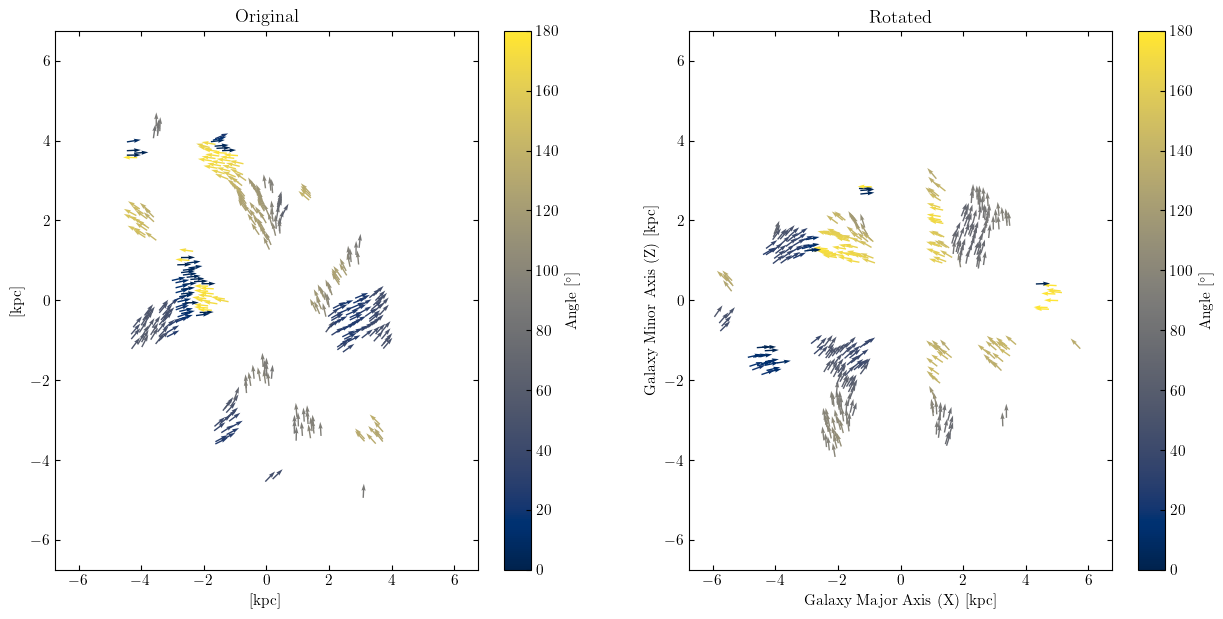

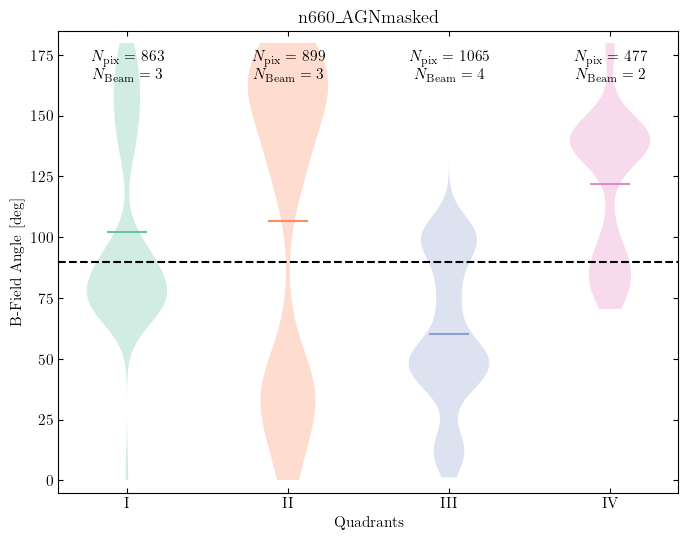

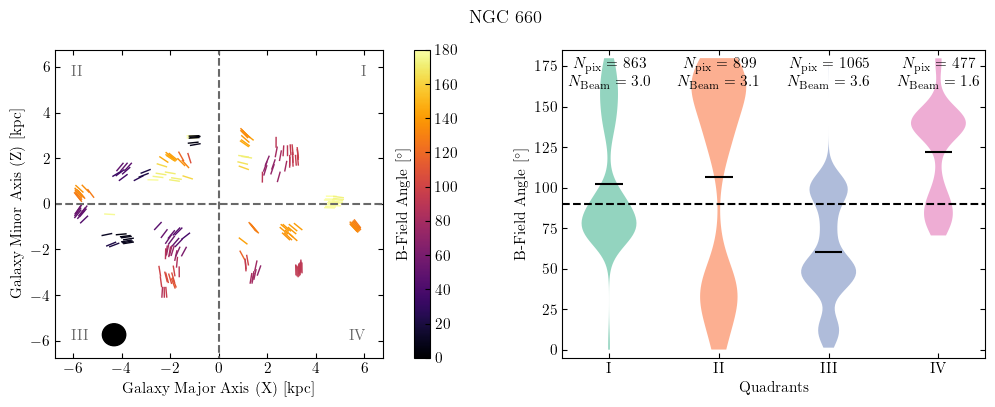

In [5]:
q_n660_AGN_masked = main_analysis(gal_indicator="n660_AGNmasked", dist_Mpc=12.3, pos_ang=44, gal_diam_kpc=10.8,
                        fits_path="fits_maps/n660/N660_D_C_Uvtap_X_final_plus_AGN_masked.FITS",
                        cut_pos=SkyCoord('01h43m02.4000s+13d38m42.200s'),
                        cut_size=250*u.arcsec, lim_axes=12, scale=30, fit_x=False, fit_x_norm=False)

## N891

### Standard Setup

Filename: fits_maps/n891/N891_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   (451, 451)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (451, 451),
Image dimensions: [451, 451],
Radio Beam object: 6.055326174927313e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 15.3459854125992 arcsec
Beam Minor axis (FWHM)[arcsec]: 14.815919399198402 arcsec
Beam area [arcsec^2]: 257.6248833110305 arcsec2
N pixels per Beam: 64.4
Data contains 5597 not-NAN pixels
Beam Major axis [kpc]: 0.6770348750226247
Correct polarisation angle for galaxy pos. ang:
Prior to rotati

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 5597
Number of cells after spatial average: 148
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 18
    # data points      = 148
    # variables        = 1
    chi-square         = 6168.78006
    reduced chi-square = 41.9644902
    Akaike info crit   = 554.046527
    Bayesian info crit = 557.043739
    R-squared          = 0.98293746
[[Variables]]
    a:  0.10783144 +/- 0.01194172 (11.07%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 148
    # variables        = 1
    chi-square         = 6540.87743
    reduced chi-square = 44.4957648
    Akaike info crit   = 562.714920
    Ba

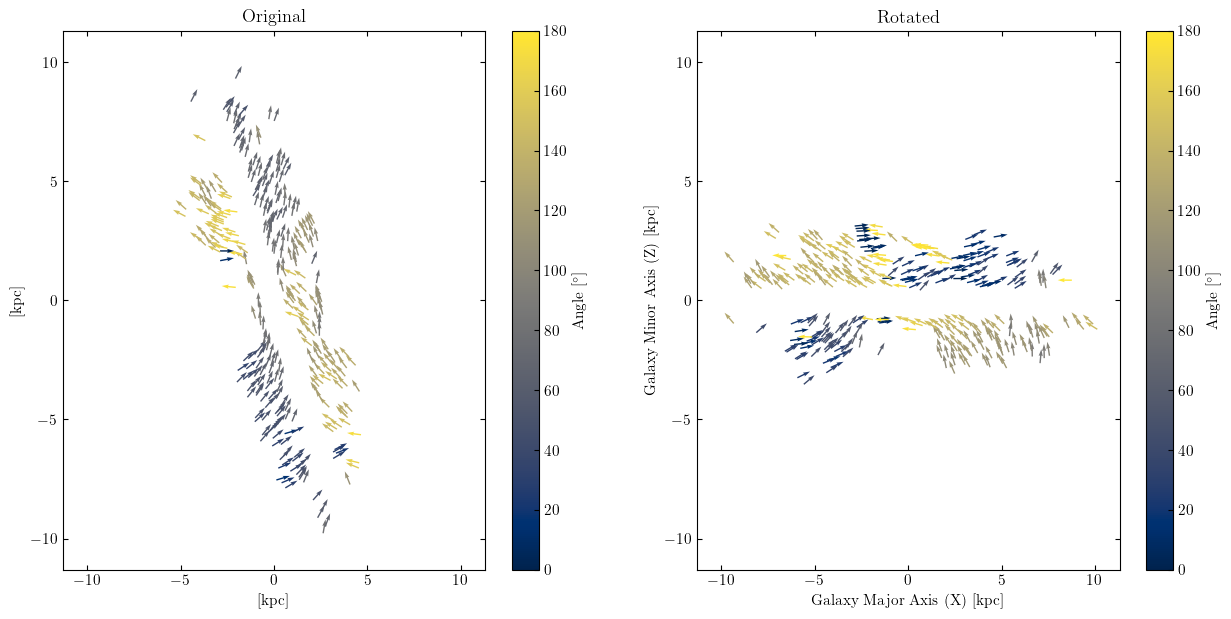

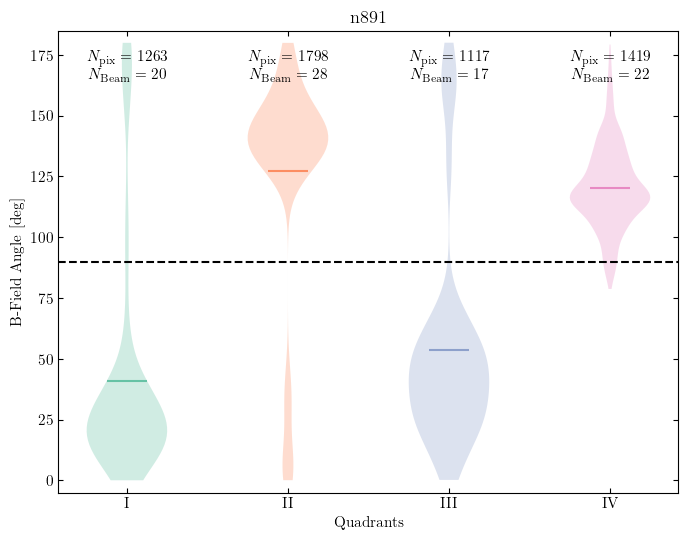

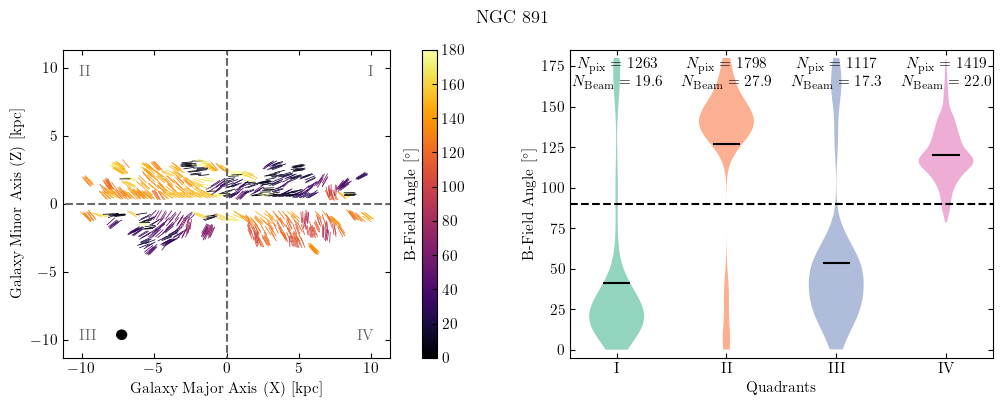

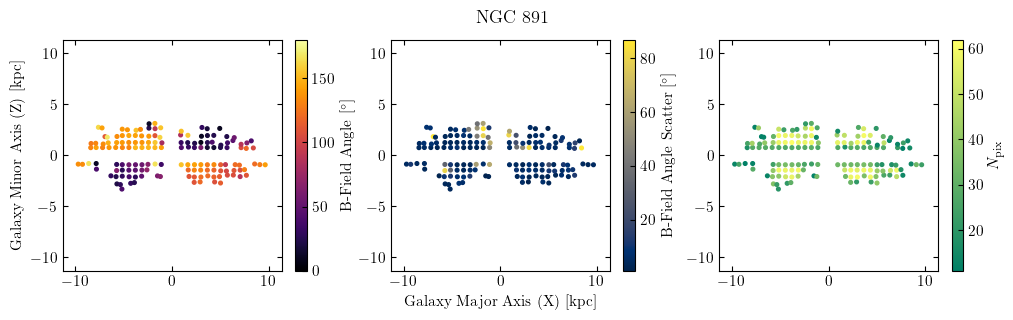

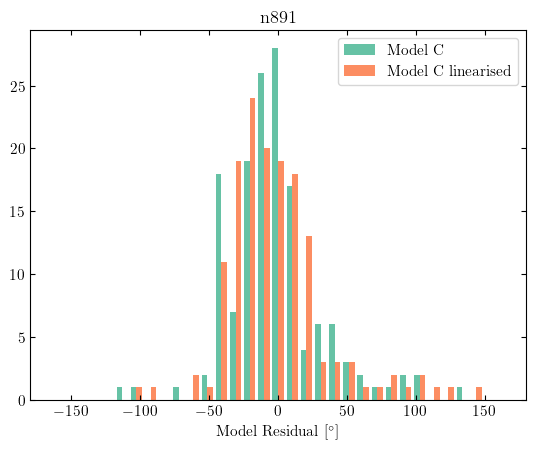

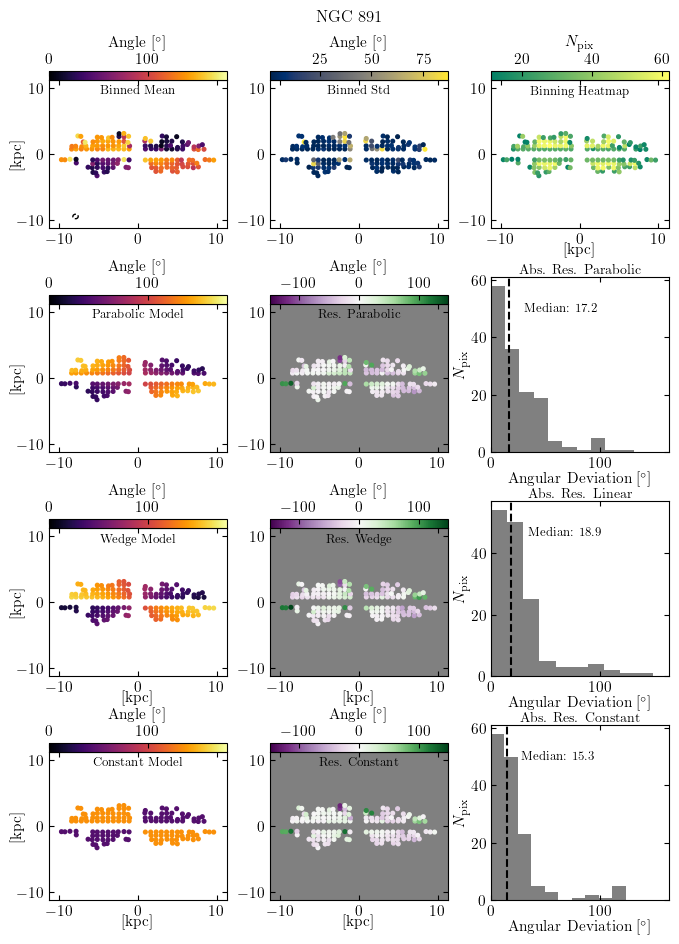

In [3]:
res_n891, res_n891_lin, res_n891_const, q_n891, med_dev_a_n891, med_dev_b_n891, med_dev_c_n891, n_beam_fitted_n891 = main_analysis(gal_indicator="n891", dist_Mpc=9.1, pos_ang=22, gal_diam_kpc=18.1,
                        fits_path="fits_maps/n891/N891_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('02h22m33.4138s+42d20m56.924s'),
                        cut_size=450*u.arcsec, lim_axes=12, scale=30, spatial_averaging=True)

### Feature Masked (not used)

In [7]:
# res_n891_feature_masked, q_n891_feauture_masked = main_analysis(gal_indicator="n891_feature_masked", dist_Mpc=9.1, pos_ang=22, gal_diam_kpc=18.1,
#                         fits_path="fits_maps/n891/N891_D_C_Uvtap_X_final_plus_feature_masked.FITS",
#                         cut_pos=SkyCoord('02h22m33.4138s+42d20m56.924s'),
#                         cut_size=450*u.arcsec, lim_axes=12, scale=30)

## NGC2683

Filename: fits_maps/n2683/N2683_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.266487564985144e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 15.880147933960801 arcsec
Beam Minor axis (FWHM)[arcsec]: 14.816836357117198 arcsec
Beam area [arcsec^2]: 266.6087806110131 arcsec2
N pixels per Beam: 66.7
Data contains 467 not-NAN pixels
Beam Major axis [kpc]: 0.48272184386044353
Correct polarisation angle for galaxy pos. ang:
Prior to ro

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


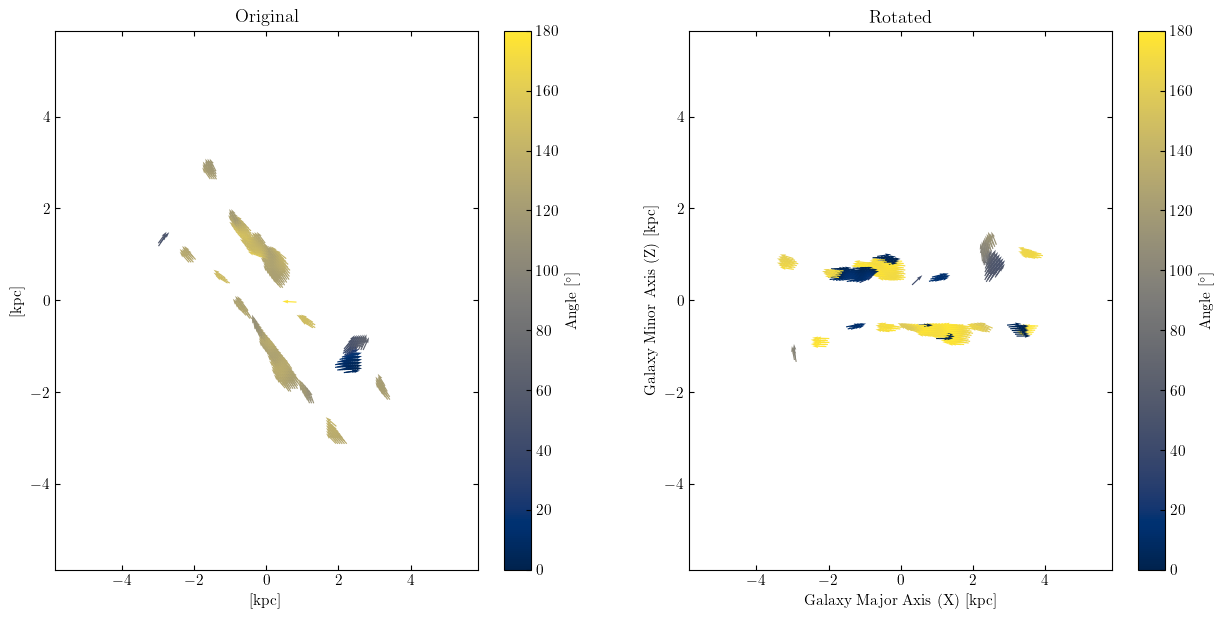

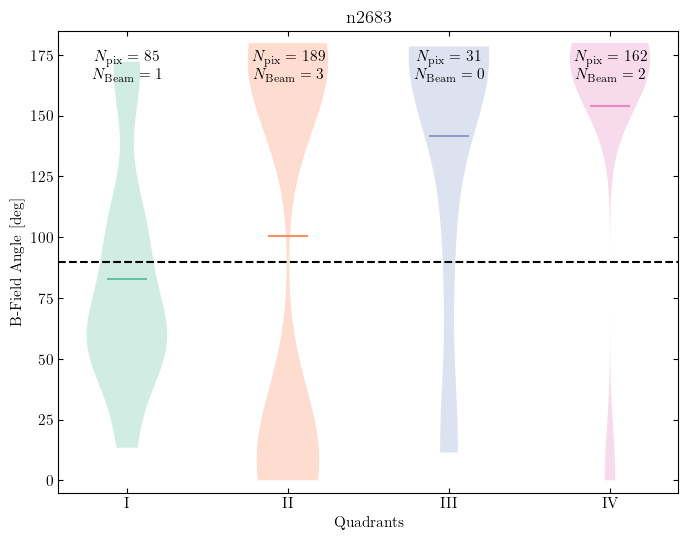

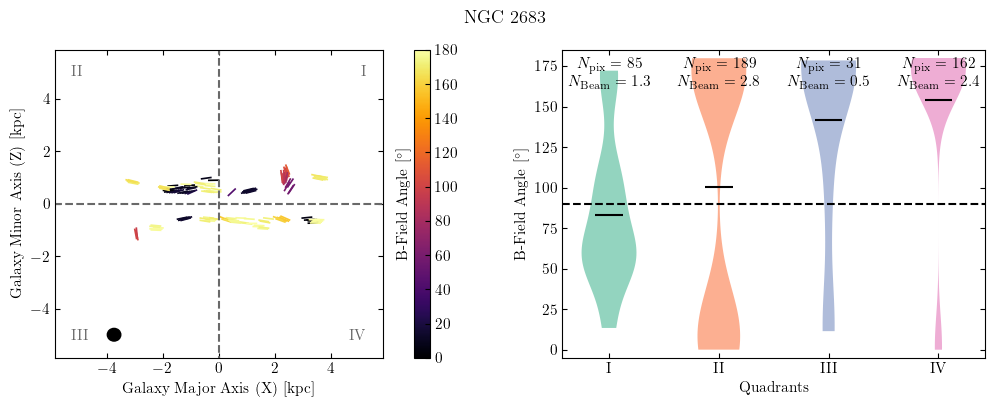

In [8]:
q_n2683 = main_analysis(gal_indicator="n2683", dist_Mpc=6.27, pos_ang=43.6, gal_diam_kpc=9.39,
                        fits_path="fits_maps/n2683/N2683_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('08h52m41.3278s+33d25m18.260s'),
                        cut_size=330*u.arcsec, lim_axes=12, scale=30, fit_x=False, fit_x_norm=False)

## NGC2820

### Standard Setup (Not Used)

In [9]:
# res_2820, q_n2820 = main_analysis(gal_indicator="n2820", dist_Mpc=26.5, pos_ang=61.1, gal_diam_kpc=13.8,
#                         fits_path="fits_maps/n2820/N2820_D_C_Uvtap_X_final_masked.FITS",
#                         cut_pos=SkyCoord('09h21m45.5800s+64d15m28.600s'),
#                         cut_size=330*u.arcsec, lim_axes=12, scale=30)

### North masked

Filename: fits_maps/n2820/N2820_D_C_Uvtap_X_final_plus_north_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.6354807651254026e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 16.2269668579104 arcsec
Beam Minor axis (FWHM)[arcsec]: 15.3539772033708 arcsec
Beam area [arcsec^2]: 282.3076591491026 arcsec2
N pixels per Beam: 70.6
Data contains 274 not-NAN pixels
Beam Major axis [kpc]: 2.084769718016115
Correct polarisation angle for galaxy pos. ang:
Prior

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/home/mstein/anaconda3/envs/py_mayavi/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1026: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/home/mstein/anaconda3/envs/py_mayavi/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mstein/anaconda3/envs/py_mayavi/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, 

Number of pixels before spatial average: 274
Number of cells after spatial average: 7
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 7
    # variables        = 1
    chi-square         = 173.069043
    reduced chi-square = 28.8448405
    Akaike info crit   = 24.4544632
    Bayesian info crit = 24.4003734
    R-squared          = 0.98640286
[[Variables]]
    a:  0.03471815 +/- 0.02173457 (62.60%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 7
    # variables        = 1
    chi-square         = 100.853744
    reduced chi-square = 16.8089573
    Akaike info crit   = 20.6743287
    Bayesian 

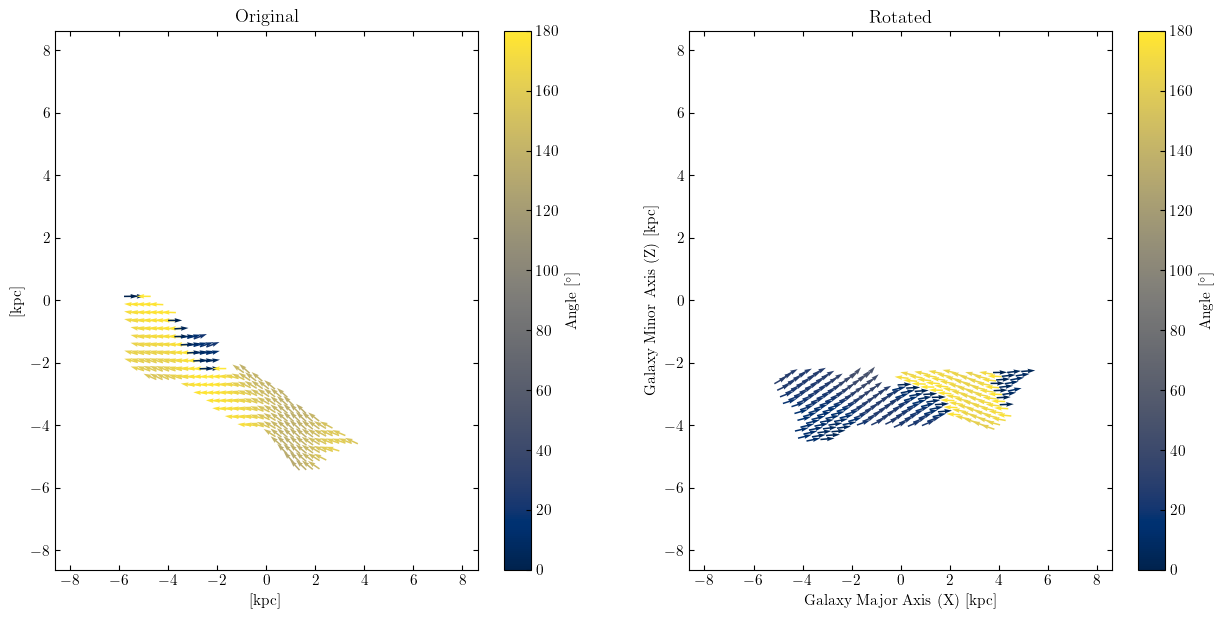

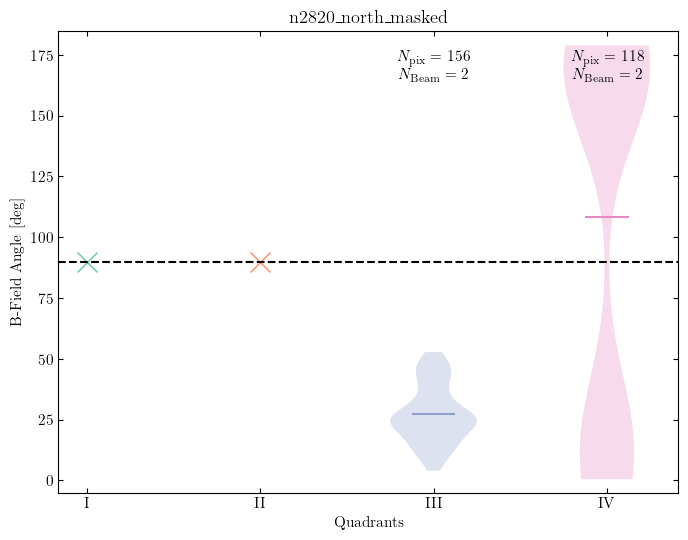

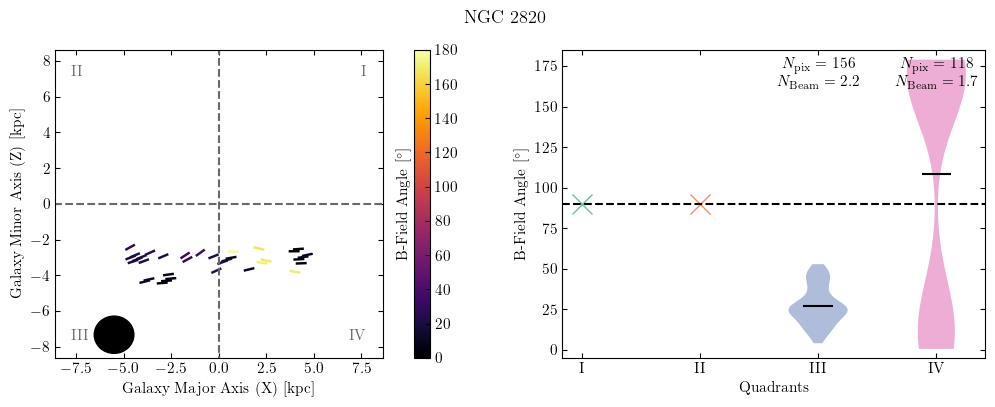

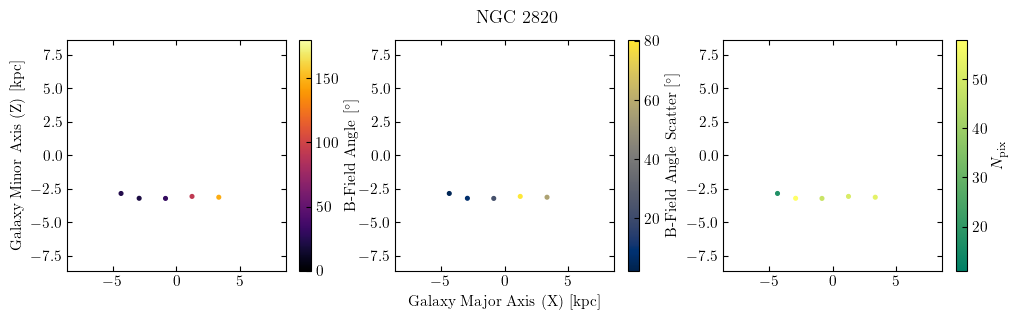

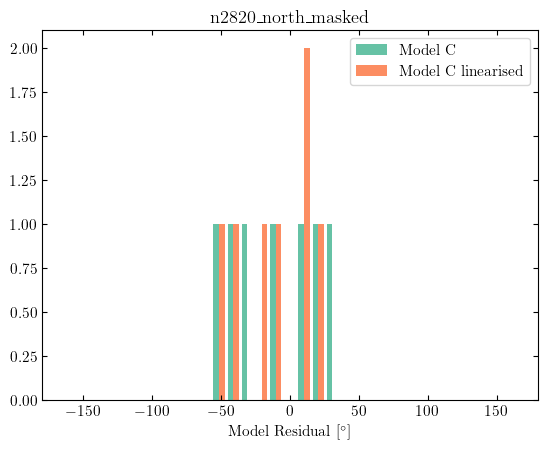

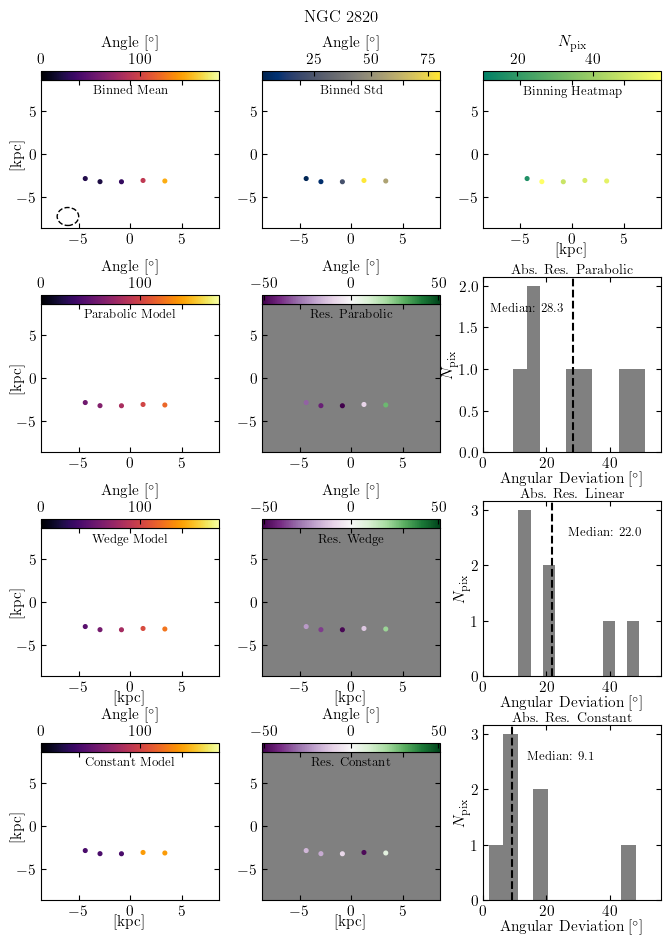

In [10]:
res_n2820_masked_north, res_n2820_masked_north_lin, res_n2820_masked_north_const, q_n2820_masked_north, med_dev_a_n2820_masked_north, med_dev_b_n2820_masked_north, med_dev_c_n2820_masked_north, n_beam_fitted_n2820_masked_north = main_analysis(gal_indicator="n2820_north_masked", dist_Mpc=26.5, pos_ang=61.1, gal_diam_kpc=13.8,
                        fits_path="fits_maps/n2820/N2820_D_C_Uvtap_X_final_plus_north_masked.FITS",
                        cut_pos=SkyCoord('09h21m45.5800s+64d15m28.600s'),
                        cut_size=330*u.arcsec, lim_axes=12, scale=30)

## NGC3044

Filename: fits_maps/n3044/N3044_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 4.995868965534258e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 13.7779035568236 arcsec
Beam Minor axis (FWHM)[arcsec]: 13.6148777008056 arcsec
Beam area [arcsec^2]: 212.55009591591676 arcsec2
N pixels per Beam: 53.1
Data contains 820 not-NAN pixels
Beam Major axis [kpc]: 1.3559823771994146
Correct polarisation angle for galaxy pos. ang:
Prior to rotati

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 820
Number of cells after spatial average: 29
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 29
    # variables        = 1
    chi-square         = 248.732916
    reduced chi-square = 8.88331843
    Akaike info crit   = 64.3234321
    Bayesian info crit = 65.6907279
    R-squared          = 0.99370872
[[Variables]]
    a:  0.06416489 +/- 0.00822026 (12.81%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 29
    # variables        = 1
    chi-square         = 190.137192
    reduced chi-square = 6.79061399
    Akaike info crit   = 56.5330513
    Bayesi

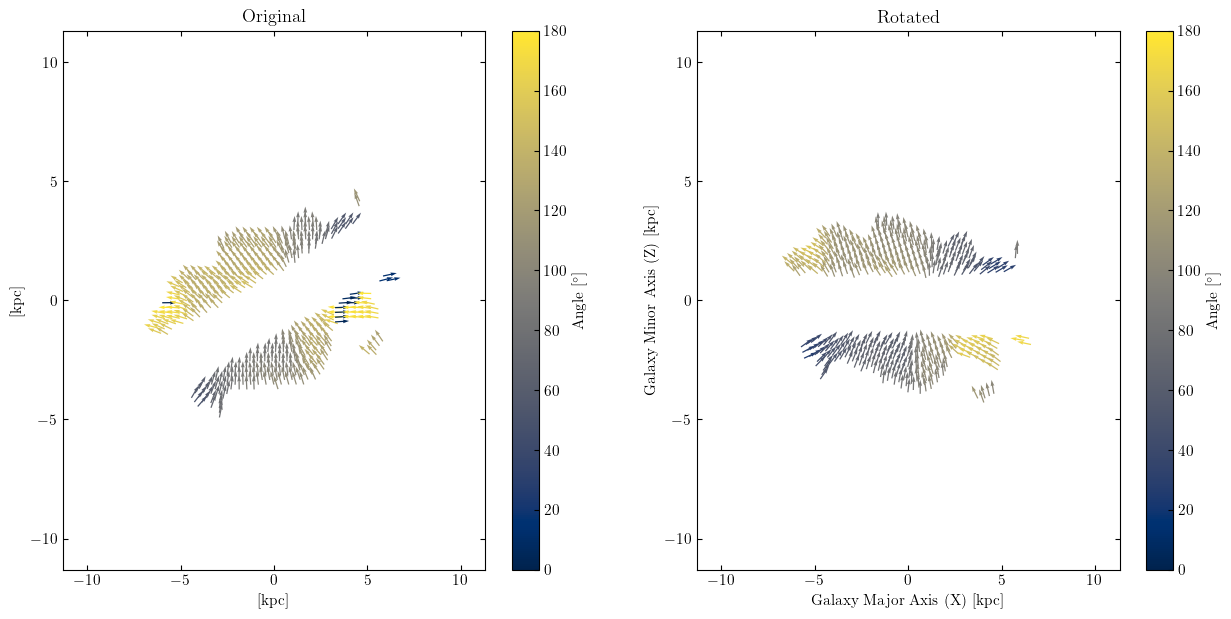

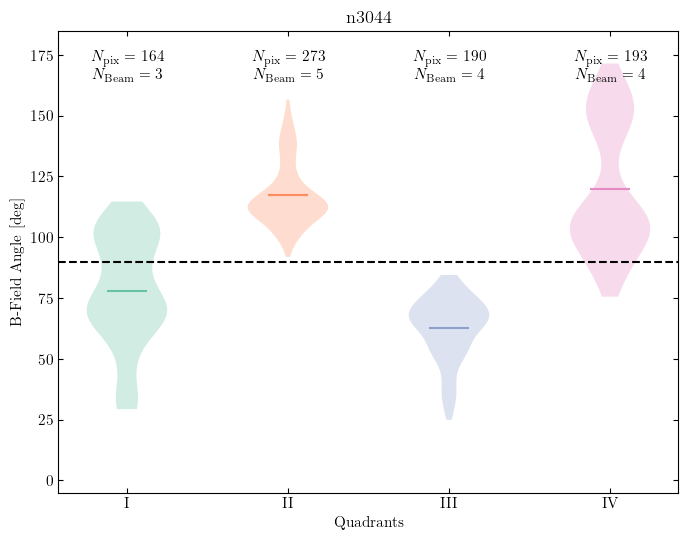

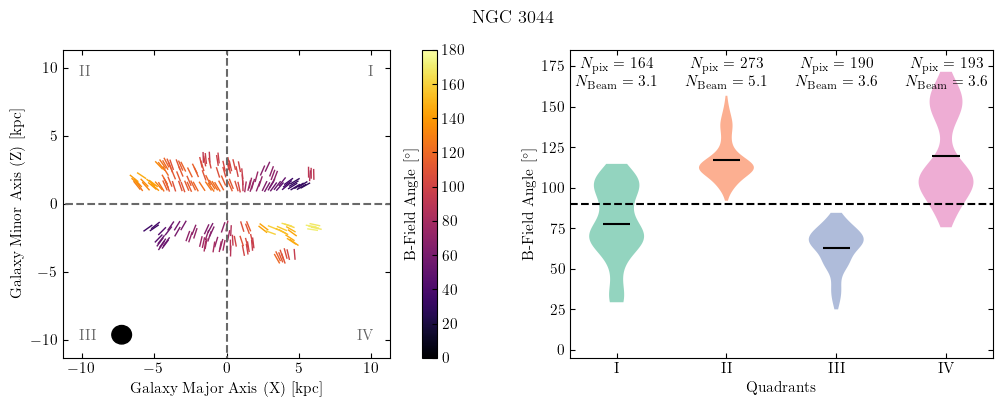

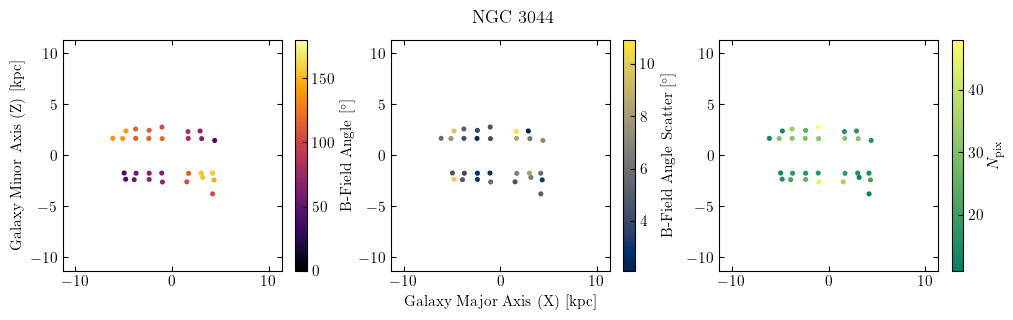

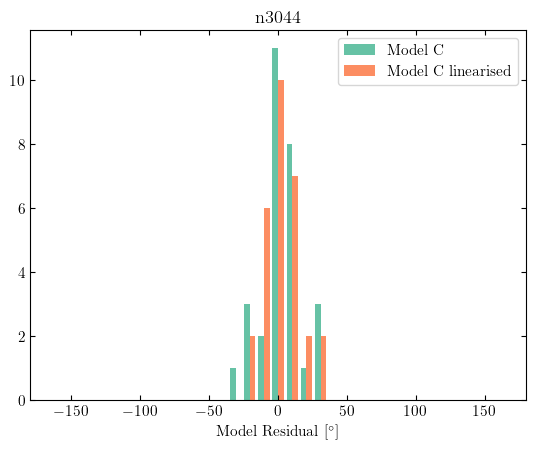

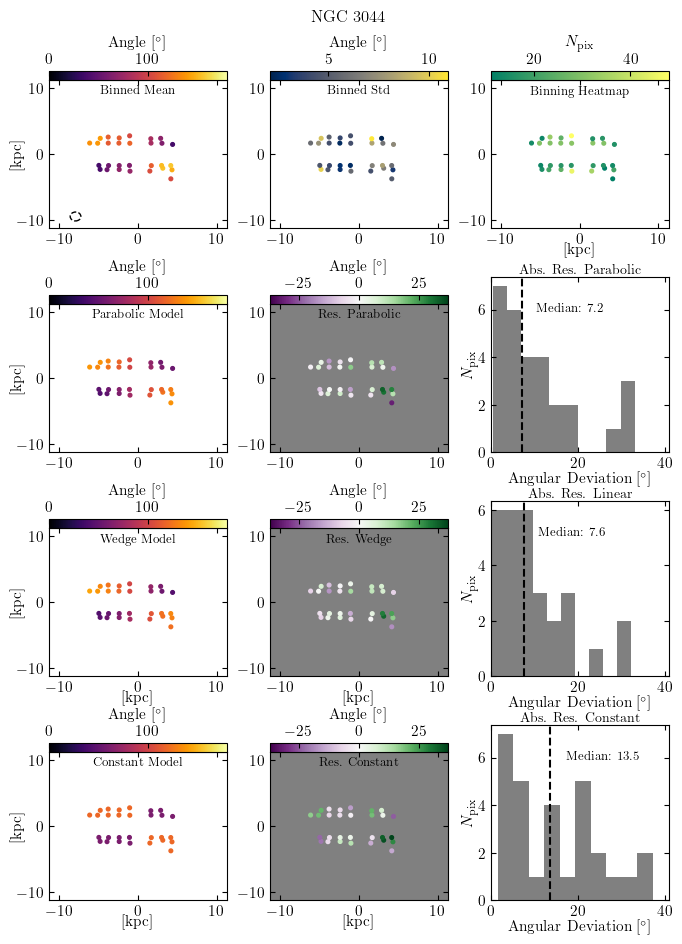

In [11]:
res_n3044, res_n3044_lin, res_n3044_const, q_n3044, med_dev_a_n3044, med_dev_b_n3044, med_dev_c_n3044, n_beam_fitted_n3044 = main_analysis(gal_indicator="n3044", dist_Mpc=20.3, pos_ang=114, gal_diam_kpc=18.1,
                        fits_path="fits_maps/n3044/N3044_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('09h53m40.8800s+01d34m46.700s'),
                        cut_size=350*u.arcsec, lim_axes=12, scale=30)


## NGC3079


### Standard Setup (not used)

In [12]:
# res_n3079, q_n3079 = main_analysis(gal_indicator="n3079", dist_Mpc=20.6, pos_ang=166.2, gal_diam_kpc=26,
#                         fits_path="fits_maps/n3079/N3079_D_C_Uvtap_X_final_masked.FITS",
#                         cut_pos=SkyCoord('10h01m57.8034s+55d40m47.242s'),
#                         cut_size=300*u.arcsec, lim_axes=15, scale=30)

### AGN Masked

Filename: fits_maps/n3079/N3079_D_C_Uvtap_X_final_plus_AGN_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.485693635521334e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 16.092905044554 arcsec
Beam Minor axis (FWHM)[arcsec]: 15.132400512695998 arcsec
Beam area [arcsec^2]: 275.93494021192566 arcsec2
N pixels per Beam: 69.0
Data contains 2361 not-NAN pixels
Beam Major axis [kpc]: 1.6072244709009615
Correct polarisation angle for galaxy pos. ang:
Prio

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 2361
Number of cells after spatial average: 68
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 18
    # data points      = 68
    # variables        = 1
    chi-square         = 24702.1874
    reduced chi-square = 368.689364
    Akaike info crit   = 402.869477
    Bayesian info crit = 405.088985
    R-squared          = 0.87827791
[[Variables]]
    a:  0.02153979 +/- 0.00909637 (42.23%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 68
    # variables        = 1
    chi-square         = 24372.9001
    reduced chi-square = 363.774628
    Akaike info crit   = 401.956922
    Bayes

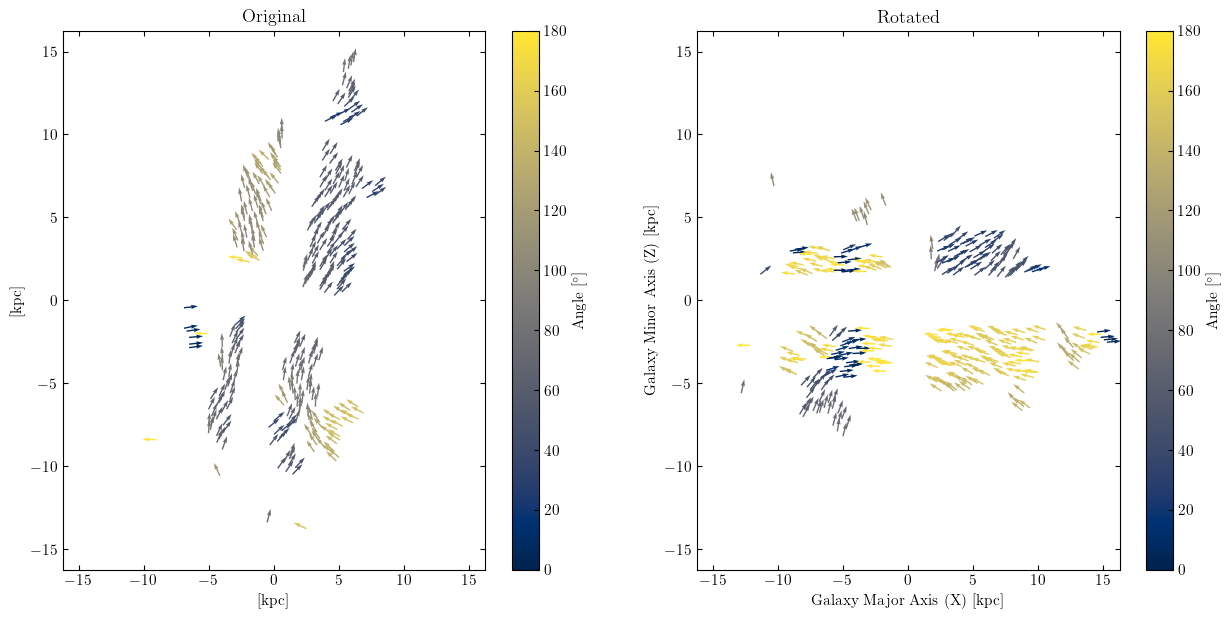

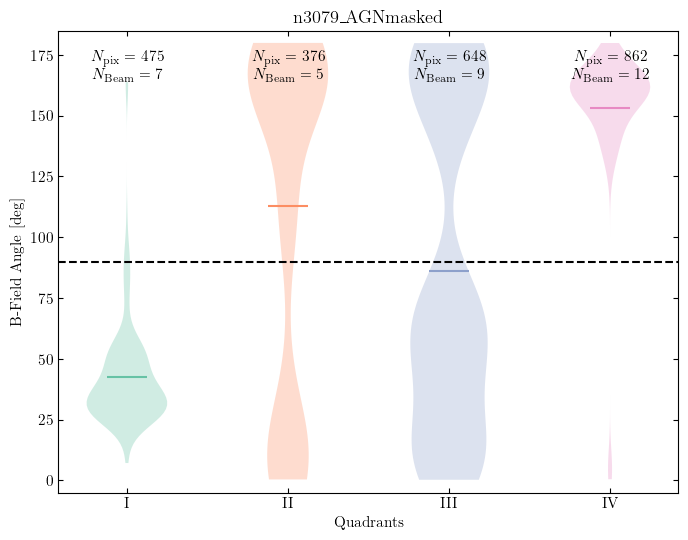

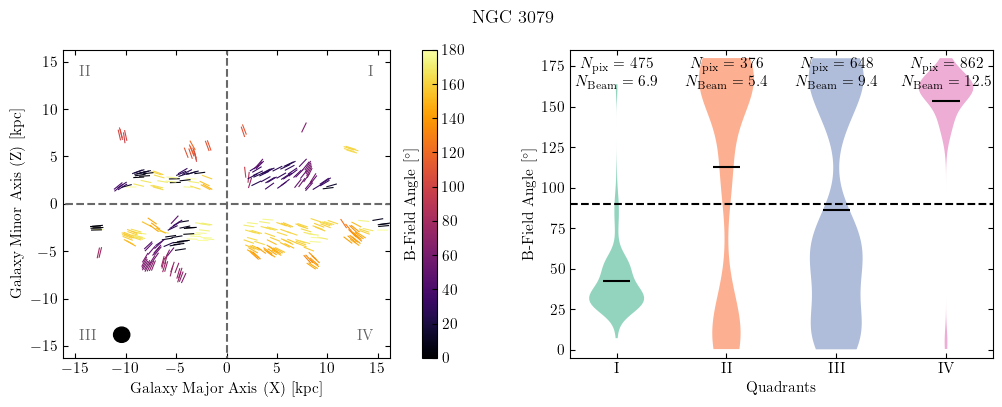

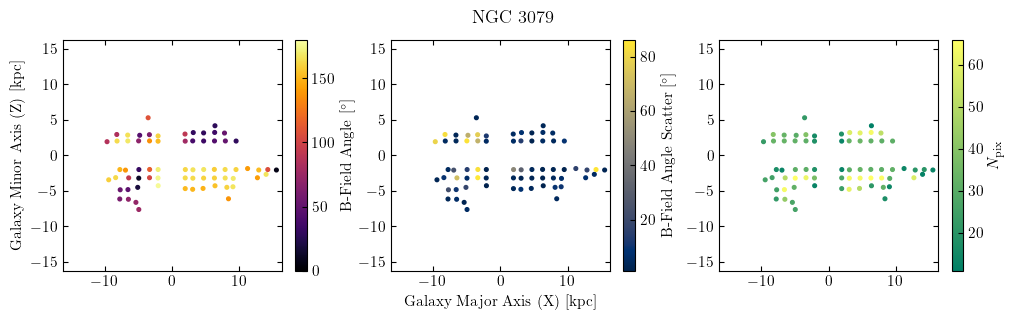

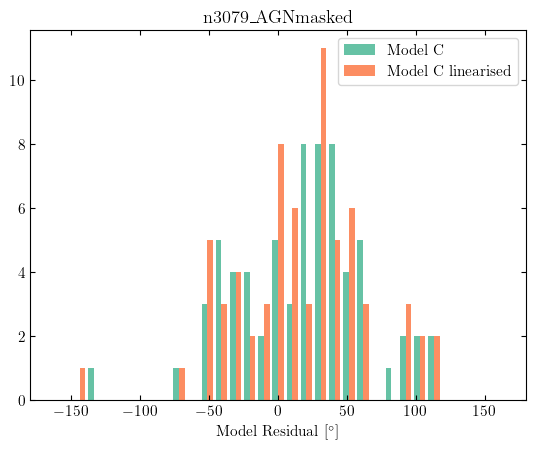

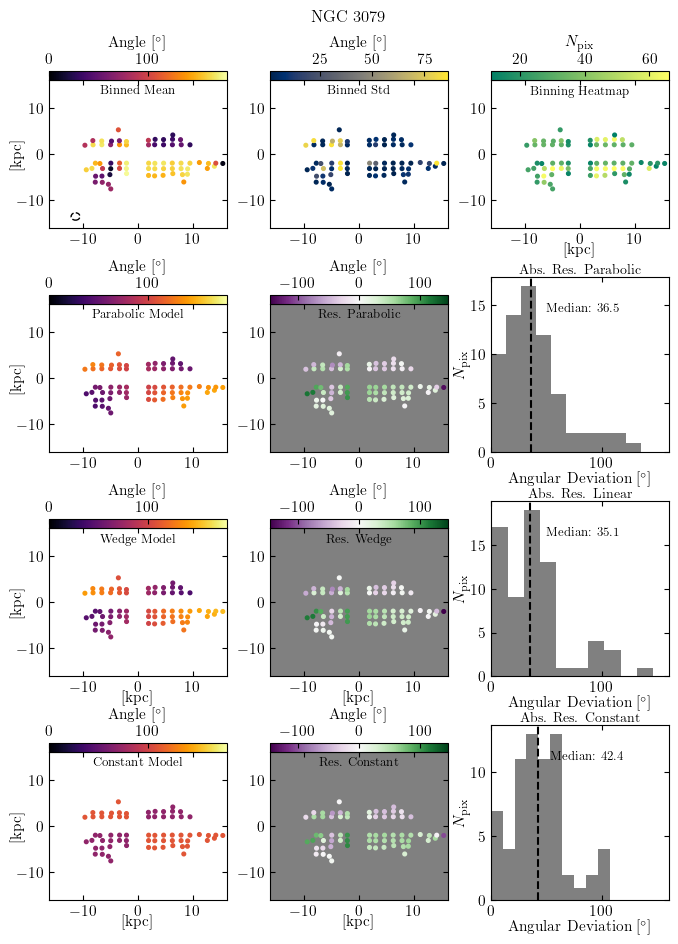

In [13]:
res_n3079_AGNmasked, res_n3079_AGNmasked_lin, res_n3079_AGNmasked_const, q_n3079_ANGmasked, med_dev_a_n3079_ANGmasked, med_dev_b_n3079_ANGmasked, med_dev_c_n3079_ANGmasked, n_beam_fitted_n3079_ANGmasked = main_analysis(gal_indicator="n3079_AGNmasked", dist_Mpc=20.6, pos_ang=166.2, gal_diam_kpc=26,
                        fits_path="fits_maps/n3079/N3079_D_C_Uvtap_X_final_plus_AGN_masked.FITS",
                        cut_pos=SkyCoord('10h01m57.8034s+55d40m47.242s'),
                        cut_size=300*u.arcsec, lim_axes=15, scale=30)

## NGC3432

Filename: fits_maps/n3432/N3432_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 5.251225883325761e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 15.0091962814332 arcsec
Beam Minor axis (FWHM)[arcsec]: 13.136785507202399 arcsec
Beam area [arcsec^2]: 223.41429946965678 arcsec2
N pixels per Beam: 55.9
Data contains 827 not-NAN pixels
Beam Major axis [kpc]: 0.6854617208139341
Correct polarisation angle for galaxy pos. ang:
Prior to rota

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


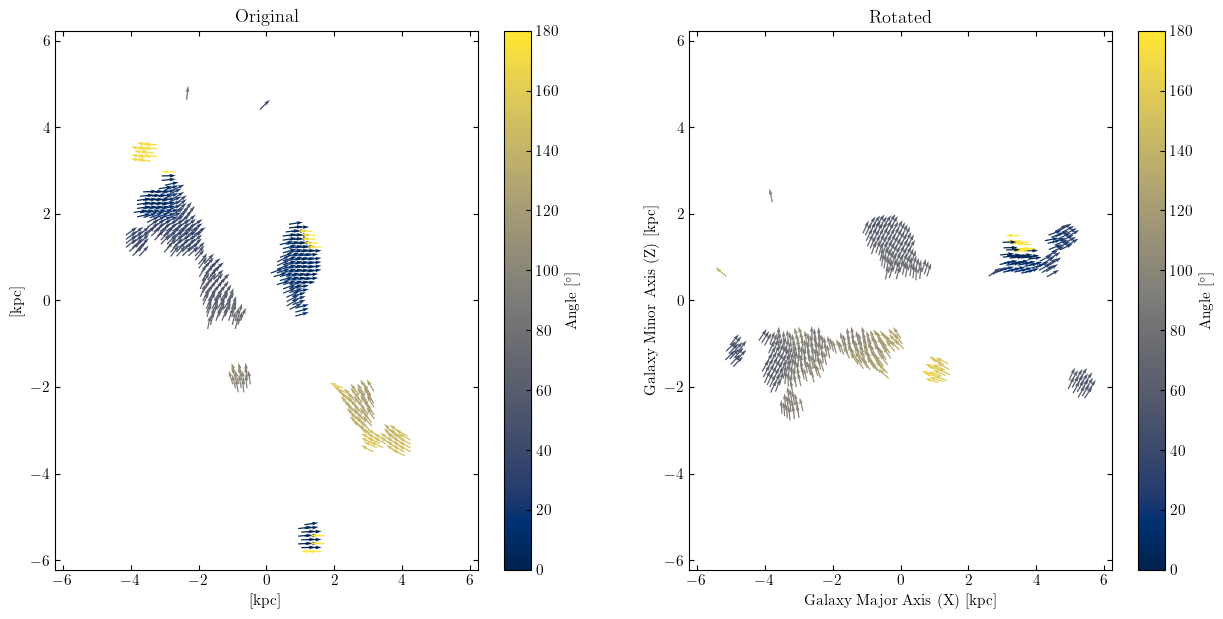

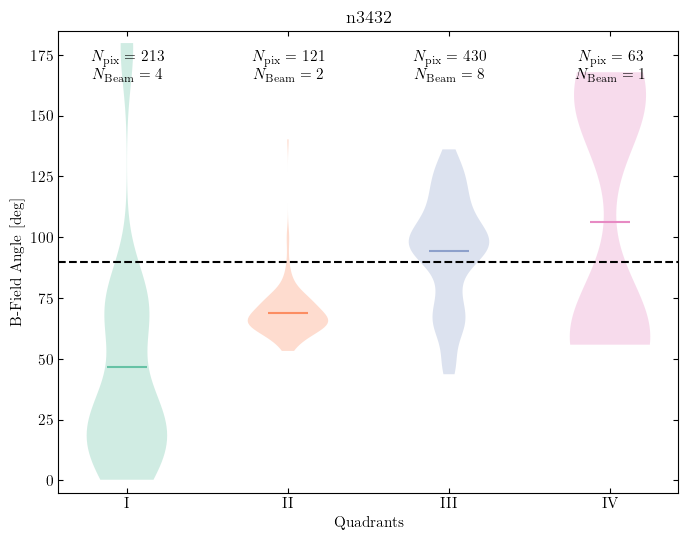

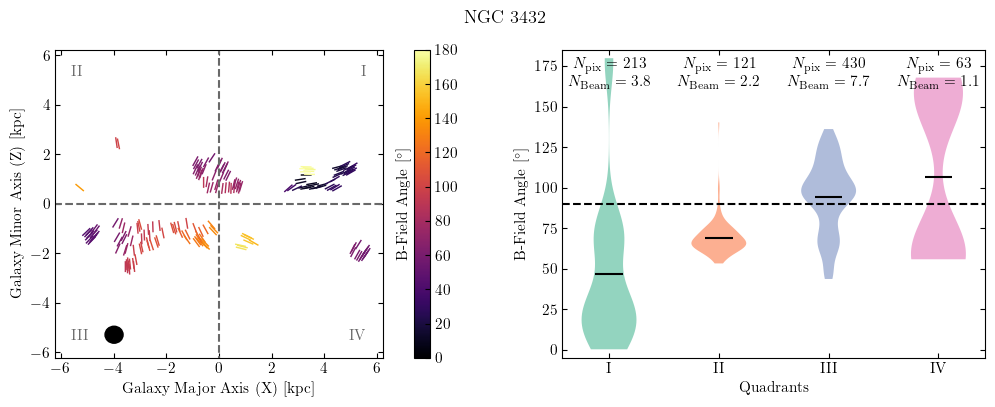

In [14]:
q_n3432 = main_analysis(gal_indicator="n3432", dist_Mpc=9.42, pos_ang=33, gal_diam_kpc=9.96,
                        fits_path="fits_maps/n3432/N3432_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('10h52m31.1300s+36d37m07.600s'),
                        cut_size=350*u.arcsec, lim_axes=15, scale=30, fit_x=False, fit_x_norm=False)

## NGC3448

Filename: fits_maps/n3448/N3448_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.75544142050983e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 16.0863246917712 arcsec
Beam Minor axis (FWHM)[arcsec]: 15.768222808838399 arcsec
Beam area [arcsec^2]: 287.41140566127103 arcsec2
N pixels per Beam: 71.9
Data contains 332 not-NAN pixels
Beam Major axis [kpc]: 0.7346535816282663
Correct polarisation angle for galaxy pos. ang:
Prior to rotat

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 332
Number of cells after spatial average: 9
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 9
    # variables        = 1
    chi-square         = 66.6300111
    reduced chi-square = 8.32875139
    Akaike info crit   = 20.0173746
    Bayesian info crit = 20.2145992
    R-squared          = 0.98028679
[[Variables]]
    a:  0.30511033 +/- 0.06582819 (21.58%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 9
    # variables        = 1
    chi-square         = 70.0693332
    reduced chi-square = 8.75866665
    Akaike info crit   = 20.4703458
    Bayesian 

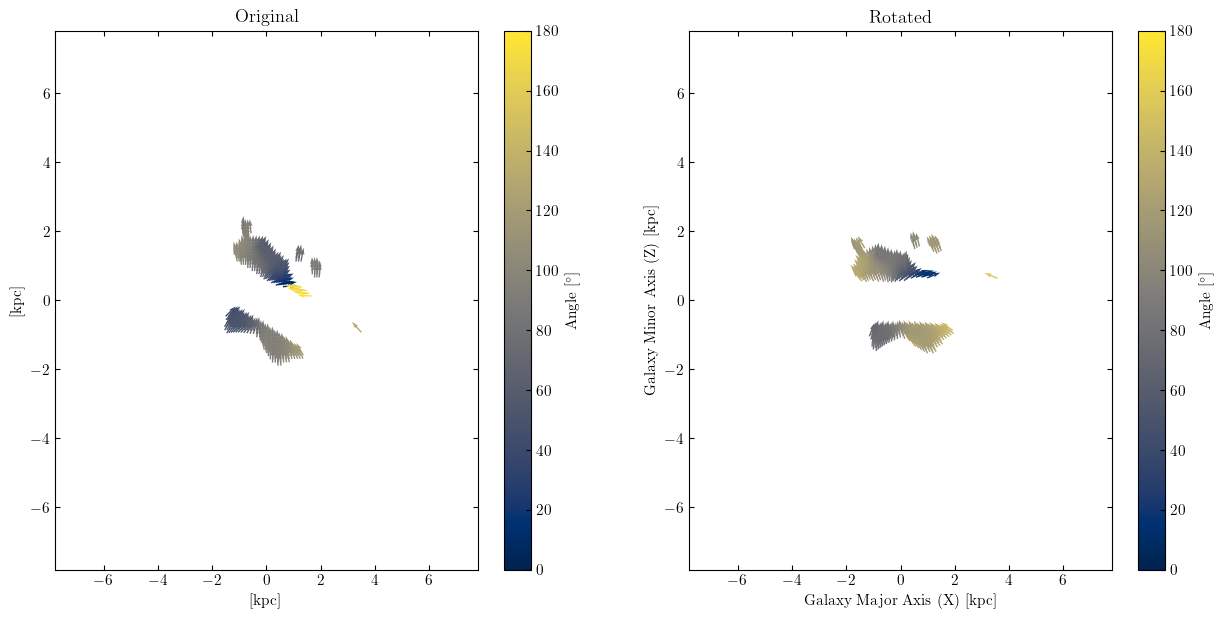

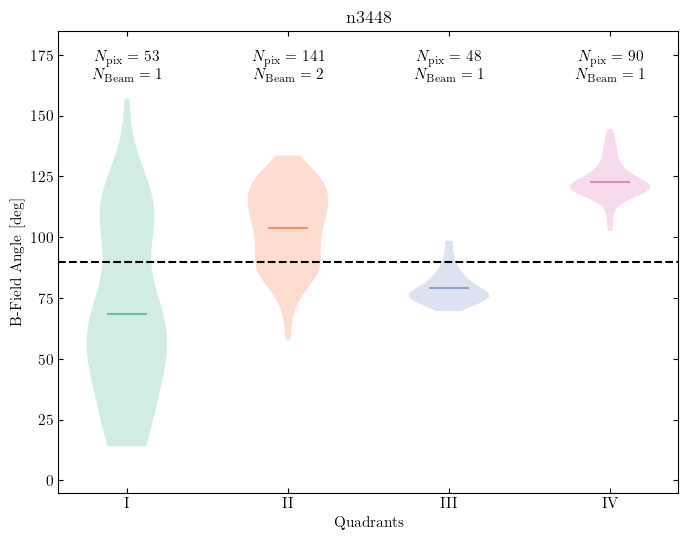

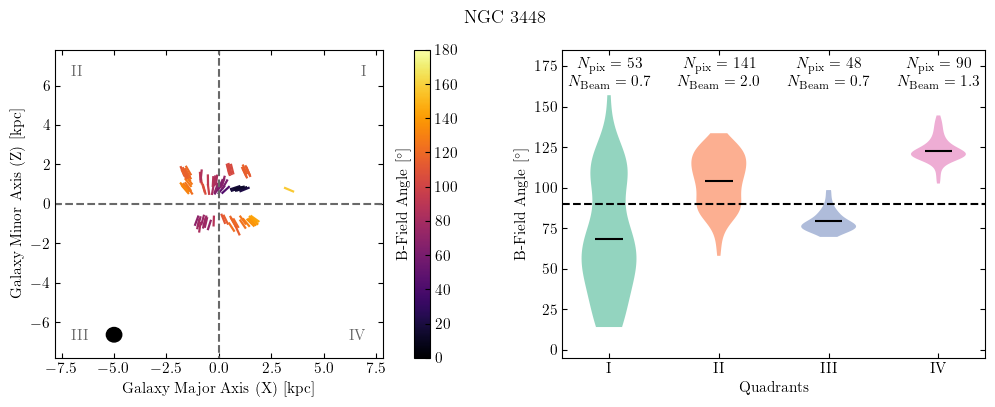

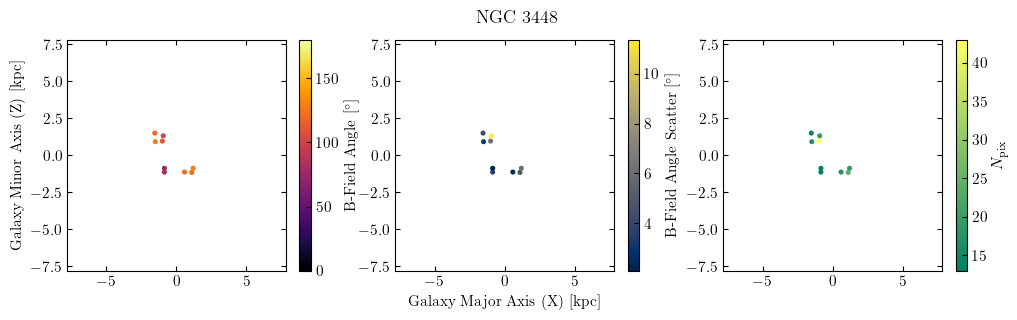

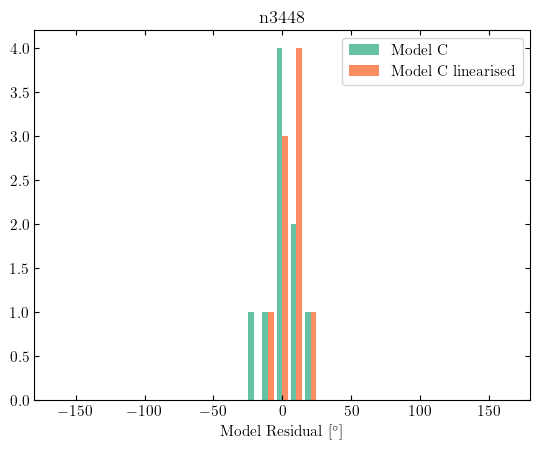

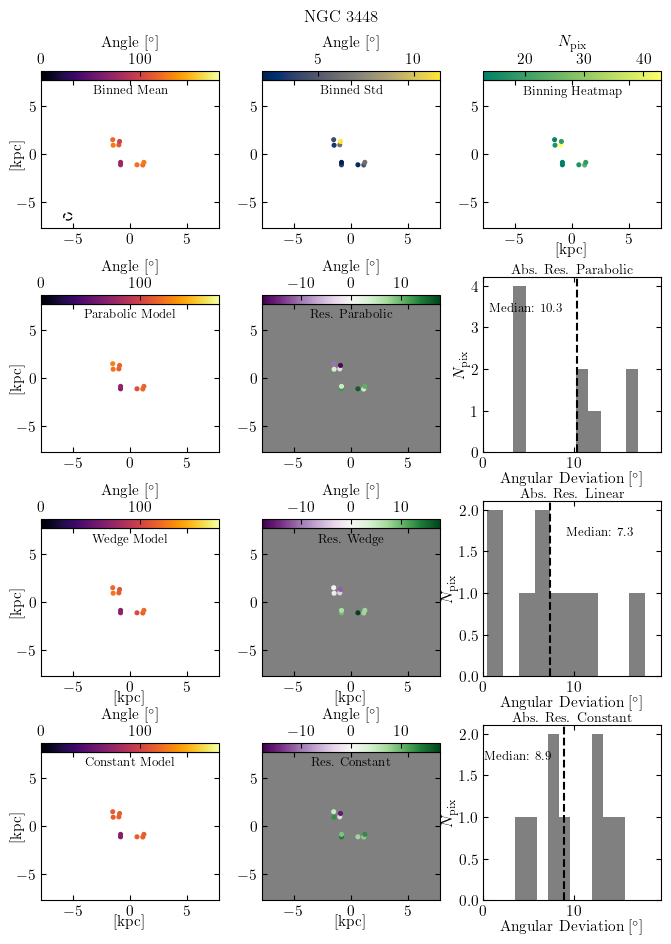

In [15]:
res_n3448, res_n3448_lin, res_n3448_const, q_n3448, med_dev_a_n3448, med_dev_b_n3448,  med_dev_c_n3448, n_beam_fitted_n3448 = main_analysis(gal_indicator="n3448", dist_Mpc=9.42, pos_ang=64.8, gal_diam_kpc=12.5,
                        fits_path="fits_maps/n3448/N3448_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('10h54m39.2000s+54d18m17.500s'),
                        cut_size=250*u.arcsec, lim_axes=15, scale=30)

## NGC3556

Filename: fits_maps/n3556/N3556_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.644715333884976e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 16.033962249756 arcsec
Beam Minor axis (FWHM)[arcsec]: 15.5604219436656 arcsec
Beam area [arcsec^2]: 282.7005454495902 arcsec2
N pixels per Beam: 70.7
Data contains 2396 not-NAN pixels
Beam Major axis [kpc]: 1.095283932937084
Correct polarisation angle for galaxy pos. ang:
Prior to rotation

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


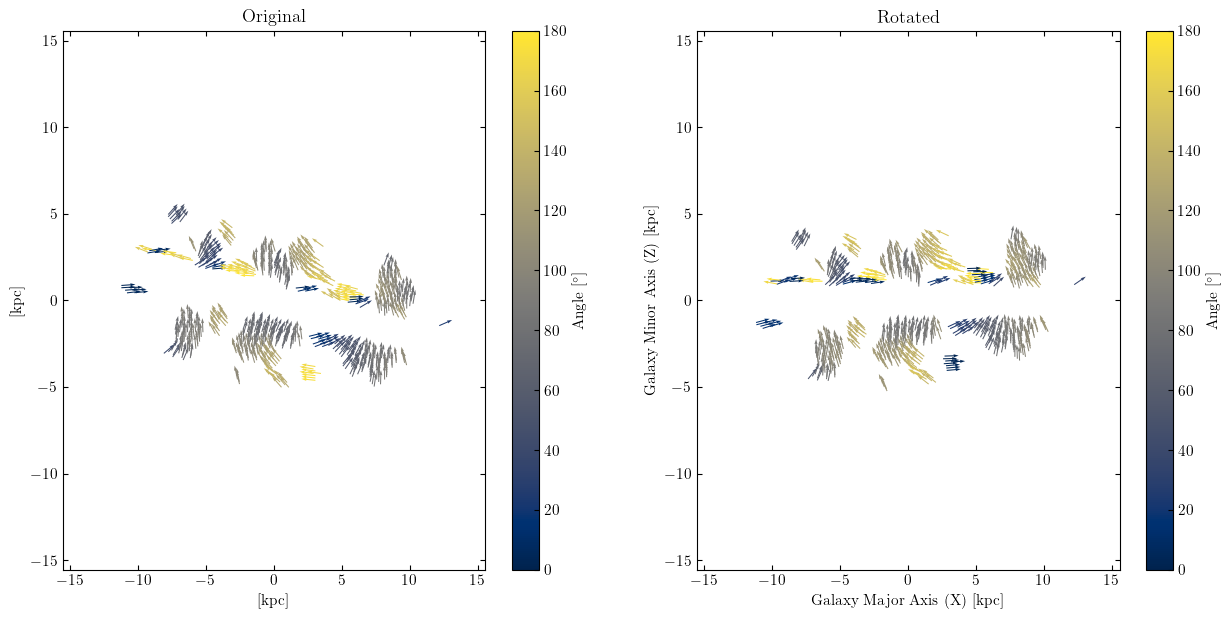

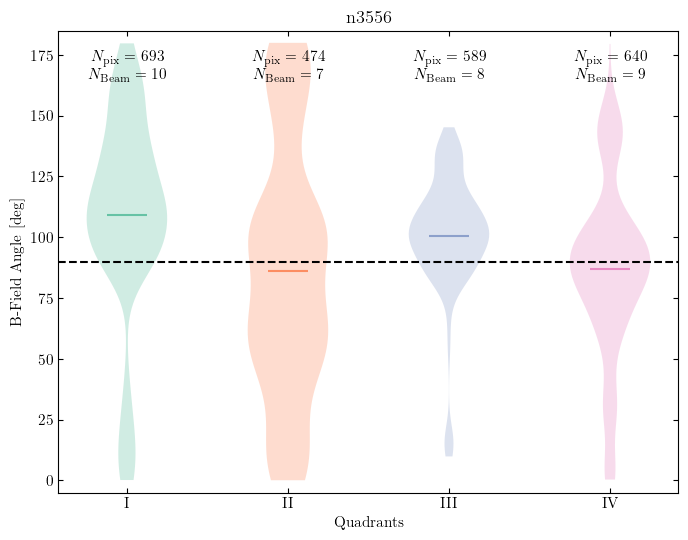

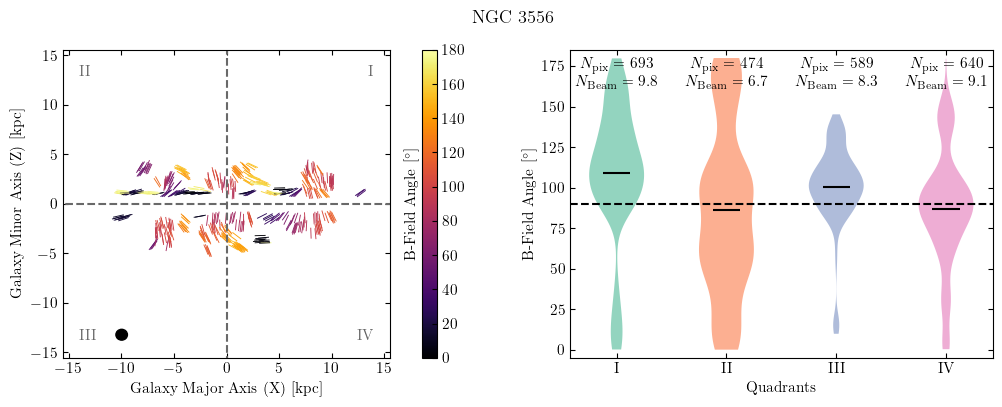

In [16]:
q_n3556 = main_analysis(gal_indicator="n3556", dist_Mpc=14.09, pos_ang=79, gal_diam_kpc=24.9,
                        fits_path="fits_maps/n3556/N3556_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('11h11m30.9700s+55d40m26.800s'),
                        cut_size=450*u.arcsec, lim_axes=15, scale=30, fit_x=False, fit_x_norm=False, n_arrows=500)

## NGC3628

### Standard Setup (not used)

In [17]:
# res_n3628, q_n3628 = main_analysis(gal_indicator="n3628", dist_Mpc=8.5, pos_ang=103.6, gal_diam_kpc=24.5,
#                         fits_path="fits_maps/n3628/N3628_D_C_Uvtap_X_final_masked.FITS",
#                         cut_pos=SkyCoord('11h20m16.9704s+13d35m22.862s'),
#                         cut_size=900*u.arcsec, lim_axes=15, scale=30)

### Thick disk (not used)

In [18]:
# res_n3628_thick, q_n3628_thick = main_analysis(gal_indicator="n3628_thick", dist_Mpc=8.5, pos_ang=103.6, gal_diam_kpc=24.5,
#                         fits_path="fits_maps/n3628/N3628_D_C_Uvtap_X_final_plus_thickdiskmasked.FITS",
#                         cut_pos=SkyCoord('11h20m16.9704s+13d35m22.862s'),
#                         cut_size=900*u.arcsec, lim_axes=15, scale=30)

### AGN Masked

Filename: fits_maps/n3628/N3628_D_C_Uvtap_X_final_plus_AGN_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (451, 451)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (451, 451),
Image dimensions: [451, 451],
Radio Beam object: 6.80047446369263e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 16.8371219634984 arcsec
Beam Minor axis (FWHM)[arcsec]: 15.1655163765012 arcsec
Beam area [arcsec^2]: 289.32734415243726 arcsec2
N pixels per Beam: 72.3
Data contains 3209 not-NAN pixels
Beam Major axis [kpc]: 0.6938437020504502
Correct polarisation angle for galaxy pos. ang:
Prior 

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


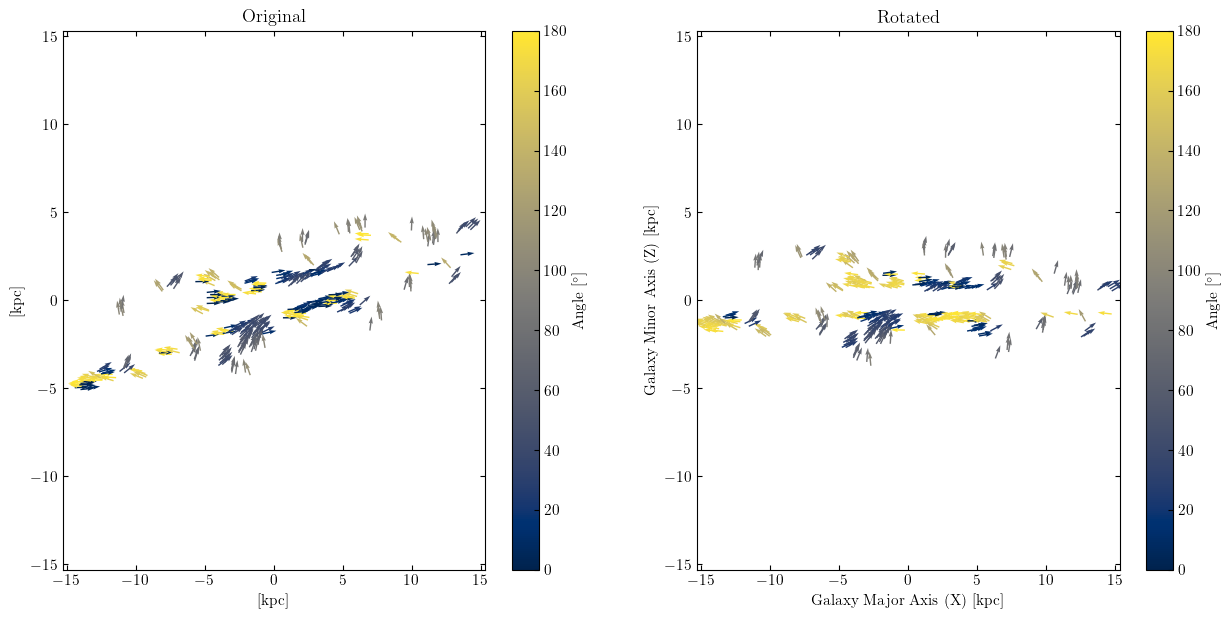

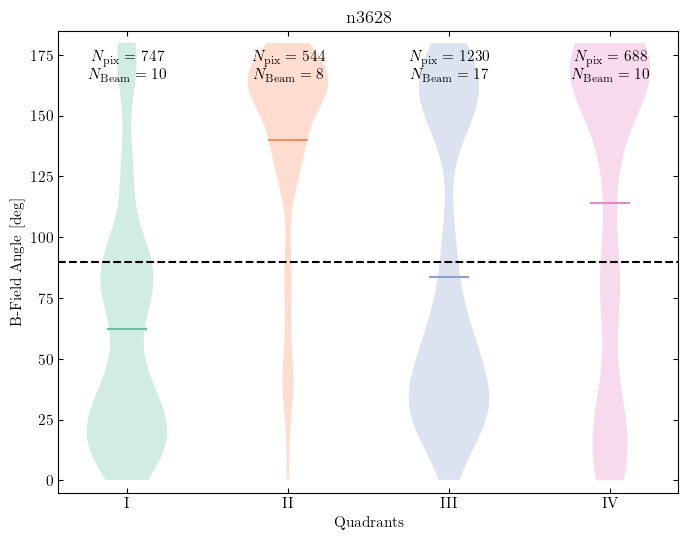

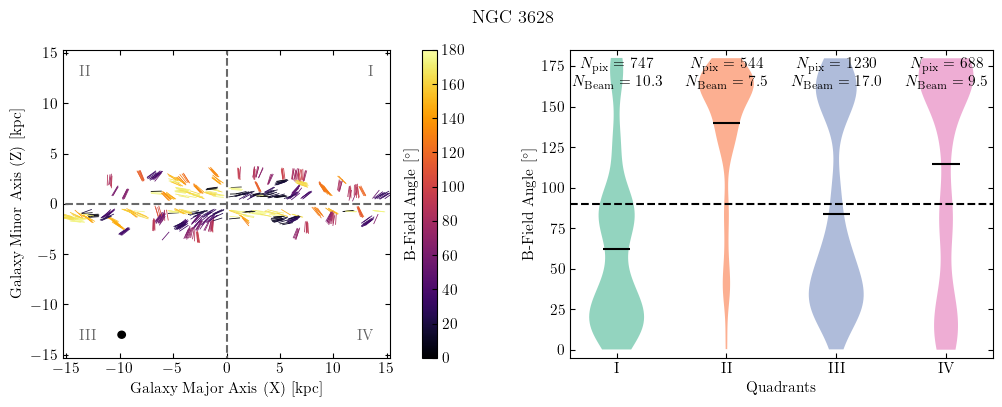

In [19]:
q_n3628_AGNmasked = main_analysis(gal_indicator="n3628", dist_Mpc=8.5, pos_ang=103.6, gal_diam_kpc=24.5,
                        fits_path="fits_maps/n3628/N3628_D_C_Uvtap_X_final_plus_AGN_masked.FITS",
                        cut_pos=SkyCoord('11h20m16.9704s+13d35m22.862s'),
                        cut_size=900*u.arcsec, lim_axes=15, scale=30, fit_x=False, fit_x_norm=False)

## NGC3735

Filename: fits_maps/n3735/N3735_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.810951991287866e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 16.37788772583 arcsec
Beam Minor axis (FWHM)[arcsec]: 15.6147766113276 arcsec
Beam area [arcsec^2]: 289.77311234825925 arcsec2
N pixels per Beam: 72.4
Data contains 547 not-NAN pixels
Beam Major axis [kpc]: 3.3348940973586276
Correct polarisation angle for galaxy pos. ang:
Prior to rotation

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 547
Number of cells after spatial average: 22
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 22
    # variables        = 1
    chi-square         = 5127.84839
    reduced chi-square = 244.183257
    Akaike info crit   = 121.930778
    Bayesian info crit = 123.021820
    R-squared          = 0.93226751
[[Variables]]
    a:  9999.99927 +/- 5234348.92 (52343.49%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 22
    # variables        = 1
    chi-square         = 6736.36224
    reduced chi-square = 320.779154
    Akaike info crit   = 127.933123
    Bay

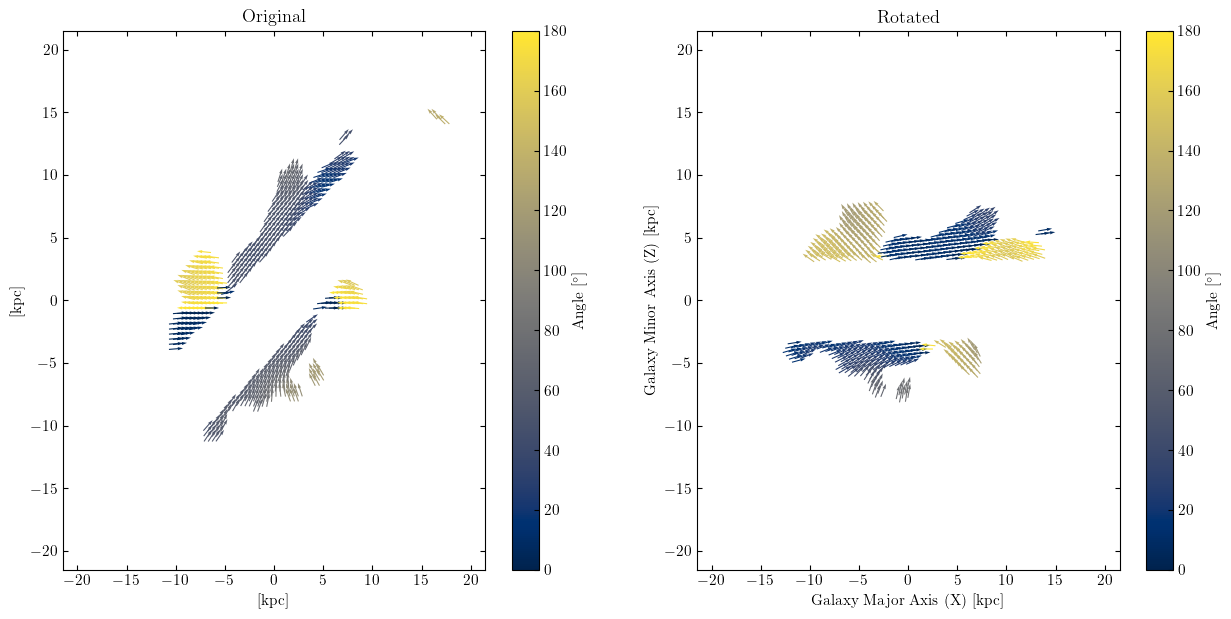

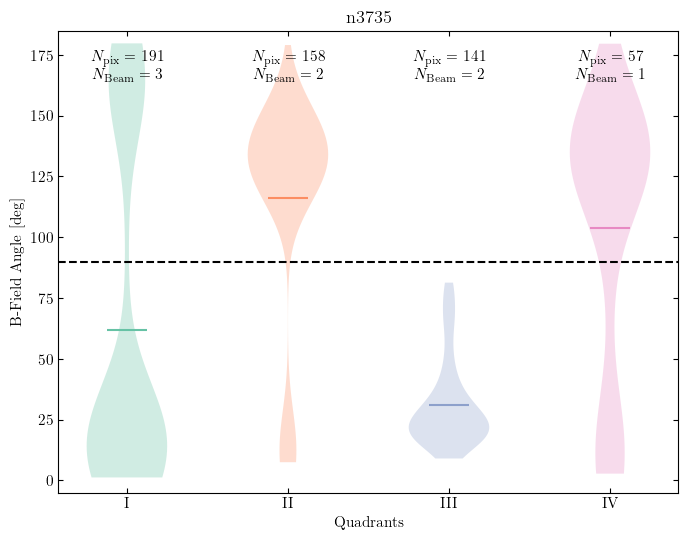

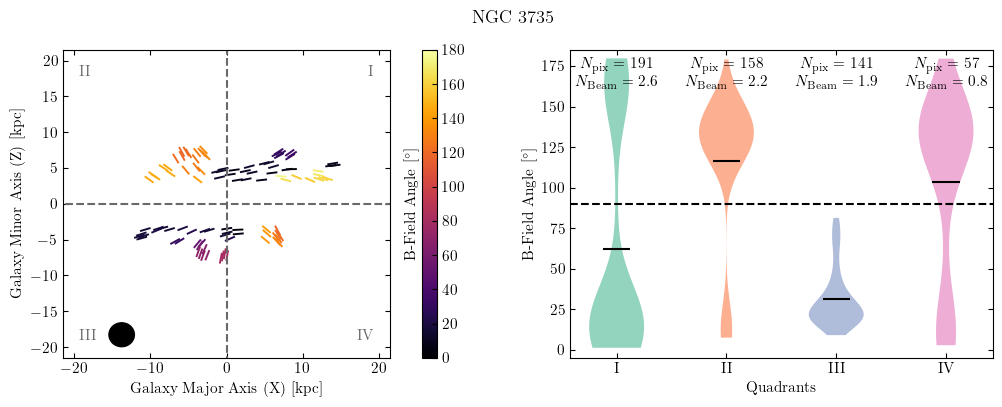

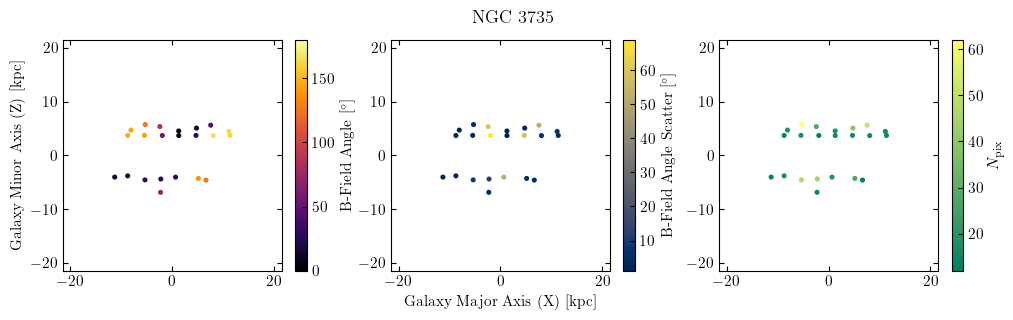

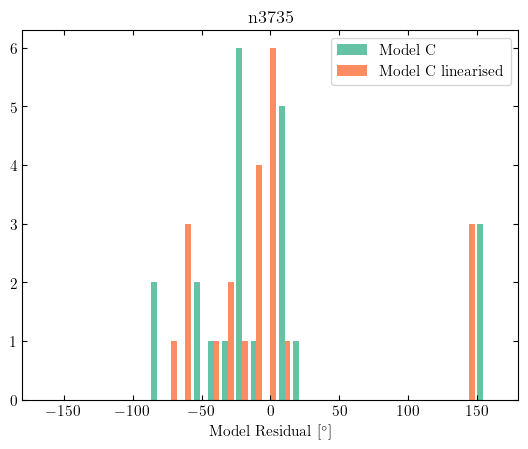

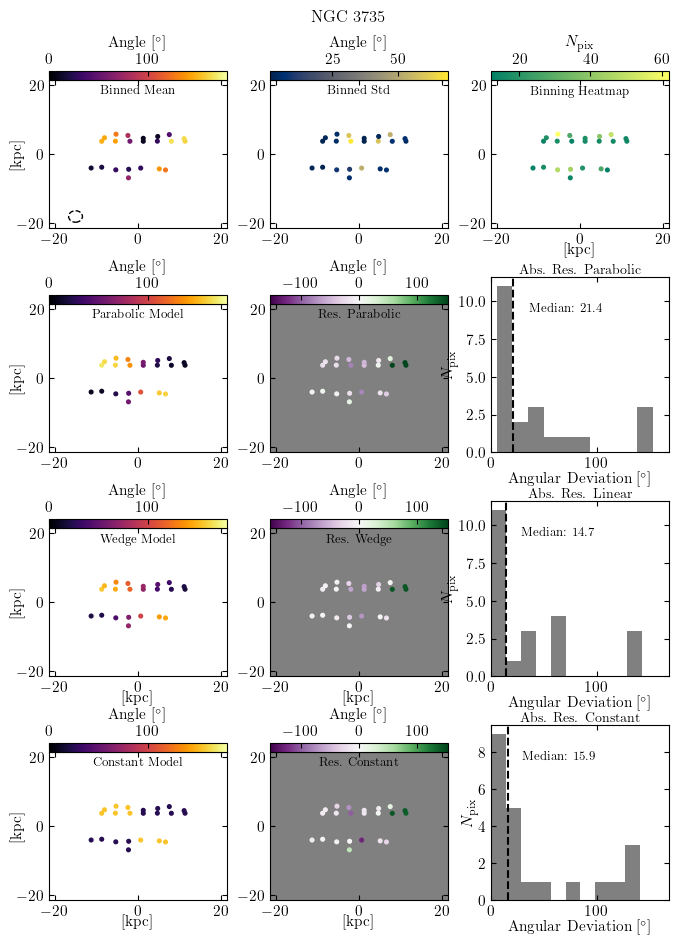

In [20]:
res_n3735, res_n3735_lin, res_n3735_const, q_n3735, med_dev_a_n3735, med_dev_b_n3735, med_dev_c_n3735, n_beam_fitted_n3735 = main_analysis(gal_indicator="n3735", dist_Mpc=42, pos_ang=129.7, gal_diam_kpc=34.4,
                        fits_path="fits_maps/n3735/N3735_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('11h35m57.3000s+70d32m08.100s'),
                        cut_size=900*u.arcsec, lim_axes=15, scale=30)

## NGC4157

### Standard Setup

Filename: fits_maps/n4157/N4157_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.348567201989987e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 15.902115821838 arcsec
Beam Minor axis (FWHM)[arcsec]: 14.990173339841999 arcsec
Beam area [arcsec^2]: 270.1008727452305 arcsec2
N pixels per Beam: 67.5
Data contains 1194 not-NAN pixels
Beam Major axis [kpc]: 1.202691876802121
Correct polarisation angle for galaxy pos. ang:
Prior to rotati

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 1194
Number of cells after spatial average: 31
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 31
    # variables        = 1
    chi-square         = 4008.40228
    reduced chi-square = 133.613409
    Akaike info crit   = 152.726985
    Bayesian info crit = 154.160972
    R-squared          = 0.92869033
[[Variables]]
    a:  0.00223232 +/- 0.00364738 (163.39%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 31
    # variables        = 1
    chi-square         = 3880.72381
    reduced chi-square = 129.357460
    Akaike info crit   = 151.723483
    Baye

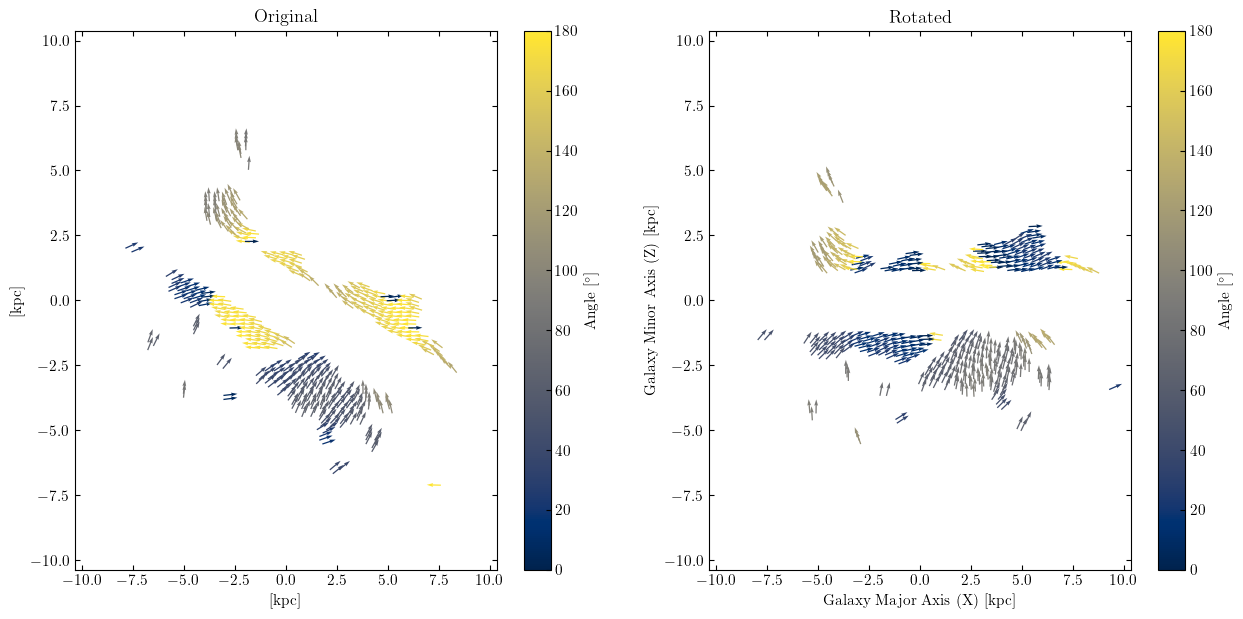

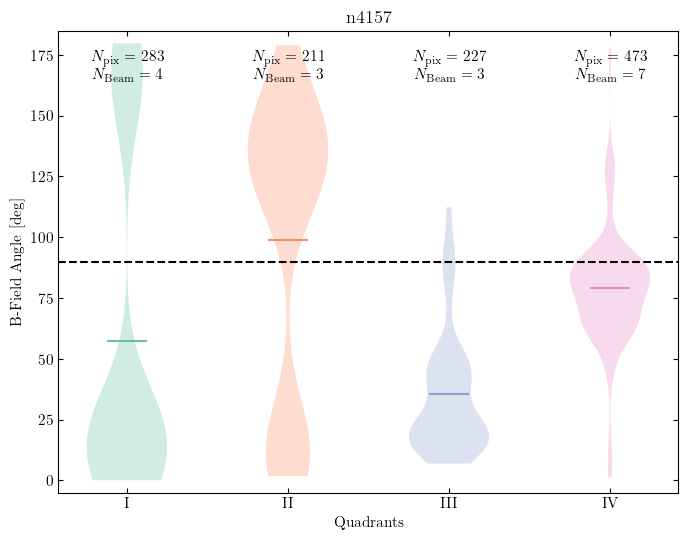

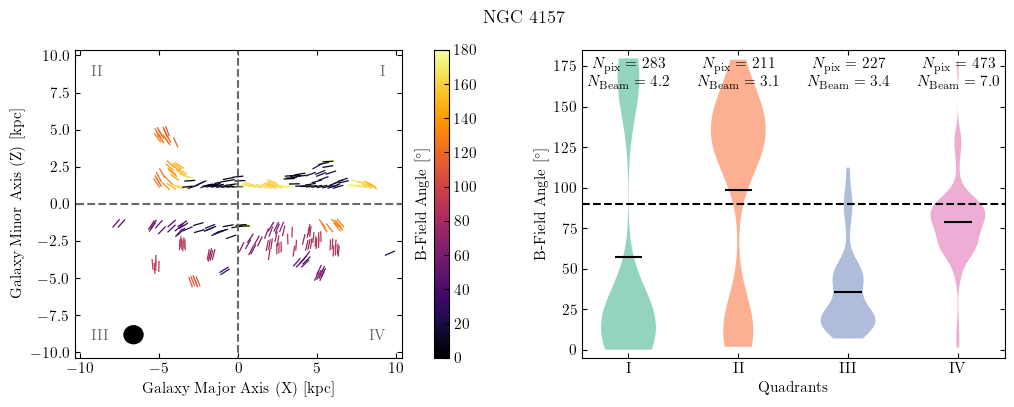

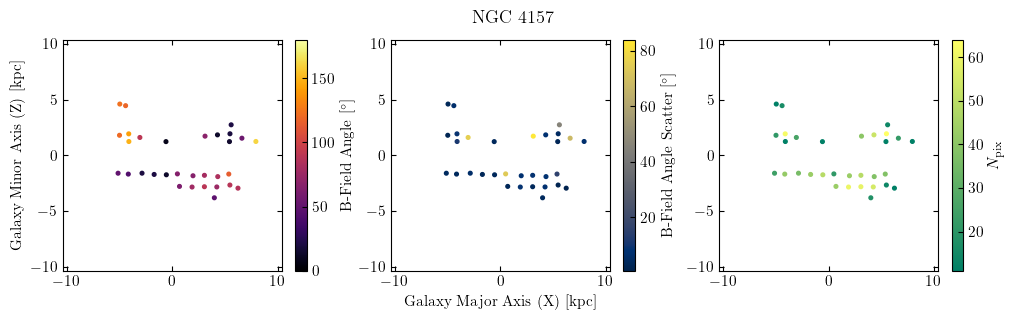

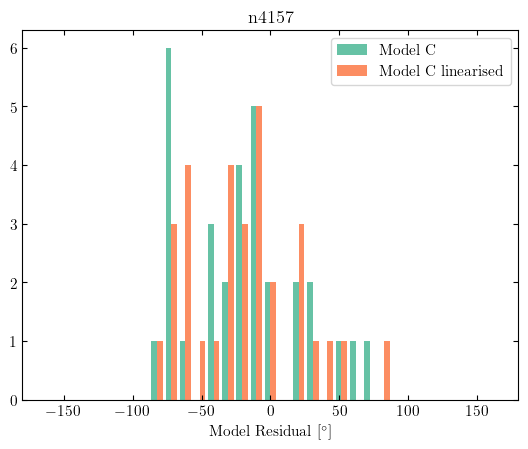

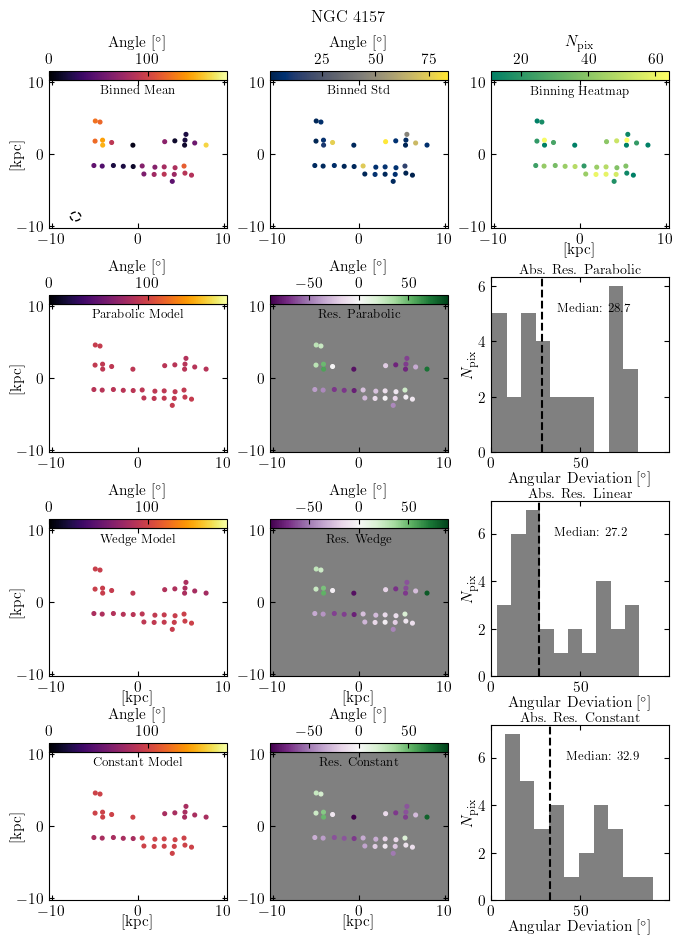

In [21]:
q_n4157 = main_analysis(gal_indicator="n4157", dist_Mpc=15.6, pos_ang=64.7, gal_diam_kpc=16.6,
                        fits_path="fits_maps/n4157/N4157_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('12h11m04.3700s+50d29m04.800s'),
                        cut_size=400*u.arcsec, lim_axes=15, scale=30)

### Masked Q4

Filename: fits_maps/n4157/N4157_D_C_Uvtap_X_final_plus_q4_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.348567201989987e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 15.902115821838 arcsec
Beam Minor axis (FWHM)[arcsec]: 14.990173339841999 arcsec
Beam area [arcsec^2]: 270.1008727452305 arcsec2
N pixels per Beam: 67.5
Data contains 715 not-NAN pixels
Beam Major axis [kpc]: 1.202691876802121
Correct polarisation angle for galaxy pos. ang:
Prior to

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/home/mstein/anaconda3/envs/py_mayavi/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1026: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/home/mstein/anaconda3/envs/py_mayavi/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mstein/anaconda3/envs/py_mayavi/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, 

Number of pixels before spatial average: 715
Number of cells after spatial average: 19
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 19
    # variables        = 1
    chi-square         = 2049.33253
    reduced chi-square = 113.851807
    Akaike info crit   = 90.9357784
    Bayesian info crit = 91.8802174
    R-squared          = 0.96056582
[[Variables]]
    a:  0.10703619 +/- 0.06061815 (56.63%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 19
    # variables        = 1
    chi-square         = 1983.13620
    reduced chi-square = 110.174234
    Akaike info crit   = 90.3119208
    Bayesi

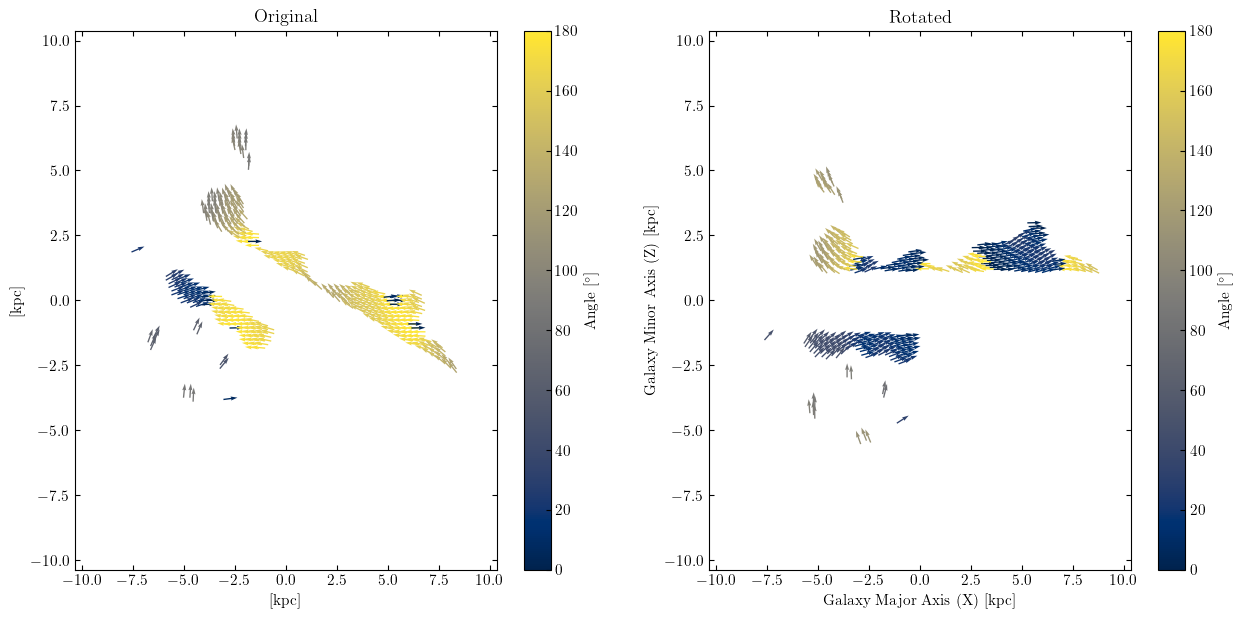

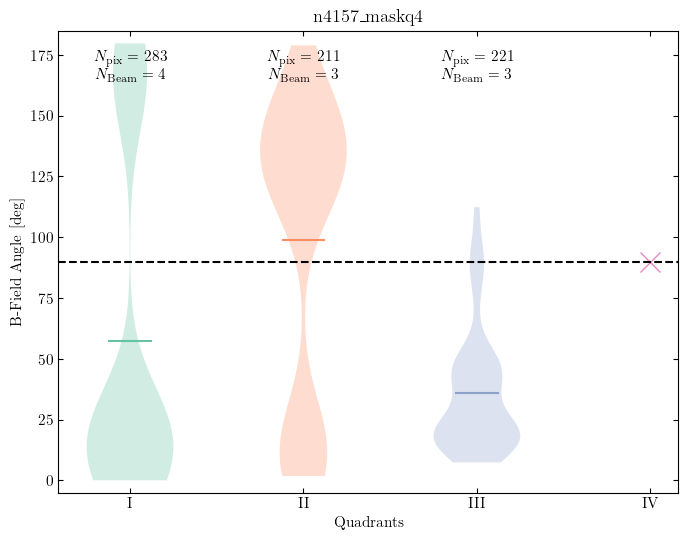

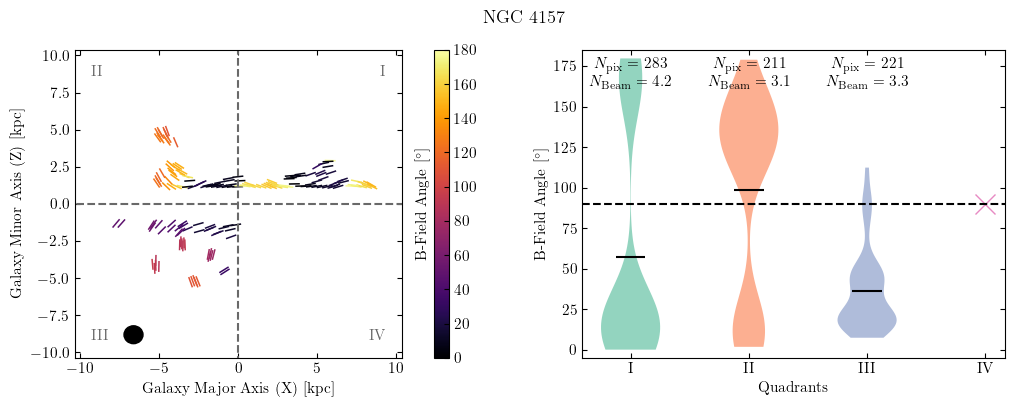

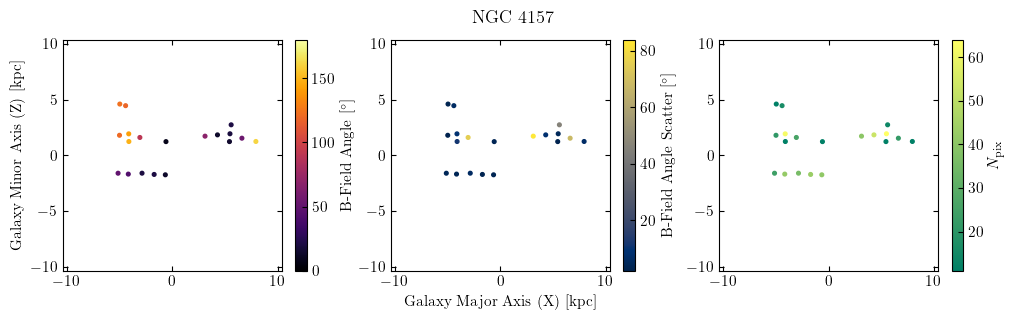

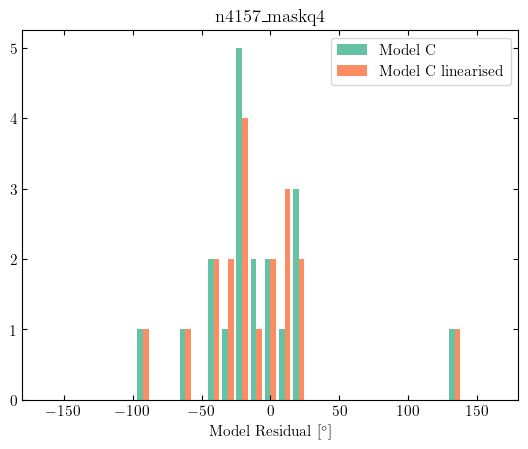

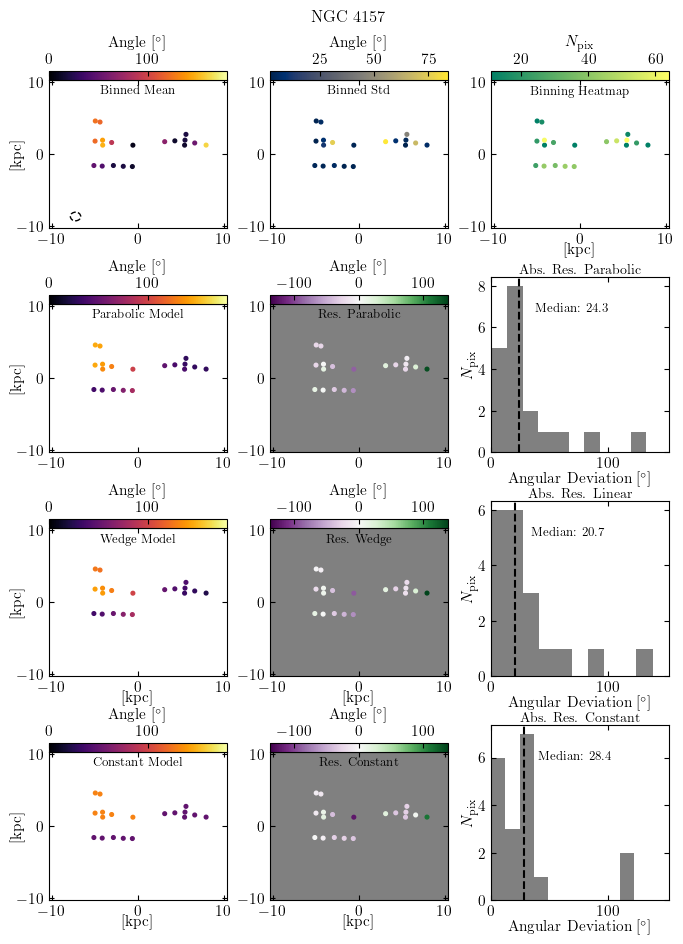

In [22]:
res_n4157_maskq4, res_n4157_maskq4_lin, res_n4157_maskq4_const, q_n4157_maskq4, med_dev_a_n4157_maskq4, med_dev_b_n4157_maskq4, med_dev_c_n4157_maskq4, n_beam_fitted_n4157_maskq4 = main_analysis(gal_indicator="n4157_maskq4", dist_Mpc=15.6, pos_ang=64.7, gal_diam_kpc=16.6,
                        fits_path="fits_maps/n4157/N4157_D_C_Uvtap_X_final_plus_q4_masked.FITS",
                        cut_pos=SkyCoord('12h11m04.3700s+50d29m04.800s'),
                        cut_size=400*u.arcsec, lim_axes=15, scale=30)

## NGC4192

Filename: fits_maps/n4192/N4192_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.259144308168493e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 15.662011146544799 arcsec
Beam Minor axis (FWHM)[arcsec]: 15.0055971145632 arcsec
Beam area [arcsec^2]: 266.29636049922027 arcsec2
N pixels per Beam: 66.6
Data contains 1185 not-NAN pixels
Beam Major axis [kpc]: 1.0288728116003276
Correct polarisation angle for galaxy pos. ang:
Prior to rot

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


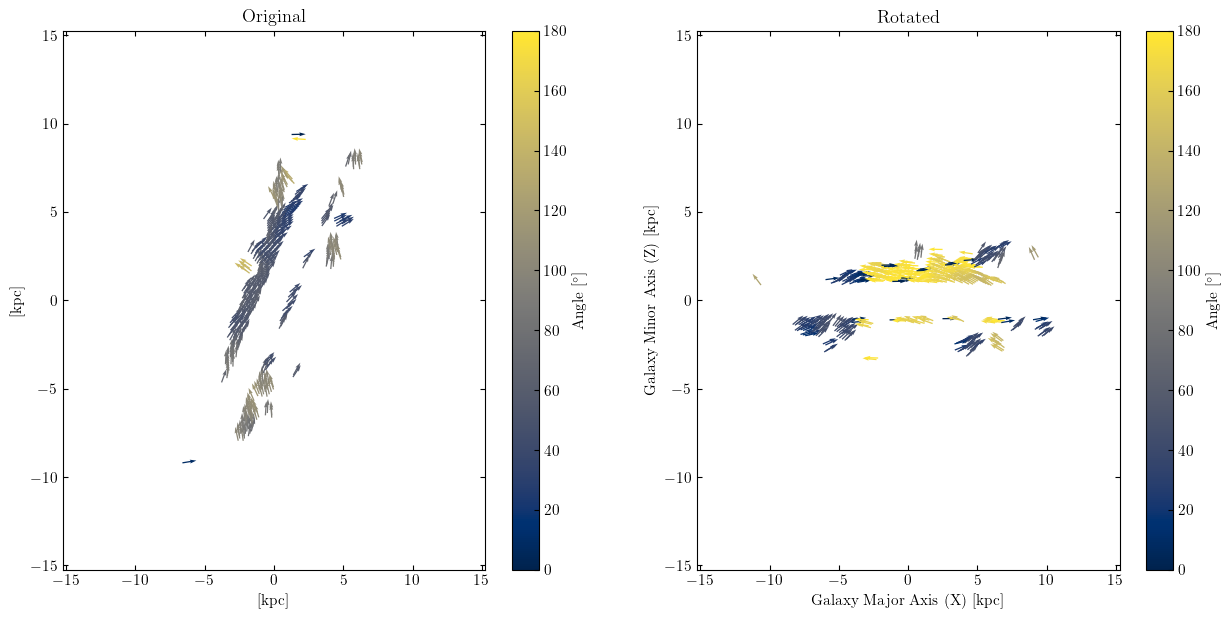

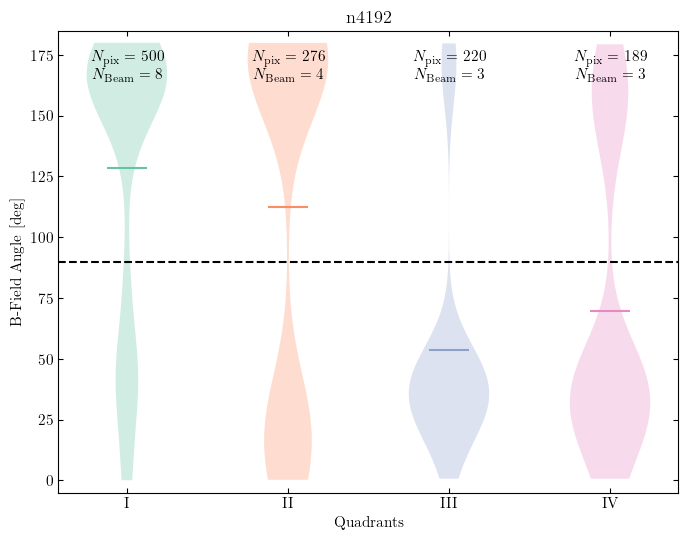

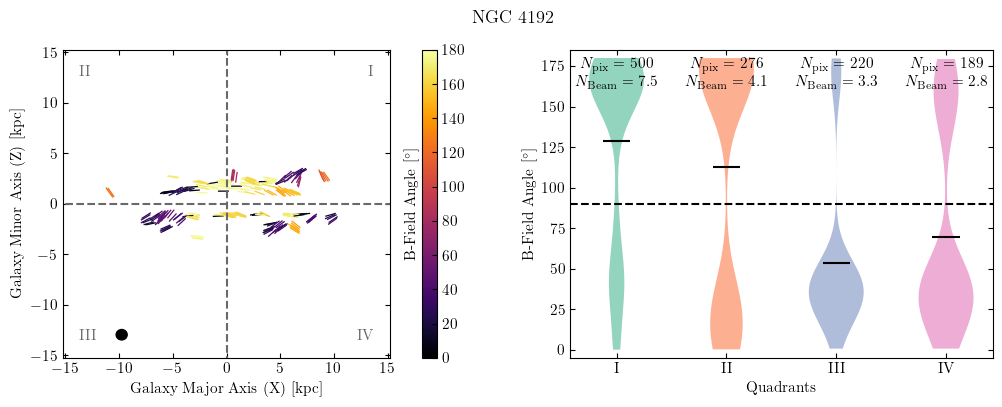

In [23]:
q_n4192 = main_analysis(gal_indicator="n4192", dist_Mpc=13.55, pos_ang=152.4, gal_diam_kpc=24.4,
                        fits_path="fits_maps/n4192/N4192_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('12h13m48.2850s+14d54m01.203s'),
                        cut_size=450*u.arcsec, lim_axes=15, scale=30, fit_x=False, fit_x_norm=False)

## NGC4217

Filename: fits_maps/n4217/N4217_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.516044230227218e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 16.063785552978 arcsec
Beam Minor axis (FWHM)[arcsec]: 15.230773925780401 arcsec
Beam area [arcsec^2]: 277.22621143227695 arcsec2
N pixels per Beam: 69.3
Data contains 870 not-NAN pixels
Beam Major axis [kpc]: 1.6043162601485257
Correct polarisation angle for galaxy pos. ang:
Prior to rotat

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 870
Number of cells after spatial average: 26
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 26
    # variables        = 1
    chi-square         = 1935.73058
    reduced chi-square = 77.4292232
    Akaike info crit   = 114.063732
    Bayesian info crit = 115.321829
    R-squared          = 0.94733587
[[Variables]]
    a:  0.02000496 +/- 0.00446500 (22.32%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 26
    # variables        = 1
    chi-square         = 1214.09068
    reduced chi-square = 48.5636272
    Akaike info crit   = 101.935007
    Bayesi

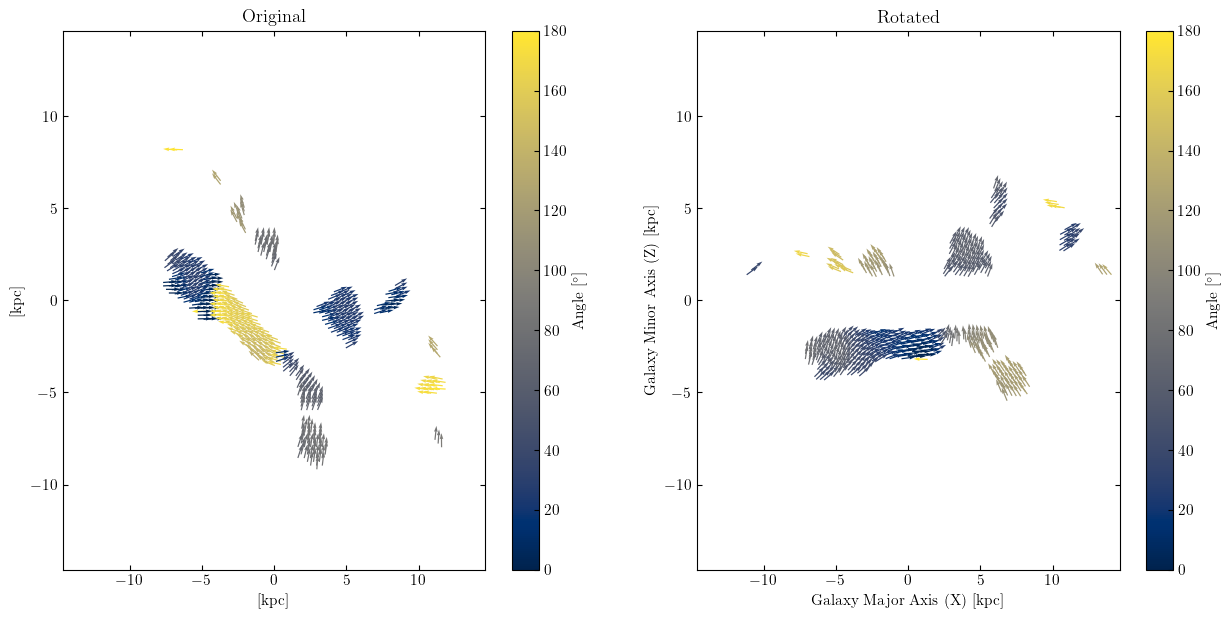

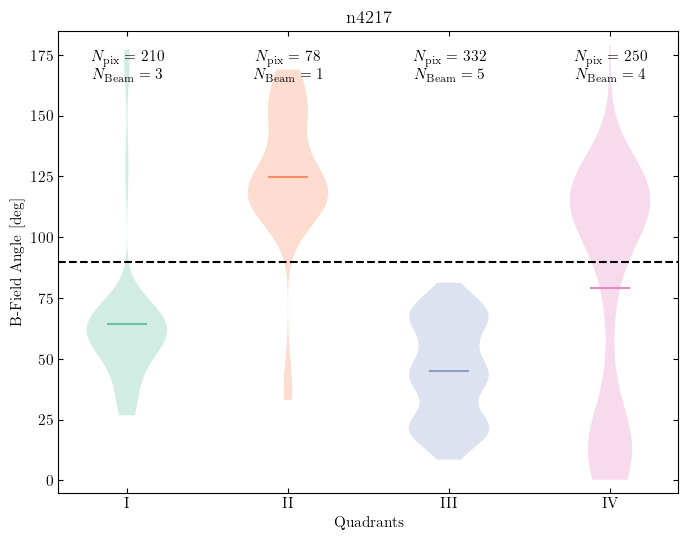

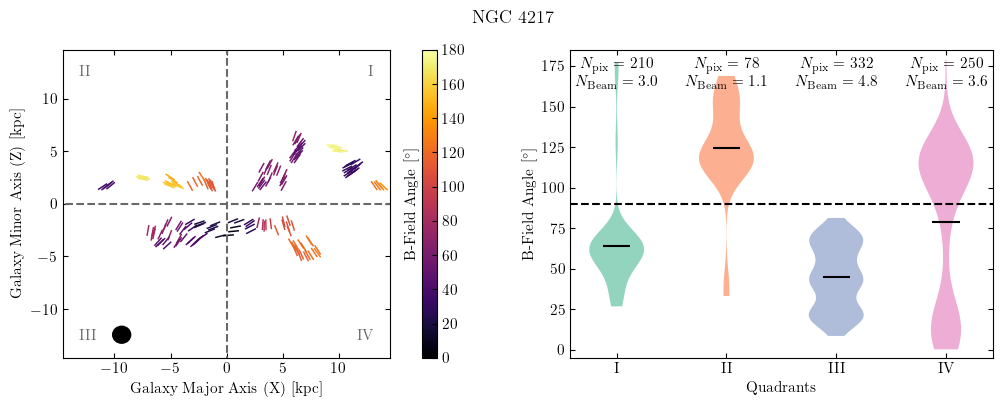

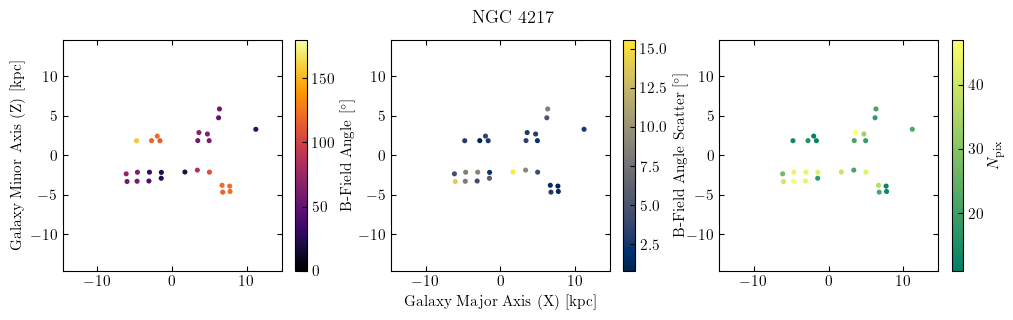

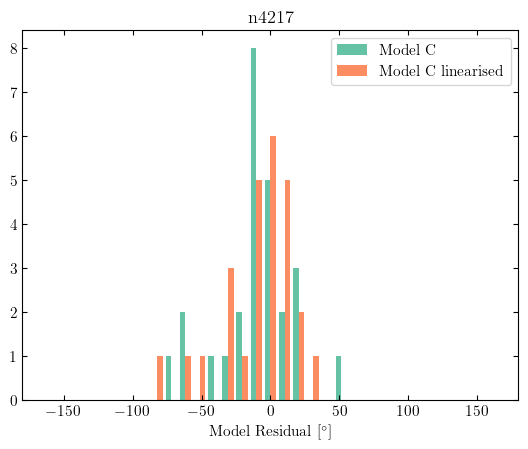

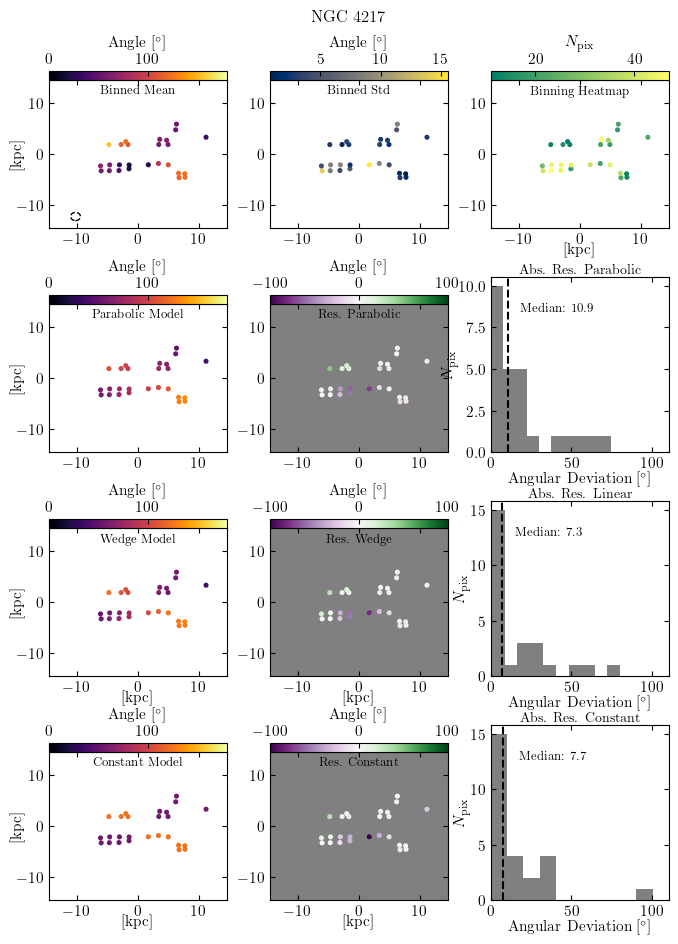

In [24]:
res_n4217, res_n4217_lin, res_n4217_const, q_n4217, med_dev_a_n4217, med_dev_b_n4217, med_dev_c_n4217, n_beam_fitted_n4217 = main_analysis(gal_indicator="n4217", dist_Mpc=20.6, pos_ang=49.8, gal_diam_kpc=23.4,
                        fits_path="fits_maps/n4217/N4217_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('12h15m50.9000s+47d05m30.400s'),
                        cut_size=400*u.arcsec, lim_axes=15, scale=30)

## NGC4565

Filename: fits_maps/n4565/N4565_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   (451, 451)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (451, 451),
Image dimensions: [451, 451],
Radio Beam object: 6.304111851424942e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 15.963904380801598 arcsec
Beam Minor axis (FWHM)[arcsec]: 14.827592372900401 arcsec
Beam area [arcsec^2]: 268.20951228486547 arcsec2
N pixels per Beam: 67.1
Data contains 1291 not-NAN pixels
Beam Major axis [kpc]: 0.9210027909404466
Correct polarisation angle for galaxy pos. ang:
Prior to r

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


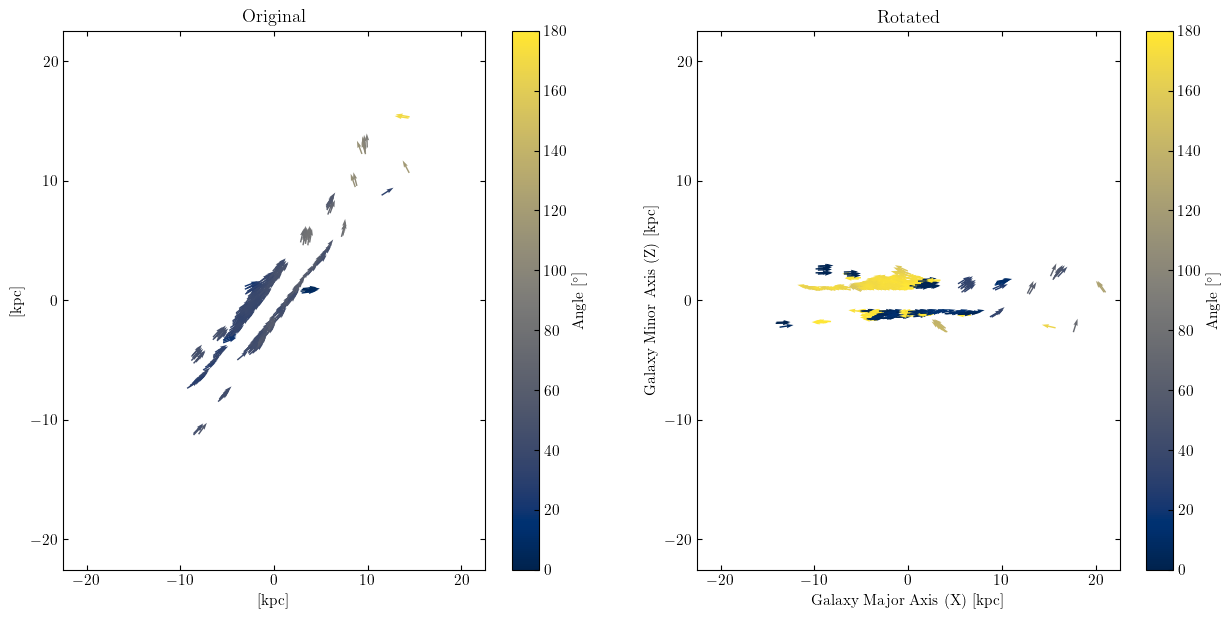

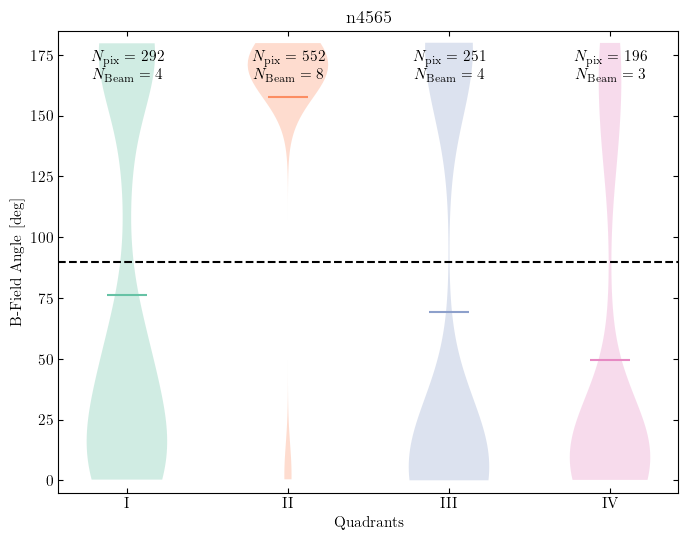

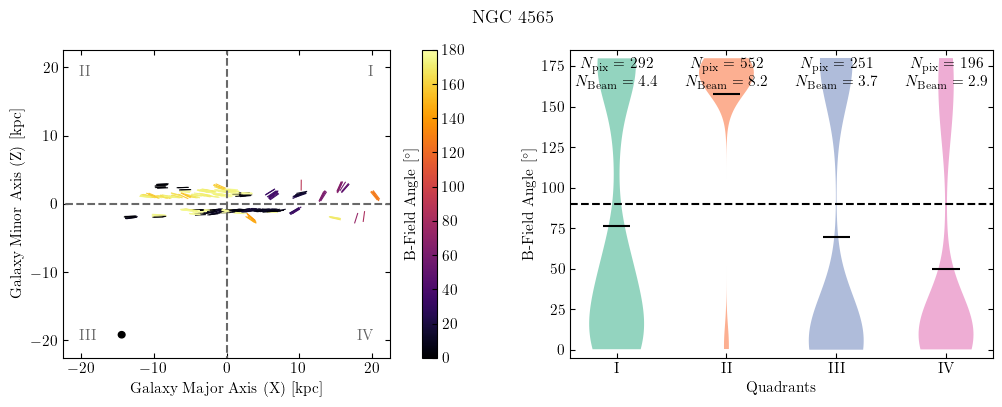

In [25]:
q_n4565 = main_analysis(gal_indicator="n4565", dist_Mpc=11.9, pos_ang=135.2, gal_diam_kpc=36.1,
                        fits_path="fits_maps/n4565/N4565_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('12h36m20.7802s+25d59m15.629s'),
                        cut_size=900*u.arcsec, lim_axes=15, scale=30, fit_x=False, fit_x_norm=False)

## NGC4631

Filename: fits_maps/n4631/N4631_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   (361, 361)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (361, 361),
Image dimensions: [361, 361],
Radio Beam object: 6.15019339933833e-09 sr,
Pixel dimensions [deg, deg]: [-0.0006944444444444, 0.0006944444444444],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2.5 arcsec>, <Quantity 2.5 arcsec>)
Pixel area [arcsec^2]: 6.249999999999201 arcsec2
Beam Major axis (FWHM) [arcsec]: 15.7142992020012 arcsec
Beam Minor axis (FWHM)[arcsec]: 14.695338726100799 arcsec
Beam area [arcsec^2]: 261.6610255291205 arcsec2
N pixels per Beam: 41.9
Data contains 3504 not-NAN pixels
Beam Major axis [kpc]: 0.5637695361939188
Correct polarisation angle for galaxy pos. ang:
Prior to rota

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 3504
Number of cells after spatial average: 105
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 105
    # variables        = 1
    chi-square         = 24249.0746
    reduced chi-square = 233.164179
    Akaike info crit   = 573.428205
    Bayesian info crit = 576.082166
    R-squared          = 0.87126672
[[Variables]]
    a:  0.14284165 +/- 0.01445417 (10.12%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 105
    # variables        = 1
    chi-square         = 27171.3202
    reduced chi-square = 261.262694
    Akaike info crit   = 585.375479
    Ba

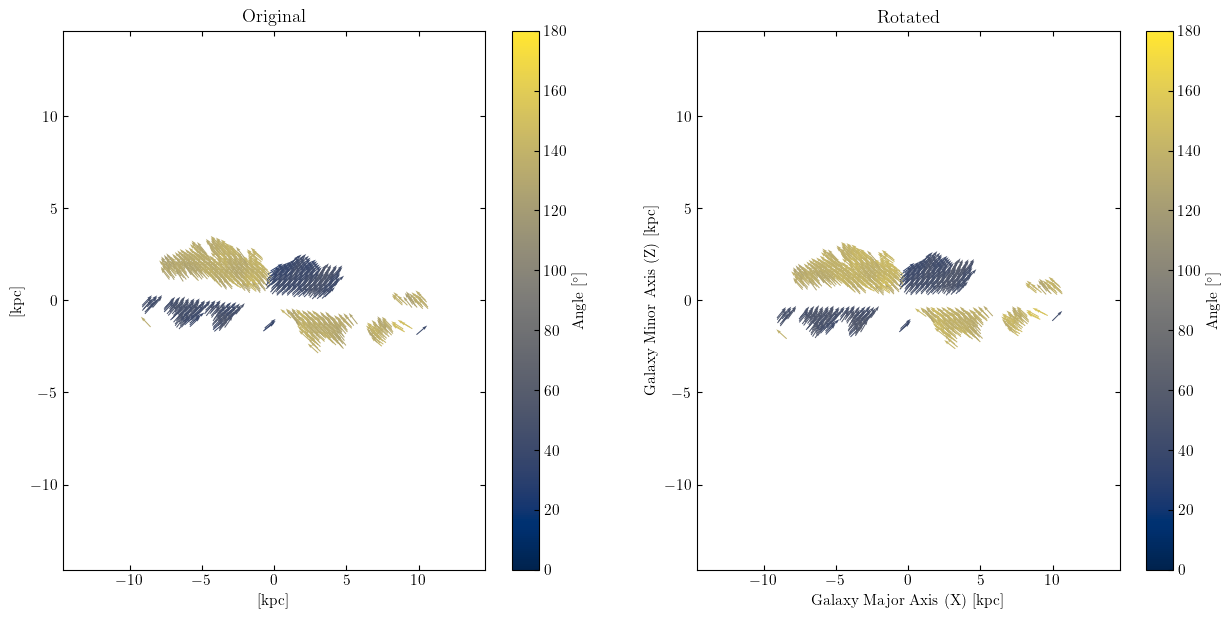

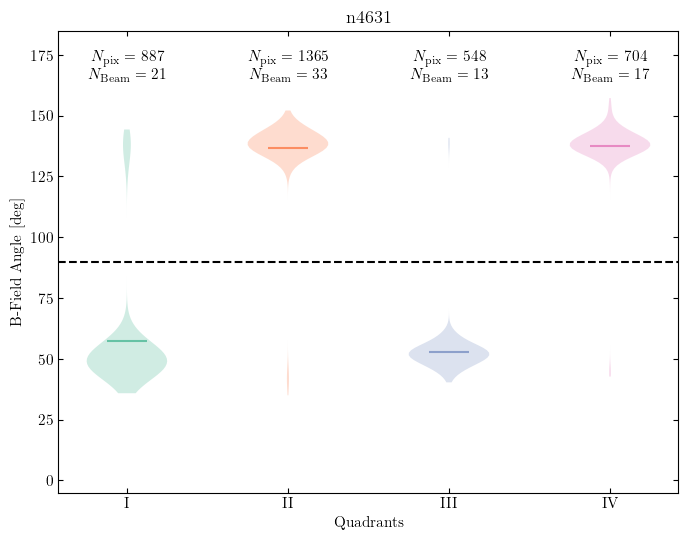

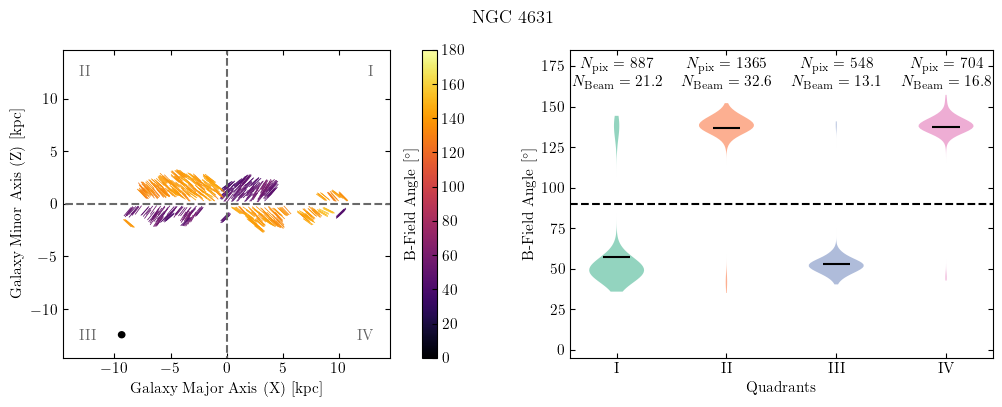

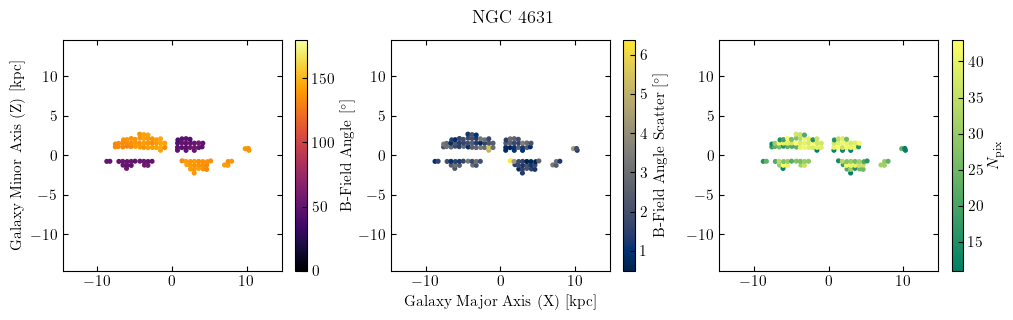

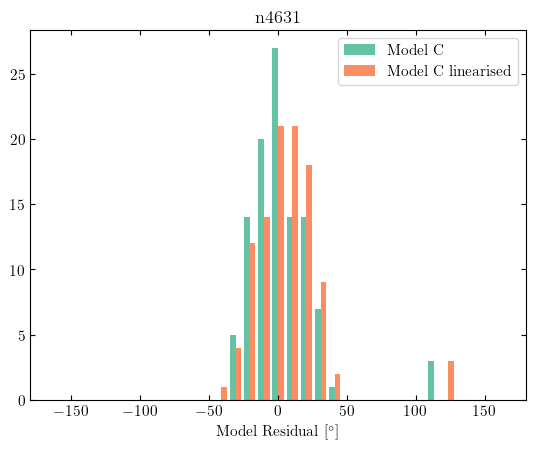

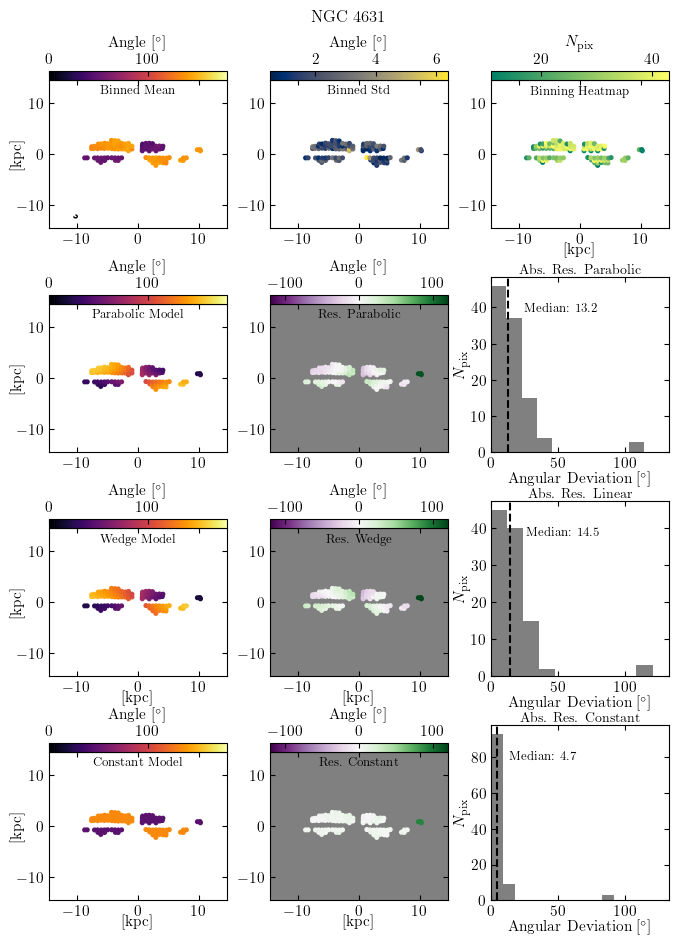

In [26]:
res_n4631, res_n4631_lin, res_n4631_const, q_n4631, med_dev_a_n4631, med_dev_b_n4631,  med_dev_c_n4631, n_beam_fitted_n4631, df_n4631 = main_analysis(gal_indicator="n4631", dist_Mpc=7.4, pos_ang=85.7, gal_diam_kpc=23.4,
                        fits_path="fits_maps/n4631/N4631_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('12h42m08.0100s+32d32m29.400s'),
                        cut_size=600*u.arcsec, lim_axes=15, scale=30, n_arrows=750, return_df=True)

x_avg     z_avg  Polarisation_Angle_avg  Polarisation_Angle_std  \
6  -7.590621  1.068233              134.467636                2.148010   
7  -7.580441  1.431271              130.910843                3.354461   
10 -7.200367  1.104963              134.060547                3.109400   
11 -7.171458  1.514490              134.795547                2.951598   
15 -6.586633  1.058007              132.360168                2.724321   
16 -6.618914  1.551283              134.972107                0.840569   
17 -6.491730  1.964350              136.309769                1.396562   
21 -6.023512  1.160080              130.394455                1.736331   
22 -6.026046  1.552644              133.637360                2.291041   
23 -6.028705  1.984647              137.928070                0.841258   
27 -5.498880  1.099938              134.838226                1.502715   
28 -5.478280  1.546091              135.900223                1.416584   
29 -5.467064  2.133052              138.444534                1.683583   
34 -4.903726  1.134632              139.789810                2.893933   
35 -4.921515  1.569816              139.823425                1.597761   
36 -4.956783  2.017725              138.741394                1.926589   
38 -4.290646  1.059247              139.512466                0.842466   
39 -4.362436  1.546163              139.198349                1.932410   
40 -4.304515  2.178110              138.880630                1.749552   
41 -4.334146  2.681151              137.287567                1.181294   
46 -3.784091  1.012911              136.997437                2.553585   
47 -3.775869  1.550469              140.904663                2.431849   
48 -3.784806  2.135963              143.873001                1.987865   
49 -3.785023  2.623583              142.536789                2.166499   
54 -3.226055  0.979350              141.641022                2.735420   
55 -3.220111  1.556753              137.864059                1.349229   
56 -3.214167  2.134156              139.691498                1.397392   
57 -3.225733  2.571409              142.972565                0.949327   
61 -2.636986  0.994055              140.652740                3.396463   
62 -2.664352  1.563036              135.158615                0.780881   
63 -2.662077  2.094555              137.591232                3.261381   
67 -2.107071  0.982434              142.266144                2.942510   
68 -2.085167  1.554238              139.864807                1.460040   
69 -2.090569  1.965481              141.318634                3.054799   
70 -1.552911  0.643669              142.224869                5.024302   
71 -1.530890  1.011437              145.687820                5.565297   
72 -1.518706  1.543689              143.538773                2.225524   
73 -1.544157  2.095010              144.322418                1.701664   
76 -0.980407  0.984851              133.986786                3.018973   
77 -0.976389  1.540710              142.353348                2.445450   

    num_values  
6           18  
7           12  
10          23  
11          30  
15          26  
16          41  
17          15  
21          15  
22          40  
23          19  
27          23  
28          39  
29          42  
34          21  
35          37  
36          26  
38          22  
39          43  
40          27  
41          37  
46          40  
47          38  
48          34  
49          36  
54          41  
55          40  
56          41  
57          21  
61          39  
62          38  
63          39  
67          38  
68          43  
69          15  
70          11  
71          40  
72          37  
73          36  
76          39  
77          37

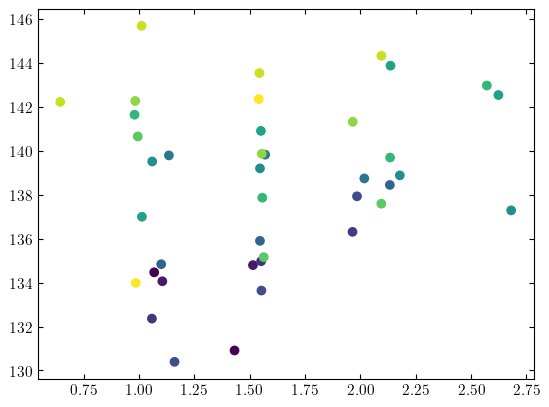

In [27]:
q1 = df_n4631.loc[(df_n4631['x_avg'] > 0) & (df_n4631['z_avg'] > 0)]
q2 = df_n4631.loc[(df_n4631['x_avg'] < 0) & (df_n4631['z_avg'] > 0)]

display(q2)

fig, ax = plt.subplots()
ax.scatter(x=np.abs(q2['z_avg']), y=q2['Polarisation_Angle_avg'],
           c=q2['x_avg'])

## NGC4666

Filename: fits_maps/n4666/N4666_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 5.083590586380925e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 14.096320152281999 arcsec
Beam Minor axis (FWHM)[arcsec]: 13.540997505189601 arcsec
Beam area [arcsec^2]: 216.2822272134927 arcsec2
N pixels per Beam: 54.1
Data contains 1583 not-NAN pixels
Beam Major axis [kpc]: 1.8793744380912167
Correct polarisation angle for galaxy pos. ang:
Prior to ro

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 1583
Number of cells after spatial average: 37
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 37
    # variables        = 1
    chi-square         = 1826.00545
    reduced chi-square = 50.7223737
    Akaike info crit   = 146.261821
    Bayesian info crit = 147.872739
    R-squared          = 0.93604785
[[Variables]]
    a:  7.2412e-04 +/- 0.00145977 (201.59%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 18
    # data points      = 37
    # variables        = 1
    chi-square         = 1838.80727
    reduced chi-square = 51.0779798
    Akaike info crit   = 146.520317
    Baye

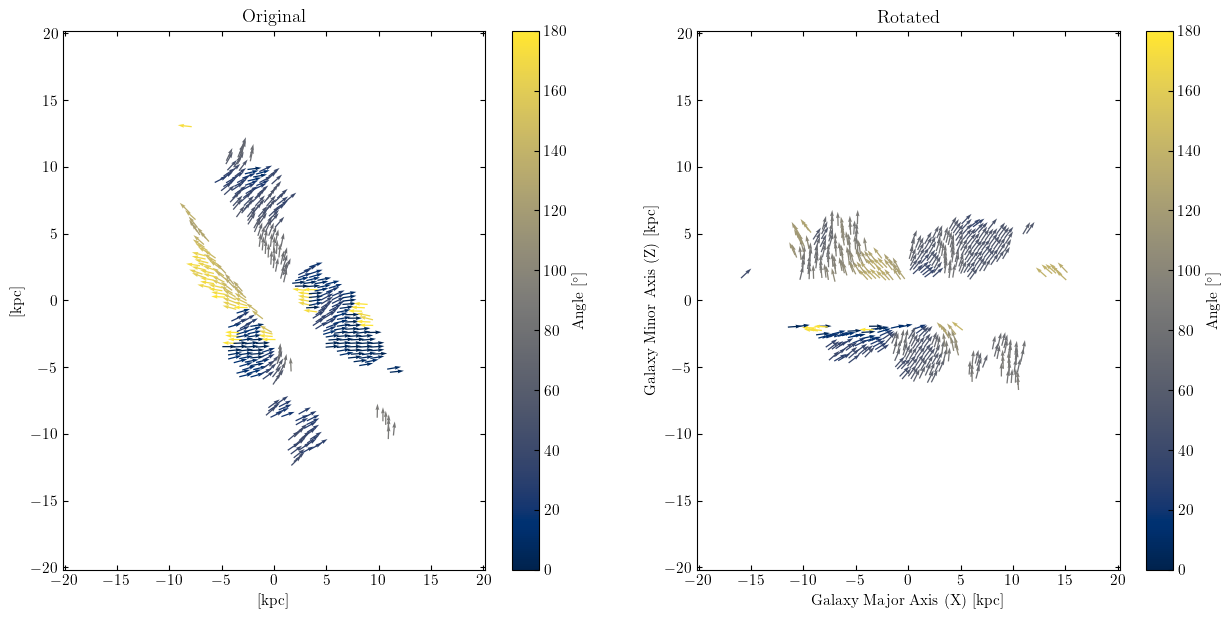

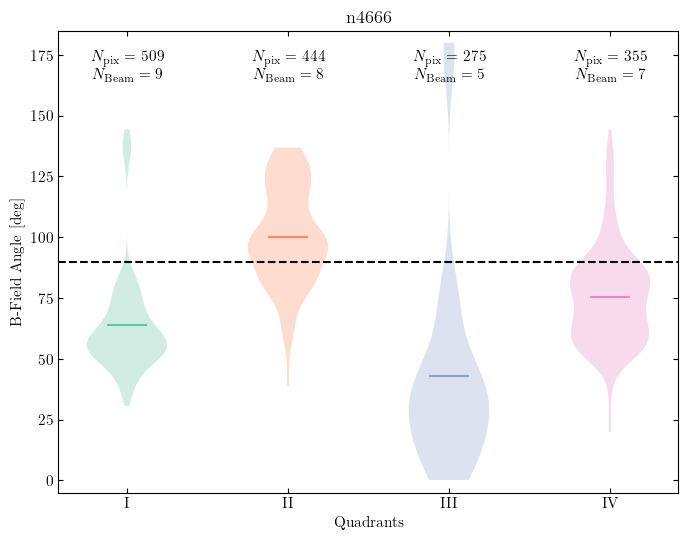

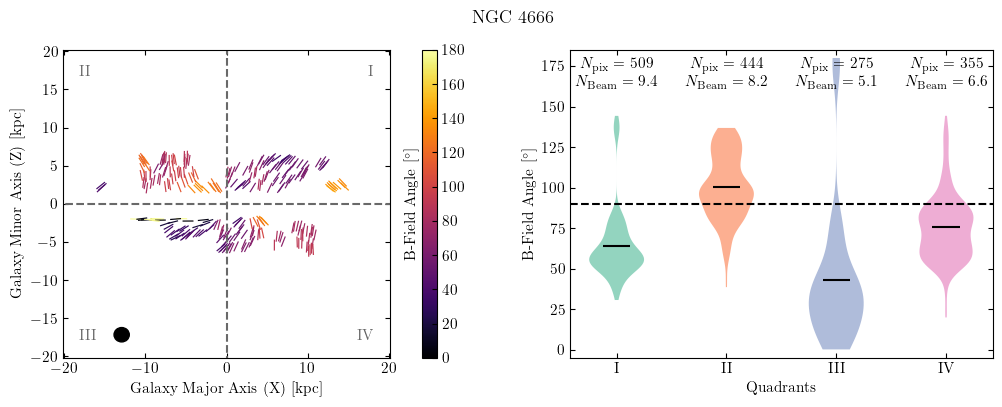

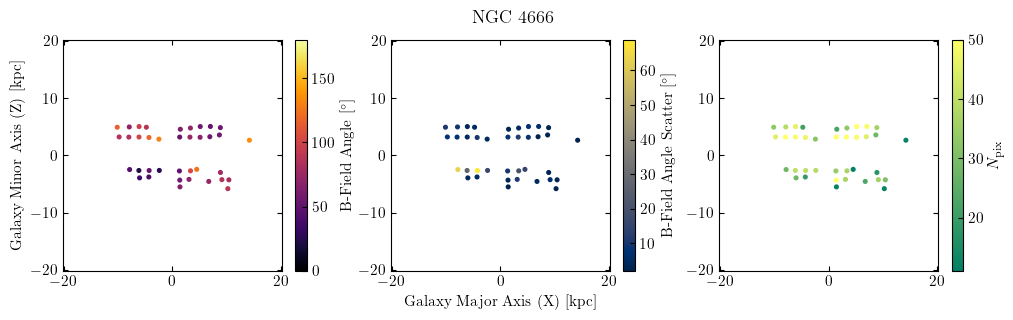

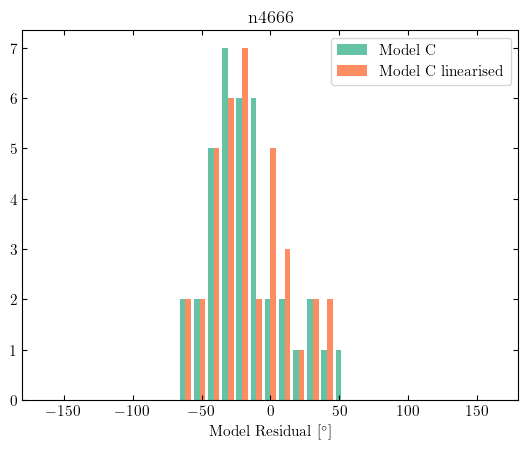

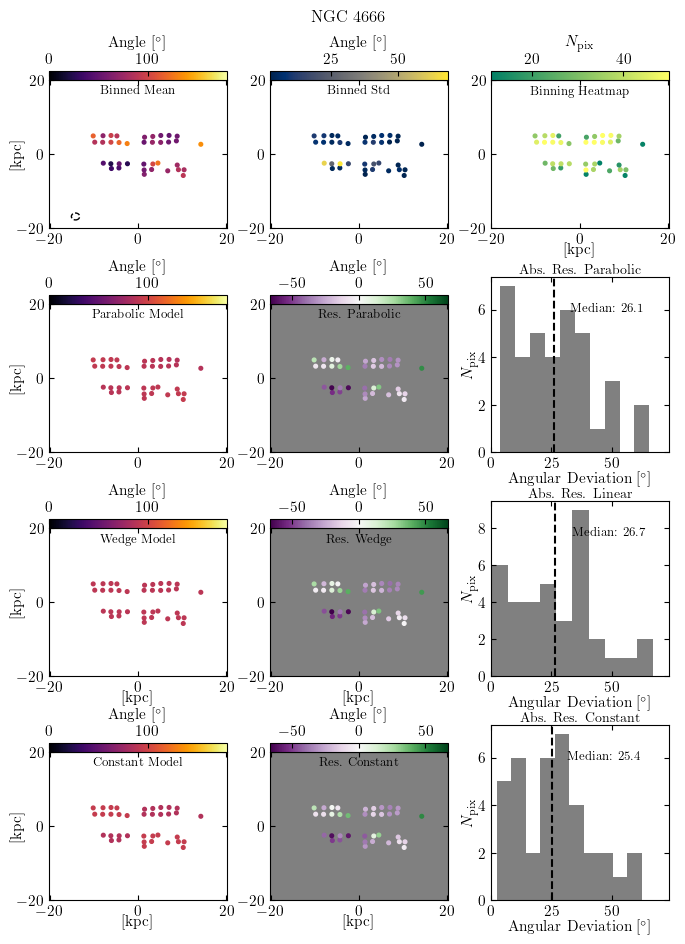

In [28]:
res_n4666, res_n4666_lin, res_n4666_const, q_n4666, med_dev_a_n4666, med_dev_b_n4666,  med_dev_c_n4666, n_beam_fitted_n4666 = main_analysis(gal_indicator="n4666", dist_Mpc=27.5, pos_ang=40.6, gal_diam_kpc=32.3,
                        fits_path="fits_maps/n4666/N4666_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('12h45m08.5914s-00d27m42.786s'),
                        cut_size=400*u.arcsec, lim_axes=15, scale=30)

## NGC5775

Filename: fits_maps/n5775/N5775_D_C_Uvtap_X_final_masked.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (339, 339)   float32   
------------
Load Fits Map summary:
Flattened data array shape: (339, 339),
Image dimensions: [339, 339],
Radio Beam object: 6.3867159620028705e-09 sr,
Pixel dimensions [deg, deg]: [-0.0005555555555556, 0.0005555555555556],
Fits Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BMAJ', 'BMIN', 'BPA', 'BTYPE', 'OBJECT'] (first 10 keys)
------------

Pixel dimensions [arcsec]: (<Quantity -2. arcsec>, <Quantity 2. arcsec>)
Pixel area [arcsec^2]: 4.0000000000006395 arcsec2
Beam Major axis (FWHM) [arcsec]: 16.1394691467276 arcsec
Beam Minor axis (FWHM)[arcsec]: 14.858473777772401 arcsec
Beam area [arcsec^2]: 271.7239182365656 arcsec2
N pixels per Beam: 67.9
Data contains 1542 not-NAN pixels
Beam Major axis [kpc]: 2.261319645677413
Correct polarisation angle for galaxy pos. ang:
Prior to rota

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of pixels before spatial average: 1542
Number of cells after spatial average: 36
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 36
    # variables        = 1
    chi-square         = 713.232903
    reduced chi-square = 20.3780829
    Akaike info crit   = 109.506407
    Bayesian info crit = 111.089926
    R-squared          = 0.98860067
[[Variables]]
    a:  0.01008693 +/- 0.00223002 (22.11%) (init = 0.01)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b      0.01        0    1e+04     None     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 36
    # variables        = 1
    chi-square         = 708.405356
    reduced chi-square = 20.2401530
    Akaike info crit   = 109.261911
    Bayesi

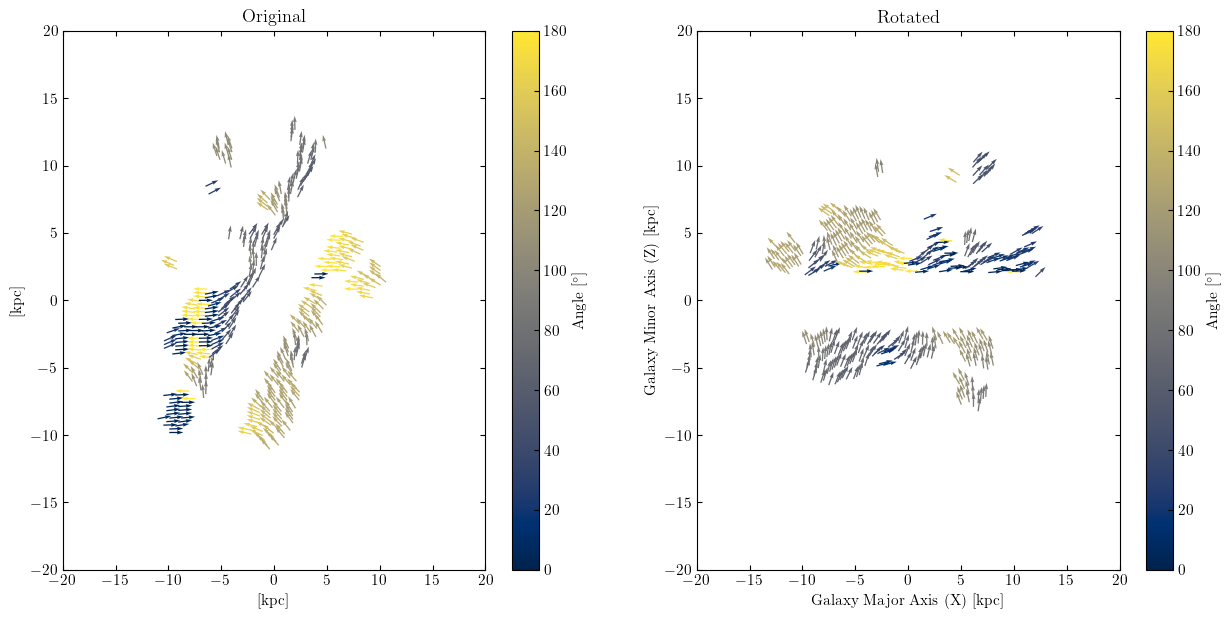

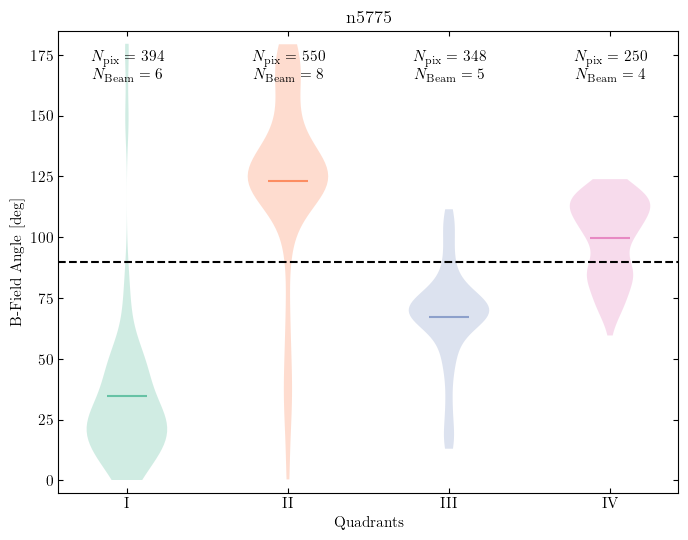

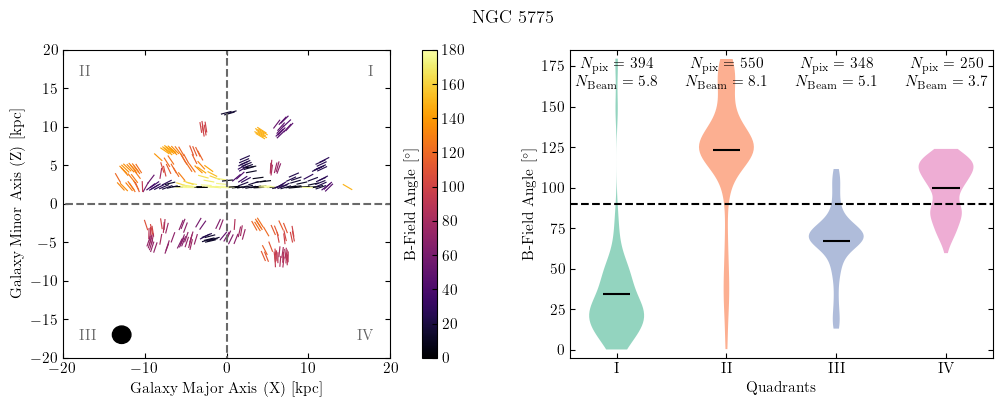

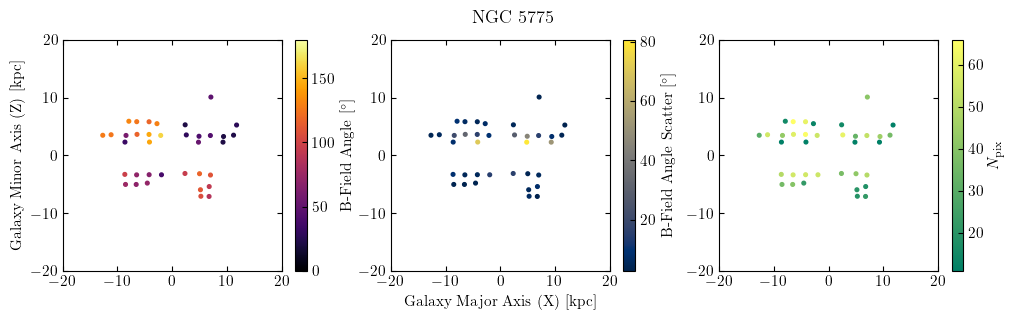

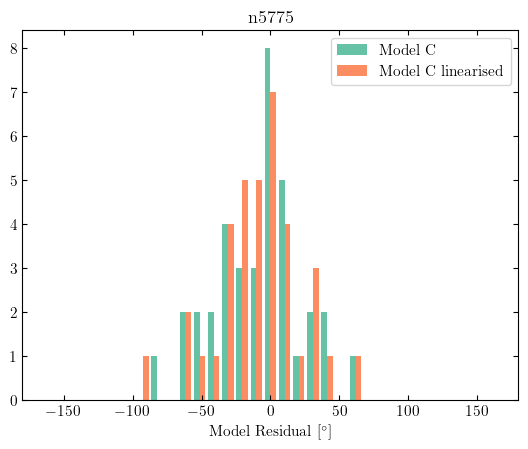

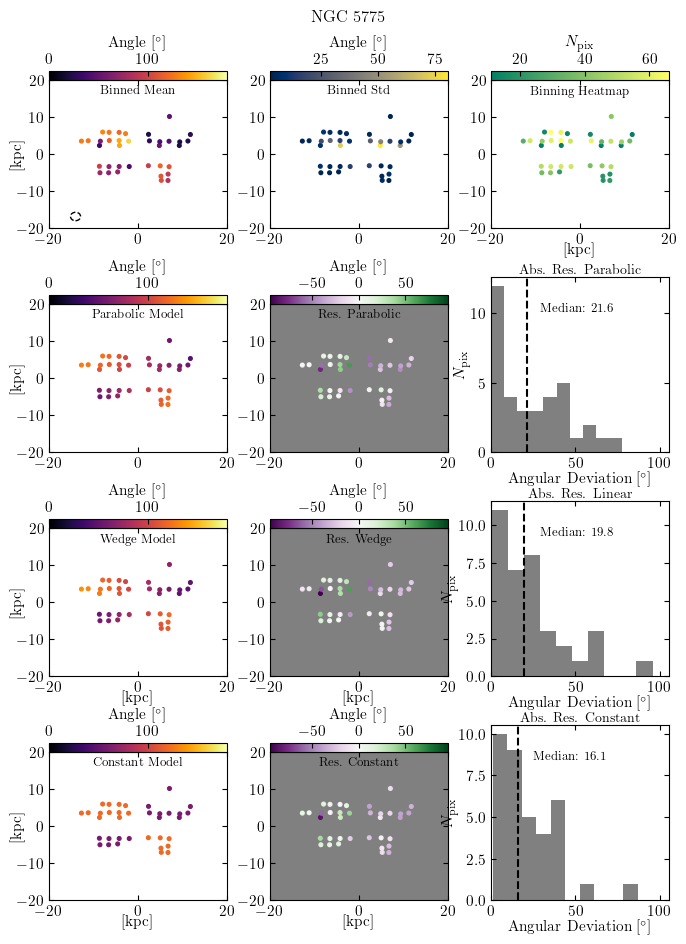

In [29]:
res_n5775, res_n5775_lin, res_n5775_const, q_n5775, med_dev_a_n5775, med_dev_b_n5775, med_dev_c_n5775, n_beam_fitted_n5775 = main_analysis(gal_indicator="n5775", dist_Mpc=28.9, pos_ang=148.4, gal_diam_kpc=32,
                        fits_path="fits_maps/n5775/N5775_D_C_Uvtap_X_final_masked.FITS",
                        cut_pos=SkyCoord('14h53m57.5970s+03d32m40.050s'),
                        cut_size=400*u.arcsec, lim_axes=15, scale=30)

# Collect fit results

In [30]:
result_list = []
for r, name in zip([res_n891, res_n2820_masked_north, res_n3044, res_n3079_AGNmasked, res_n3448, res_n3735, res_n4157_maskq4, res_n4217, res_n4631, res_n4666, res_n5775],
                   ['NGC 891', 'NGC 2820', 'NGC 3044','NGC 3079',  'NGC 3448', 'NGC 3735','NGC 4157', 'NGC 4217', 'NGC 4631', 'NGC 4666', 'NGC 5775']):
    #print(r.params['a'].value, r.params['a'].stderr, r.aic, name)
    result_list.append([name, r.params['a'].value, r.params['a'].stderr, r.aic])
df_results = pd.DataFrame(result_list, columns=['Name', 'a', 'a_err', 'a_aic'])
df_results.to_csv('df_results.csv',index=None)

result_wedge_list = []

for r, name in zip([res_n891_lin, res_n2820_masked_north_lin, res_n3044_lin, res_n3079_AGNmasked_lin, res_n3448_lin, res_n3735_lin, res_n4157_maskq4_lin, res_n4217_lin, res_n4631_lin, res_n4666_lin, res_n5775_lin],
                   ['NGC 891', 'NGC 2820', 'NGC 3044','NGC 3079',  'NGC 3448', 'NGC 3735','NGC 4157', 'NGC 4217', 'NGC 4631', 'NGC 4666', 'NGC 5775']):
    #print(r.params['b'].value, r.params['b'].stderr, r.aic, name)
    result_wedge_list.append([name, r.params['b'].value, r.params['b'].stderr, r.aic])
df_results = pd.DataFrame(result_wedge_list, columns=['Name', 'b', 'b_err', 'b_aic'])
df_results.to_csv('df_results_lin.csv',index=None)

result_const_list = []

for r, name in zip([res_n891_const, res_n2820_masked_north_const, res_n3044_const, res_n3079_AGNmasked_const, res_n3448_const, res_n3735_const, res_n4157_maskq4_const, res_n4217_const, res_n4631_const, res_n4666_const, res_n5775_const],
                   ['NGC 891', 'NGC 2820', 'NGC 3044','NGC 3079',  'NGC 3448', 'NGC 3735','NGC 4157', 'NGC 4217', 'NGC 4631', 'NGC 4666', 'NGC 5775']):
    #print(r.params['b'].value, r.params['b'].stderr, r.aic, name)
    result_const_list.append([name, r.params['c'].value, r.params['c'].stderr, r.aic])
df_results = pd.DataFrame(result_const_list, columns=['Name', 'c', 'c_err', 'c_aic'])
df_results.to_csv('df_results_const.csv',index=None)


# result_norm_list = []
# for r, name in zip([res_n891_norm, res_n2820_masked_north_norm, res_n3044_norm, res_n3079_AGNmasked_norm, res_n3448_norm, res_n3735_norm, res_n4157_maskq4_norm, res_n4217_norm, res_n4631_norm, res_n4666_norm, res_n5775_norm],
#                    ['NGC 891', 'NGC 2820', 'NGC 3044','NGC 3079', 'NGC 3448',  'NGC 3735', 'NGC 4157', 'NGC 4217', 'NGC 4631', 'NGC 4666', 'NGC 5775']):
#     #print(r.params['a'].value, r.params['a'].stderr, name)
#     result_norm_list.append([name, r.params['a'].value, r.params['a'].stderr])
# df_results = pd.DataFrame(result_norm_list, columns=['Name', 'a_norm', 'a_norm_err'])
# df_results.to_csv('df_results_norm.csv',index=None)

result_med_dev_a_list= []
for med_dev, name in zip([med_dev_a_n891, med_dev_a_n2820_masked_north, med_dev_a_n3044, med_dev_a_n3079_ANGmasked, med_dev_a_n3448, med_dev_a_n3735, med_dev_a_n4157_maskq4, med_dev_a_n4217, med_dev_a_n4631, med_dev_a_n4666, med_dev_a_n5775],
                   ['NGC 891', 'NGC 2820', 'NGC 3044','NGC 3079',  'NGC 3448', 'NGC 3735','NGC 4157', 'NGC 4217', 'NGC 4631', 'NGC 4666', 'NGC 5775']):
    #print(r.params['a'].value, r.params['a'].stderr, r.aic, name)
    result_med_dev_a_list.append([name, med_dev])
df_results_med_dev_a = pd.DataFrame(result_med_dev_a_list, columns=['Name', 'med_dev_a'])

result_med_dev_b_list= []
for med_dev, name in zip([med_dev_b_n891, med_dev_b_n2820_masked_north, med_dev_b_n3044, med_dev_b_n3079_ANGmasked, med_dev_b_n3448, med_dev_b_n3735, med_dev_b_n4157_maskq4, med_dev_b_n4217, med_dev_b_n4631, med_dev_b_n4666, med_dev_b_n5775],
                   ['NGC 891', 'NGC 2820', 'NGC 3044','NGC 3079',  'NGC 3448', 'NGC 3735','NGC 4157', 'NGC 4217', 'NGC 4631', 'NGC 4666', 'NGC 5775']):
    #print(r.params['a'].value, r.params['a'].stderr, r.aic, name)
    result_med_dev_b_list.append([name, med_dev])
df_results_med_dev_b = pd.DataFrame(result_med_dev_b_list, columns=['Name', 'med_dev_b'])

result_med_dev_c_list= []
for med_dev, name in zip([med_dev_c_n891, med_dev_c_n2820_masked_north, med_dev_c_n3044, med_dev_c_n3079_ANGmasked, med_dev_c_n3448, med_dev_c_n3735, med_dev_c_n4157_maskq4, med_dev_c_n4217, med_dev_c_n4631, med_dev_c_n4666, med_dev_c_n5775],
                   ['NGC 891', 'NGC 2820', 'NGC 3044','NGC 3079',  'NGC 3448', 'NGC 3735','NGC 4157', 'NGC 4217', 'NGC 4631', 'NGC 4666', 'NGC 5775']):
    #print(r.params['a'].value, r.params['a'].stderr, r.aic, name)
    result_med_dev_c_list.append([name, med_dev])
df_results_med_dev_c = pd.DataFrame(result_med_dev_c_list, columns=['Name', 'med_dev_c'])

df_med_dev = pd.merge(left=df_results_med_dev_a, right=df_results_med_dev_b, on='Name')
df_med_dev = pd.merge(left=df_med_dev, right=df_results_med_dev_c, on='Name')

display(df_med_dev)
df_med_dev.to_csv('df_results_med_dev.csv')
result_n_beam_fitted_list = []
for n_beam_fitted, name in zip([n_beam_fitted_n891, n_beam_fitted_n2820_masked_north, n_beam_fitted_n3044, n_beam_fitted_n3079_ANGmasked, n_beam_fitted_n3448, n_beam_fitted_n3735, n_beam_fitted_n4157_maskq4, n_beam_fitted_n4217, n_beam_fitted_n4631, n_beam_fitted_n4666, n_beam_fitted_n5775],
                   ['NGC 891', 'NGC 2820', 'NGC 3044','NGC 3079',  'NGC 3448', 'NGC 3735','NGC 4157', 'NGC 4217', 'NGC 4631', 'NGC 4666', 'NGC 5775']):
    #print(r.params['a'].value, r.params['a'].stderr, r.aic, name)
    result_n_beam_fitted_list.append([name, n_beam_fitted])
df_results_n_beam_fitted_b = pd.DataFrame(result_n_beam_fitted_list, columns=['Name', 'n_beam_fitted'])
df_results_n_beam_fitted_b.to_csv('df_results_n_beam_fitted.csv',index=None)



Name  med_dev_a  med_dev_b  med_dev_c
0    NGC 891  17.160283  18.885511  15.271726
1   NGC 2820  28.341485  21.954505   9.144908
2   NGC 3044   7.215823   7.621186  13.547403
3   NGC 3079  36.524908  35.142569  42.364925
4   NGC 3448  10.317617   7.332812   8.898774
5   NGC 3735  21.375650  14.746453  15.907927
6   NGC 4157  24.301695  20.742332  28.444947
7   NGC 4217  10.938675   7.311449   7.658929
8   NGC 4631  13.197078  14.540378   4.666674
9   NGC 4666  26.137091  26.701628  25.392707
10  NGC 5775  21.640602  19.789884  16.054247

# Quadrants Analysis

In [31]:
import scipy
q_added_differences = []
for q, name in zip([q_n891, q_n3044, q_n3079_ANGmasked, q_n3448, q_n3735, q_n4217, q_n4631, q_n4666, q_n5775],
                   ['NGC 891', 'NGC 3044','NGC 3079', 'NGC 3735', 'NGC 3448', 'NGC 4217', 'NGC 4631', 'NGC 4666', 'NGC 5775']):
    q1, q2, q3, q4 = q
    #print(q1, q4)
    ang_q1_q2 = (q2[0]-q1[0])
    ang_q3_q4 = (q4[0]-q3[0])
    #print(name,ang_q1_q4, ang_q2_q3)
    q_added_differences.append([name, q1, q2, q3, q4, ang_q1_q2, ang_q3_q4])

df_quadrants = pd.DataFrame(q_added_differences, columns=['Name', 'Q1', 'Q2', 'Q3', 'Q4', 'Ang_Q1Q2', 'Ang_Q3Q4'])
df_quadrants['Ang_mean'] = (df_quadrants['Ang_Q1Q2']+df_quadrants['Ang_Q3Q4'])/2
df_quadrants['Ang_abs_diff'] = (np.abs(df_quadrants['Ang_Q1Q2']-df_quadrants['Ang_Q3Q4']))

#display(df_quadrants)
df_quadrants.to_csv('df_quadrants.csv',index=None)


# Excluded Galaxies

## NGC4096

In [32]:
# res_n4096 = main_analysis(gal_indicator="n4096", dist_Mpc=10.32, pos_ang=20, gal_diam_kpc=11.8,
#                         fits_path="fits_maps/n4096/N4096_D_C_Uvtap_X_final_masked.FITS",
#                         cut_pos=SkyCoord('12h06m01.1300s+47d28m42.400s'),
#                         cut_size=400*u.arcsec, lim_axes=15, scale=30)

## NGC4388

### Standard Setup

In [33]:
# res_n4388 = main_analysis(gal_indicator="n4388", dist_Mpc=16.6, pos_ang=91.1, gal_diam_kpc=11.1,
#                         fits_path="fits_maps/n4388/N4388_D_C_Uvtap_X_final_masked.FITS",
#                         cut_pos=SkyCoord('12h25m46.7471s+12d39m43.509s'),
#                         cut_size=250*u.arcsec, lim_axes=15, scale=30)

### AGN Masked

In [34]:
# res_n4388 = main_analysis(gal_indicator="n4388", dist_Mpc=16.6, pos_ang=91.1, gal_diam_kpc=11.1,
#                         fits_path="fits_maps/n4388/N4388_D_C_Uvtap_X_final_plus_AGN_masked.FITS",
#                         cut_pos=SkyCoord('12h25m46.7471s+12d39m43.509s'),
#                         cut_size=250*u.arcsec, lim_axes=15, scale=30)

## NGC5792

In [35]:
# res_n5792 = main_analysis(gal_indicator="n5792", dist_Mpc=31.7, pos_ang=87.2, gal_diam_kpc=23.7,
#                         fits_path="fits_maps/n5792/N5792_D_C_Uvtap_X_final_masked.FITS",
#                         cut_pos=SkyCoord('14h58m22.7100s-01d05m27.900s'),
#                         cut_size=400*u.arcsec, lim_axes=15, scale=30)

## UGC10288

In [36]:
# res_u10288 = main_analysis(gal_indicator="u10288", dist_Mpc=34.1, pos_ang=90.3, gal_diam_kpc=21.3,
#                         fits_path="fits_maps/u10288/U10288_D_C_Uvtap_X_final_masked.FITS",
#                         cut_pos=SkyCoord('16h14m24.8000s-00d12m27.100s'),
#                         cut_size=180*u.arcsec, lim_axes=15, scale=30)

# Rotation Test

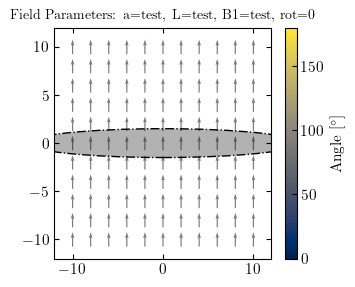

In [37]:
x = np.linspace(-10,10, 11)
y = 0 
z =  np.linspace(-10,10, 11)
x, z = np.meshgrid(x,z)

ang = model_c(x=x, y=y, z=z, a=0, L=1, B1=1, return_angle=True)

plot_polarization_angles(x=x, z=z, pol_ang=ang, field_param=["test"]*3, scale=15, lim_axes=12,)